In [1]:
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from time import time
from os import path, makedirs, remove
from shutil import copy, move
%matplotlib inline

def show_img(img):
    plt.imshow(np.asarray(Image.open(img)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [2]:
def aHash(imgfile, size=(8, 8)):
    im = Image.open(imgfile)
    im_data = im.resize(size, Image.ANTIALIAS).getdata()
    avg = np.array(im_data).mean()
    return ['0' if x < avg else '1' for x in im_data]

def dHash(imgfile, size=(8, 9)):
    im = Image.open(imgfile)
    pixels = im.resize(size, Image.ANTIALIAS).load()
    bin_list = list()
    h, w = size
    for i in range(h):
        for j in range(w-1):
            b = '0' if pixels[i, j] < pixels[i, j+1] else '1'
            bin_list.append(b)

    return bin_list

def pHash(imgfile):
    img = cv2.imread(imgfile, 0)
    img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
    dct = np.zeros((32, 32), np.float32)
    dct[:32, :32] = img
    dct = cv2.dct(dct)
    dct_8 = dct[:8, :8]
    
    dl = np.array(dct_8.tolist()).flatten()
    avg = dl.mean()
    
    return ['0' if d < avg else '1' for d in dl]

def binlist2int(l):
    return int(''.join(l), 2)

In [3]:
images = glob('/data/kdd/cache/art_gray_256/*/*')
images = [f.replace('\\', '/') for f in images]

extract_cid_aid = lambda x: path.basename(x).split('.')[0].split('_')
datasets_raw = [(x, *extract_cid_aid(x)) for x in images]

def gen_image_hash_datasets(datasets_raw):
    return [(*x, binlist2int(aHash(x[0])), binlist2int(dHash(x[0])), binlist2int(pHash(x[0]))) for x in datasets_raw]

start_time = time()
datasets = gen_image_hash_datasets(datasets_raw)
print('cost time {} s'.format(time() - start_time))

def save_datasets(datasets):
    with open('adphash_datasets.csv', 'a+', encoding='utf-8') as f:
        for url, cid, aid, ahash, dhash, phash in datasets:
            line = '{},{},{},{},{},{}'.format(url, cid, aid, ahash, dhash, phash)
            f.write('{}\n'.format(line))
        f.close()

start_time = time()
save_datasets(datasets)
print('cost time {} s'.format(time() - start_time))

cost time 824.0216987133026 s
cost time 0.6739518642425537 s


In [10]:
df = pd.read_csv('adphash_datasets.csv')
phash_df = df.sort_values('phash').groupby('phash')[['aid']].count().sort_values('aid', ascending=False)
phash_df = pd.DataFrame({'phash': phash_df.index, 'count': phash_df['aid']}).reset_index(drop=True)
total = phash_df['count'].sum()
phash_df['percent'] = round(phash_df['count'] * 100 / total, 2)

In [13]:
phash_df.head()

,phash,count,percent
0,9223372036854775808,359,0.11
1,11529355783556825088,81,0.02
2,9223512774343131136,77,0.02
3,11529215046068469760,72,0.02
4,9259400833873739776,45,0.01


In [17]:
phash_df[phash_df['count'] == 6].tail()

,phash,count,percent
87,14461290678289699420,6,0.0
88,10422530823458128320,6,0.0
89,13366683971061071884,6,0.0
90,14447552552415264768,6,0.0
91,14457824878973718592,6,0.0


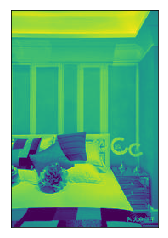

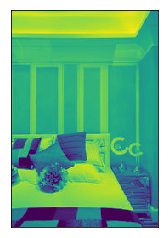

In [19]:
phash_imgs2 = df[df.phash == 10422530823458128320]['url'].tolist()

show_img(phash_imgs2[0])
show_img(phash_imgs2[2])

In [ ]:
show_img(phash_imgs2[0])
show_img(phash_imgs2[1])

In [8]:
df.sort_values(['cid', 'aid']).to_csv('adphash_datasets.csv', index=False)

In [20]:
df[df.phash == 10422530823458128320]

,url,cid,aid,ahash,dhash,phash
56869,/data/kdd/cache/art_gray_256/552548/552548_233...,552548,2338858,18446459284293737472,14838760274855851990,10422530823458128320
145441,/data/kdd/cache/art_gray_256/1212231/1212231_6...,1212231,6403816,18446459284293737472,14838795459227940823,10422530823458128320
163148,/data/kdd/cache/art_gray_256/1217351/1217351_6...,1217351,6432652,18446459284293737472,14838760274855851991,10422530823458128320
196312,/data/kdd/cache/art_gray_256/1227856/1227856_6...,1227856,6490405,18446459284293737472,14838760274855851975,10422530823458128320
210752,/data/kdd/cache/art_gray_256/1232752/1232752_6...,1232752,6518007,18446459284293737472,17144603284069545943,10422530823458128320
319152,/data/kdd/cache/art_gray_256/1779746/1779746_9...,1779746,9714360,18446459284293737472,14838795459227940807,10422530823458128320


In [21]:
ahash_df = df.sort_values('ahash').groupby('ahash')[['dhash']].count().sort_values('dhash', ascending=False)
ahash_df = pd.DataFrame({'ahash': ahash_df.index, 'count': ahash_df['dhash']}).reset_index(drop=True)
total = ahash_df['count'].sum()
ahash_df['percent(%)'] = round(ahash_df['count'] * 100 / total, 2)

In [22]:
ahash_df

,ahash,count,percent(%)
0,18446744069414584320,36,0.01
1,18446744073692774400,33,0.01
2,18446744073642442752,18,0.01
3,4340410370284600380,14,0.00
4,14106333703424951235,14,0.00
5,18446744073659219968,13,0.00
6,1085102592571150095,11,0.00
7,18446744073701163008,11,0.00
8,18446462598732906495,10,0.00
9,281474976645120,10,0.00


In [23]:
def ahash_repeat(ahash_df):
    repeat_rootdir = '/data/kdd/cache/repeat/ahash'
    if not path.isdir(repeat_rootdir):
        makedirs(repeat_rootdir)
    ahash_df_repeat = ahash_df[ahash_df['count']>1]
    print('{} repeat ahashes\n-----'.format(ahash_df_repeat.shape[0]))
    repeat_to = list()
    for h in ahash_df_repeat['ahash']:
        repeat_dir = '{}/{}'.format(repeat_rootdir, h)
        if not path.isdir(repeat_dir):
            makedirs(repeat_dir)
        ahash_imgs = df[df.ahash == h]['url'].tolist()
        repeat_to.append((h, ahash_imgs[0]))
        print('ahash {} hash {} repeat images'.format(h, len(ahash_imgs)-1))
        print('moving...\n')
        for img in ahash_imgs[1:]:
            # copy(img, repeat_dir)
            move(img, repeat_dir)
    return repeat_to

In [24]:
repeat_to = ahash_repeat(ahash_df)

18906 repeat ahashes
-----
ahash 18446744069414584320 hash 35 repeat images
moving...

ahash 18446744073692774400 hash 32 repeat images
moving...

ahash 18446744073642442752 hash 17 repeat images
moving...

ahash 4340410370284600380 hash 13 repeat images
moving...

ahash 14106333703424951235 hash 13 repeat images
moving...

ahash 18446744073659219968 hash 12 repeat images
moving...

ahash 1085102592571150095 hash 10 repeat images
moving...

ahash 18446744073701163008 hash 10 repeat images
moving...

ahash 18446462598732906495 hash 9 repeat images
moving...

ahash 281474976645120 hash 9 repeat images
moving...

ahash 18446744069431361536 hash 8 repeat images
moving...

ahash 18411139144890810879 hash 8 repeat images
moving...

ahash 18446716787832850183 hash 8 repeat images
moving...

ahash 18446744072604358664 hash 8 repeat images
moving...

ahash 8952149441158855704 hash 8 repeat images
moving...

ahash 18446744073424338944 hash 8 repeat images
moving...

ahash 18446637985882752196 ha

ahash 18374686472563867905 hash 4 repeat images
moving...

ahash 18445037618713330688 hash 4 repeat images
moving...

ahash 18229699340212241920 hash 4 repeat images
moving...

ahash 18373799027178668032 hash 4 repeat images
moving...

ahash 18446740623216050560 hash 4 repeat images
moving...

ahash 4330237464827321661 hash 4 repeat images
moving...

ahash 2062260358921289728 hash 4 repeat images
moving...

ahash 18445052886867050496 hash 4 repeat images
moving...

ahash 4476154704482281504 hash 4 repeat images
moving...

ahash 14468034567582044111 hash 4 repeat images
moving...

ahash 18373838688292439679 hash 4 repeat images
moving...

ahash 18446737476605706240 hash 4 repeat images
moving...

ahash 3516781467934736 hash 4 repeat images
moving...

ahash 18338234366362124288 hash 4 repeat images
moving...

ahash 6831344769957299968 hash 4 repeat images
moving...

ahash 868082074063273086 hash 4 repeat images
moving...

ahash 4575515931865841921 hash 4 repeat images
moving...

ahash 93

ahash 17870282217503064579 hash 4 repeat images
moving...

ahash 17551640350542725891 hash 4 repeat images
moving...

ahash 18446743107779170360 hash 4 repeat images
moving...

ahash 8174448361290430720 hash 4 repeat images
moving...

ahash 18445041150235312385 hash 4 repeat images
moving...

ahash 18373631379079483391 hash 4 repeat images
moving...

ahash 8640138292911538176 hash 4 repeat images
moving...

ahash 18302063728012607488 hash 4 repeat images
moving...

ahash 9786268724099035186 hash 4 repeat images
moving...

ahash 9187201948704600080 hash 4 repeat images
moving...

ahash 18193556752084503556 hash 4 repeat images
moving...

ahash 18392453745964366655 hash 4 repeat images
moving...

ahash 18446423844185882752 hash 4 repeat images
moving...

ahash 652205064883863823 hash 4 repeat images
moving...

ahash 9286696179444490336 hash 4 repeat images
moving...

ahash 17580926752108687376 hash 4 repeat images
moving...

ahash 18446674532832952575 hash 3 repeat images
moving...

ahas

ahash 9187201944120135439 hash 3 repeat images
moving...

ahash 18410573492541721614 hash 3 repeat images
moving...

ahash 2318041886768156 hash 3 repeat images
moving...

ahash 9187201674459348995 hash 3 repeat images
moving...

ahash 4410432065061782527 hash 3 repeat images
moving...

ahash 11501946193060430852 hash 3 repeat images
moving...

ahash 2251377596925295668 hash 3 repeat images
moving...

ahash 18374377267898926856 hash 3 repeat images
moving...

ahash 4584663730620465153 hash 3 repeat images
moving...

ahash 18446743931975630848 hash 3 repeat images
moving...

ahash 4402774253720781823 hash 3 repeat images
moving...

ahash 18374333532139462848 hash 3 repeat images
moving...

ahash 9187201931167335169 hash 3 repeat images
moving...

ahash 18445896095898067168 hash 3 repeat images
moving...

ahash 18338515228236455968 hash 3 repeat images
moving...

ahash 18446452681567371396 hash 3 repeat images
moving...

ahash 4552923736240567935 hash 3 repeat images
moving...

ahash 918

ahash 18446673170292476673 hash 3 repeat images
moving...

ahash 18446459286247702528 hash 3 repeat images
moving...

ahash 4575440631348986684 hash 3 repeat images
moving...

ahash 16283011713517871152 hash 3 repeat images
moving...

ahash 18374165501749302783 hash 3 repeat images
moving...

ahash 9006783908702060592 hash 3 repeat images
moving...

ahash 18228381306568576078 hash 3 repeat images
moving...

ahash 18445613775739420672 hash 3 repeat images
moving...

ahash 8970181981677308000 hash 3 repeat images
moving...

ahash 18446452734921804800 hash 3 repeat images
moving...

ahash 18446744069532221696 hash 3 repeat images
moving...

ahash 18446744009838771228 hash 3 repeat images
moving...

ahash 18410573982970413571 hash 3 repeat images
moving...

ahash 72375360444006142 hash 3 repeat images
moving...

ahash 18446741295554900276 hash 3 repeat images
moving...

ahash 17293392076947331132 hash 3 repeat images
moving...

ahash 13762706120104747008 hash 3 repeat images
moving...

aha

ahash 4557430888798830399 hash 3 repeat images
moving...

ahash 18410714619560624332 hash 3 repeat images
moving...

ahash 4340410370284608540 hash 3 repeat images
moving...

ahash 16638241986274451648 hash 3 repeat images
moving...

ahash 18446744047823821844 hash 3 repeat images
moving...

ahash 18410573961351676000 hash 3 repeat images
moving...

ahash 35719044987928 hash 3 repeat images
moving...

ahash 9187201881642441985 hash 3 repeat images
moving...

ahash 18446602391379849507 hash 3 repeat images
moving...

ahash 18446744073645589249 hash 3 repeat images
moving...

ahash 11205971390056610108 hash 3 repeat images
moving...

ahash 18230286513487218908 hash 3 repeat images
moving...

ahash 9114862765002751488 hash 3 repeat images
moving...

ahash 18374405002513875004 hash 3 repeat images
moving...

ahash 18373803420638512128 hash 3 repeat images
moving...

ahash 4557413247021949251 hash 3 repeat images
moving...

ahash 17870280001275823128 hash 3 repeat images
moving...

ahash 18

ahash 2238024097449575943 hash 3 repeat images
moving...

ahash 4498654359580578016 hash 3 repeat images
moving...

ahash 18446489915007975228 hash 3 repeat images
moving...

ahash 18446744073290135590 hash 3 repeat images
moving...

ahash 15841932693534245249 hash 3 repeat images
moving...

ahash 11598949645870481600 hash 3 repeat images
moving...

ahash 8970181326824815676 hash 3 repeat images
moving...

ahash 18446247628074058496 hash 3 repeat images
moving...

ahash 17940362863842963456 hash 3 repeat images
moving...

ahash 16711714102704275456 hash 3 repeat images
moving...

ahash 17797944239341961217 hash 3 repeat images
moving...

ahash 9287800003323558912 hash 3 repeat images
moving...

ahash 18410289708530844808 hash 3 repeat images
moving...

ahash 9115285638249976856 hash 3 repeat images
moving...

ahash 9114857224328200192 hash 3 repeat images
moving...

ahash 7489291624095160344 hash 3 repeat images
moving...

ahash 9223370381346799616 hash 3 repeat images
moving...

ahash

ahash 9187186353341479960 hash 2 repeat images
moving...

ahash 16125111973414421146 hash 2 repeat images
moving...

ahash 8952087558125141566 hash 2 repeat images
moving...

ahash 13783597647471901950 hash 2 repeat images
moving...

ahash 18373693003846971632 hash 2 repeat images
moving...

ahash 18429226379634796258 hash 2 repeat images
moving...

ahash 8952087351298344911 hash 2 repeat images
moving...

ahash 17941493176882962436 hash 2 repeat images
moving...

ahash 9168904973119520770 hash 2 repeat images
moving...

ahash 9150308305593960512 hash 2 repeat images
moving...

ahash 18338233805822232584 hash 2 repeat images
moving...

ahash 4557426439011115831 hash 2 repeat images
moving...

ahash 1021804941337965111 hash 2 repeat images
moving...

ahash 2742336741407210531 hash 2 repeat images
moving...

ahash 17941493007164899329 hash 2 repeat images
moving...

ahash 18373694273917689904 hash 2 repeat images
moving...

ahash 15121363376497819936 hash 2 repeat images
moving...

ahash

ahash 11447935878194338067 hash 2 repeat images
moving...

ahash 1013044998502432764 hash 2 repeat images
moving...

ahash 18446667830121398528 hash 2 repeat images
moving...

ahash 18446744068443627616 hash 2 repeat images
moving...

ahash 18446708747587027072 hash 2 repeat images
moving...

ahash 18446460502788852892 hash 2 repeat images
moving...

ahash 18446667901138153584 hash 2 repeat images
moving...

ahash 18374333221800247296 hash 2 repeat images
moving...

ahash 78611323224063 hash 2 repeat images
moving...

ahash 8712487227358736992 hash 2 repeat images
moving...

ahash 14123287374656110823 hash 2 repeat images
moving...

ahash 4557422092702220288 hash 2 repeat images
moving...

ahash 8712487227360829952 hash 2 repeat images
moving...

ahash 17202342088071184440 hash 2 repeat images
moving...

ahash 5498735159575343200 hash 2 repeat images
moving...

ahash 9223319190566338560 hash 2 repeat images
moving...

ahash 13889313184911720255 hash 2 repeat images
moving...

ahash 184

ahash 18446744052285244161 hash 2 repeat images
moving...

ahash 18390793472902180208 hash 2 repeat images
moving...

ahash 18373799010010931232 hash 2 repeat images
moving...

ahash 18442091466097952768 hash 2 repeat images
moving...

ahash 8970181430840131584 hash 2 repeat images
moving...

ahash 217020518716357884 hash 2 repeat images
moving...

ahash 648519432917545859 hash 2 repeat images
moving...

ahash 18446737924927798859 hash 2 repeat images
moving...

ahash 4548424516866547712 hash 2 repeat images
moving...

ahash 5728578622869471480 hash 2 repeat images
moving...

ahash 16059588881594368128 hash 2 repeat images
moving...

ahash 2215409810859816627 hash 2 repeat images
moving...

ahash 18446515304023490944 hash 2 repeat images
moving...

ahash 4574806197246820369 hash 2 repeat images
moving...

ahash 18446743047263628326 hash 2 repeat images
moving...

ahash 18428601873184342024 hash 2 repeat images
moving...

ahash 18192413977506544109 hash 2 repeat images
moving...

ahash 

ahash 9164622120934915198 hash 2 repeat images
moving...

ahash 18300686430856289340 hash 2 repeat images
moving...

ahash 9115140492430672924 hash 2 repeat images
moving...

ahash 18446743493888770048 hash 2 repeat images
moving...

ahash 15600184327852396050 hash 2 repeat images
moving...

ahash 9115140510229725186 hash 2 repeat images
moving...

ahash 1736277506794719487 hash 2 repeat images
moving...

ahash 9187199742820548864 hash 2 repeat images
moving...

ahash 18428650475736293472 hash 2 repeat images
moving...

ahash 18446737450765680860 hash 2 repeat images
moving...

ahash 17940296635535732256 hash 2 repeat images
moving...

ahash 18446743481108793856 hash 2 repeat images
moving...

ahash 9501407328875807617 hash 2 repeat images
moving...

ahash 18446319898974007296 hash 2 repeat images
moving...

ahash 9169115795611714564 hash 2 repeat images
moving...

ahash 18446744043863146511 hash 2 repeat images
moving...

ahash 656386432206307584 hash 2 repeat images
moving...

ahash 

ahash 4584249486525472524 hash 2 repeat images
moving...

ahash 18356598400941860002 hash 2 repeat images
moving...

ahash 799168203661182743 hash 2 repeat images
moving...

ahash 18445898405487312896 hash 2 repeat images
moving...

ahash 13834916760286920705 hash 2 repeat images
moving...

ahash 4328199866783119416 hash 2 repeat images
moving...

ahash 9223372035767731202 hash 2 repeat images
moving...

ahash 18446704352228540416 hash 2 repeat images
moving...

ahash 18373838743268806848 hash 2 repeat images
moving...

ahash 18192465373167620158 hash 2 repeat images
moving...

ahash 18444480796732539843 hash 2 repeat images
moving...

ahash 18445898338899267102 hash 2 repeat images
moving...

ahash 18374685492286203392 hash 2 repeat images
moving...

ahash 15625595556389477468 hash 2 repeat images
moving...

ahash 18410453627427526813 hash 2 repeat images
moving...

ahash 2198213525570123902 hash 2 repeat images
moving...

ahash 16040902344643642496 hash 2 repeat images
moving...

aha

ahash 18446600567982137440 hash 2 repeat images
moving...

ahash 9097197513991081214 hash 2 repeat images
moving...

ahash 18419599192114528513 hash 2 repeat images
moving...

ahash 9223336133012495384 hash 2 repeat images
moving...

ahash 18446744064993787904 hash 2 repeat images
moving...

ahash 18318537702800890936 hash 2 repeat images
moving...

ahash 18338112342133373168 hash 2 repeat images
moving...

ahash 958509497750719749 hash 2 repeat images
moving...

ahash 9169116902914398208 hash 2 repeat images
moving...

ahash 18446742973913169920 hash 2 repeat images
moving...

ahash 1763425298742538464 hash 2 repeat images
moving...

ahash 8970746486241000960 hash 2 repeat images
moving...

ahash 18446742974080483425 hash 2 repeat images
moving...

ahash 18446410650042286304 hash 2 repeat images
moving...

ahash 18374402969521405452 hash 2 repeat images
moving...

ahash 18446739621976735856 hash 2 repeat images
moving...

ahash 18446744064851181568 hash 2 repeat images
moving...

ahas

ahash 9185144445041467463 hash 2 repeat images
moving...

ahash 9180446550590423040 hash 2 repeat images
moving...

ahash 18446730620823503810 hash 2 repeat images
moving...

ahash 9476589012757235587 hash 2 repeat images
moving...

ahash 4593280866156282112 hash 2 repeat images
moving...

ahash 18445966990042990600 hash 2 repeat images
moving...

ahash 18229725664209587422 hash 2 repeat images
moving...

ahash 17902583402851266812 hash 2 repeat images
moving...

ahash 18229697131885412352 hash 2 repeat images
moving...

ahash 18374344302961680626 hash 2 repeat images
moving...

ahash 18338110186242767103 hash 2 repeat images
moving...

ahash 18221811348791156976 hash 2 repeat images
moving...

ahash 9169116824797342744 hash 2 repeat images
moving...

ahash 18300791666320195776 hash 2 repeat images
moving...

ahash 18319677600273825920 hash 2 repeat images
moving...

ahash 18438831867306802176 hash 2 repeat images
moving...

ahash 18438831883912577408 hash 2 repeat images
moving...

ah

ahash 18410503411574702088 hash 2 repeat images
moving...

ahash 305325634697887356 hash 2 repeat images
moving...

ahash 18446602624985072716 hash 2 repeat images
moving...

ahash 18336670851868975328 hash 2 repeat images
moving...

ahash 18446743794536677376 hash 2 repeat images
moving...

ahash 18446744072904245248 hash 2 repeat images
moving...

ahash 18410500856825257487 hash 2 repeat images
moving...

ahash 8970324928966459392 hash 2 repeat images
moving...

ahash 1089623836208095713 hash 2 repeat images
moving...

ahash 1099511627775 hash 2 repeat images
moving...

ahash 18446462603044816895 hash 2 repeat images
moving...

ahash 18446743794537137927 hash 2 repeat images
moving...

ahash 1089623784655356675 hash 2 repeat images
moving...

ahash 2242545357978337280 hash 2 repeat images
moving...

ahash 9277627166988672927 hash 2 repeat images
moving...

ahash 10987796828853846784 hash 2 repeat images
moving...

ahash 36452768704921471 hash 2 repeat images
moving...

ahash 23057005

ahash 13817008308545962176 hash 2 repeat images
moving...

ahash 18442803145383870480 hash 2 repeat images
moving...

ahash 18446463117085491392 hash 2 repeat images
moving...

ahash 18374403900755148800 hash 2 repeat images
moving...

ahash 6949180099710824464 hash 2 repeat images
moving...

ahash 9006845893253270552 hash 2 repeat images
moving...

ahash 2242545357982480231 hash 2 repeat images
moving...

ahash 18446620576323077391 hash 2 repeat images
moving...

ahash 18446531934789500940 hash 2 repeat images
moving...

ahash 2602922263537532542 hash 2 repeat images
moving...

ahash 6949177881175027712 hash 2 repeat images
moving...

ahash 8676165917085270016 hash 2 repeat images
moving...

ahash 9187201690716140784 hash 2 repeat images
moving...

ahash 2603186193519623230 hash 2 repeat images
moving...

ahash 2242545357980376863 hash 2 repeat images
moving...

ahash 9113368235213320700 hash 2 repeat images
moving...

ahash 18433170494802010252 hash 2 repeat images
moving...

ahash 3

ahash 9364952017610876032 hash 2 repeat images
moving...

ahash 18446602508335849504 hash 2 repeat images
moving...

ahash 17361650275076485120 hash 2 repeat images
moving...

ahash 18446744072669364224 hash 2 repeat images
moving...

ahash 18369882640054362116 hash 2 repeat images
moving...

ahash 18372708358946857152 hash 2 repeat images
moving...

ahash 4575445287306199072 hash 2 repeat images
moving...

ahash 18265825204557728960 hash 2 repeat images
moving...

ahash 18355791247273103488 hash 2 repeat images
moving...

ahash 18410500013872906368 hash 2 repeat images
moving...

ahash 515582130365988867 hash 2 repeat images
moving...

ahash 2242545357979587343 hash 2 repeat images
moving...

ahash 14411518795744018564 hash 2 repeat images
moving...

ahash 2305771803989868800 hash 2 repeat images
moving...

ahash 9187329442169487384 hash 2 repeat images
moving...

ahash 18374403900863186439 hash 2 repeat images
moving...

ahash 18446698886291521560 hash 2 repeat images
moving...

ahas

ahash 4681765513702457472 hash 2 repeat images
moving...

ahash 1122270500615700255 hash 2 repeat images
moving...

ahash 13744027961168802036 hash 2 repeat images
moving...

ahash 16717325427688898945 hash 2 repeat images
moving...

ahash 9186915374574674208 hash 2 repeat images
moving...

ahash 18392453621729075444 hash 2 repeat images
moving...

ahash 18410220767596775448 hash 2 repeat images
moving...

ahash 2242536501589384222 hash 2 repeat images
moving...

ahash 18446743986765840384 hash 2 repeat images
moving...

ahash 16711679 hash 2 repeat images
moving...

ahash 18446602785441972224 hash 2 repeat images
moving...

ahash 16777215 hash 2 repeat images
moving...

ahash 18446567463622566598 hash 2 repeat images
moving...

ahash 18446742003568869393 hash 2 repeat images
moving...

ahash 2242536527395495450 hash 2 repeat images
moving...

ahash 4340410163258163006 hash 2 repeat images
moving...

ahash 18446461852251338864 hash 2 repeat images
moving...

ahash 18410503118646042816 

ahash 18229887347850219263 hash 2 repeat images
moving...

ahash 18374245640455061504 hash 2 repeat images
moving...

ahash 9114861777563443200 hash 2 repeat images
moving...

ahash 9114296343468716032 hash 2 repeat images
moving...

ahash 4539345836417431592 hash 2 repeat images
moving...

ahash 18446744073441132544 hash 2 repeat images
moving...

ahash 4557113988780803075 hash 2 repeat images
moving...

ahash 18410503321045766256 hash 2 repeat images
moving...

ahash 17937870846428194319 hash 2 repeat images
moving...

ahash 18437524939814141952 hash 2 repeat images
moving...

ahash 18446744001216249856 hash 2 repeat images
moving...

ahash 18446744073436921856 hash 2 repeat images
moving...

ahash 4557430888766959864 hash 2 repeat images
moving...

ahash 18085325774562853104 hash 2 repeat images
moving...

ahash 9114861777562401912 hash 2 repeat images
moving...

ahash 1098663063541452547 hash 2 repeat images
moving...

ahash 4760215395322560512 hash 2 repeat images
moving...

ahash

ahash 4337726151546159152 hash 2 repeat images
moving...

ahash 18446602301252703744 hash 2 repeat images
moving...

ahash 18316386113115644927 hash 2 repeat images
moving...

ahash 18446426274551169024 hash 2 repeat images
moving...

ahash 18446743821392805916 hash 2 repeat images
moving...

ahash 434315919653261283 hash 2 repeat images
moving...

ahash 9006347102238598880 hash 2 repeat images
moving...

ahash 9150881502565500928 hash 2 repeat images
moving...

ahash 18428448237146656767 hash 2 repeat images
moving...

ahash 9169080412065107494 hash 2 repeat images
moving...

ahash 36028659515582432 hash 2 repeat images
moving...

ahash 9169327579009924148 hash 2 repeat images
moving...

ahash 17363902077171437760 hash 2 repeat images
moving...

ahash 9842898390795362057 hash 2 repeat images
moving...

ahash 222707240083522584 hash 2 repeat images
moving...

ahash 18446461218077048832 hash 2 repeat images
moving...

ahash 18446602275528902144 hash 2 repeat images
moving...

ahash 1844

ahash 18446247198005067776 hash 2 repeat images
moving...

ahash 9111470832058632288 hash 2 repeat images
moving...

ahash 18374621336834033155 hash 2 repeat images
moving...

ahash 4501485253562210304 hash 2 repeat images
moving...

ahash 1773464696291317968 hash 2 repeat images
moving...

ahash 13821353258351296644 hash 2 repeat images
moving...

ahash 18437701549947879424 hash 2 repeat images
moving...

ahash 4340975480657026584 hash 2 repeat images
moving...

ahash 18193681542747717345 hash 2 repeat images
moving...

ahash 18154557456331312143 hash 2 repeat images
moving...

ahash 18229411276629739134 hash 2 repeat images
moving...

ahash 4333728927005805824 hash 2 repeat images
moving...

ahash 17551543265290076352 hash 2 repeat images
moving...

ahash 18446740469979316416 hash 2 repeat images
moving...

ahash 440822928197083376 hash 2 repeat images
moving...

ahash 9150465601784038400 hash 2 repeat images
moving...

ahash 18193680461891374104 hash 2 repeat images
moving...

ahash

ahash 18410553945997992032 hash 2 repeat images
moving...

ahash 18446744070068895744 hash 2 repeat images
moving...

ahash 18282495697628480764 hash 2 repeat images
moving...

ahash 18446470213187723488 hash 2 repeat images
moving...

ahash 9187179936724288518 hash 2 repeat images
moving...

ahash 8681950968871925904 hash 2 repeat images
moving...

ahash 71212065276958776 hash 2 repeat images
moving...

ahash 18446682457389490400 hash 2 repeat images
moving...

ahash 6832191364103403552 hash 2 repeat images
moving...

ahash 5145210255258444256 hash 2 repeat images
moving...

ahash 3458693274257965248 hash 2 repeat images
moving...

ahash 18373833672858583745 hash 2 repeat images
moving...

ahash 4556371766636904448 hash 2 repeat images
moving...

ahash 1374463853207754808 hash 2 repeat images
moving...

ahash 4556375374886548383 hash 2 repeat images
moving...

ahash 18392313694825022464 hash 2 repeat images
moving...

ahash 4493576919143193600 hash 2 repeat images
moving...

ahash 182

ahash 18446743802052870144 hash 2 repeat images
moving...

ahash 18446744071889305672 hash 2 repeat images
moving...

ahash 9223228496717873920 hash 2 repeat images
moving...

ahash 9367486673456075296 hash 2 repeat images
moving...

ahash 9277696431401862913 hash 2 repeat images
moving...

ahash 18446234999826365433 hash 2 repeat images
moving...

ahash 18446448957884071936 hash 2 repeat images
moving...

ahash 4557515333316943422 hash 2 repeat images
moving...

ahash 9187166231399170048 hash 2 repeat images
moving...

ahash 16710604763783430144 hash 2 repeat images
moving...

ahash 14106333703424951295 hash 2 repeat images
moving...

ahash 18372981400170400992 hash 2 repeat images
moving...

ahash 18410196311719310051 hash 2 repeat images
moving...

ahash 18446463730219778112 hash 2 repeat images
moving...

ahash 18410284751164719328 hash 2 repeat images
moving...

ahash 18446497649424105568 hash 2 repeat images
moving...

ahash 18446743241428615200 hash 2 repeat images
moving...

ah

ahash 18410644584012188735 hash 1 repeat images
moving...

ahash 13816917829515413376 hash 1 repeat images
moving...

ahash 17581206172001110016 hash 1 repeat images
moving...

ahash 18444145656189935840 hash 1 repeat images
moving...

ahash 18374372855791224575 hash 1 repeat images
moving...

ahash 18446497230111117328 hash 1 repeat images
moving...

ahash 18374369669067866979 hash 1 repeat images
moving...

ahash 9169081842505286401 hash 1 repeat images
moving...

ahash 9169085991109950584 hash 1 repeat images
moving...

ahash 17581489995300929536 hash 1 repeat images
moving...

ahash 18410642422169864192 hash 1 repeat images
moving...

ahash 4575494958483637766 hash 1 repeat images
moving...

ahash 145838153126101983 hash 1 repeat images
moving...

ahash 18446732233352421472 hash 1 repeat images
moving...

ahash 18374385758914872832 hash 1 repeat images
moving...

ahash 18446734829180428288 hash 1 repeat images
moving...

ahash 18446735152841253956 hash 1 repeat images
moving...

ah

ahash 13816686091275436160 hash 1 repeat images
moving...

ahash 9096918148365441148 hash 1 repeat images
moving...

ahash 18410665004687808728 hash 1 repeat images
moving...

ahash 4575445149329655559 hash 1 repeat images
moving...

ahash 18444210185143060480 hash 1 repeat images
moving...

ahash 13816683814513601740 hash 1 repeat images
moving...

ahash 18410643993705591527 hash 1 repeat images
moving...

ahash 18338164547914171136 hash 1 repeat images
moving...

ahash 17580896138292109443 hash 1 repeat images
moving...

ahash 17578665689240223844 hash 1 repeat images
moving...

ahash 13816652834277964031 hash 1 repeat images
moving...

ahash 18446734673083105472 hash 1 repeat images
moving...

ahash 9169097038385906688 hash 1 repeat images
moving...

ahash 18338163169515277312 hash 1 repeat images
moving...

ahash 18221779386166744059 hash 1 repeat images
moving...

ahash 2169847543952578808 hash 1 repeat images
moving...

ahash 18444211904369455104 hash 1 repeat images
moving...

a

ahash 18338270343828934664 hash 1 repeat images
moving...

ahash 18446726374149357568 hash 1 repeat images
moving...

ahash 9113072290082910242 hash 1 repeat images
moving...

ahash 9113075792753854212 hash 1 repeat images
moving...

ahash 9169078582222719704 hash 1 repeat images
moving...

ahash 17797748599701810284 hash 1 repeat images
moving...

ahash 4557529418033594496 hash 1 repeat images
moving...

ahash 17797784163397797514 hash 1 repeat images
moving...

ahash 2089670227084115968 hash 1 repeat images
moving...

ahash 18446726378188497120 hash 1 repeat images
moving...

ahash 17797794156116740096 hash 1 repeat images
moving...

ahash 13770067035423719231 hash 1 repeat images
moving...

ahash 18212443162622368831 hash 1 repeat images
moving...

ahash 18446726377964306448 hash 1 repeat images
moving...

ahash 18446528716099353807 hash 1 repeat images
moving...

ahash 9259614026470866815 hash 1 repeat images
moving...

ahash 13769924889536397567 hash 1 repeat images
moving...

aha

ahash 18446527744273561726 hash 1 repeat images
moving...

ahash 18374298071756439552 hash 1 repeat images
moving...

ahash 2098078161978847234 hash 1 repeat images
moving...

ahash 18446726481311711248 hash 1 repeat images
moving...

ahash 221647401471737847 hash 1 repeat images
moving...

ahash 13780520896474583824 hash 1 repeat images
moving...

ahash 18443227292235845119 hash 1 repeat images
moving...

ahash 221682637399068615 hash 1 repeat images
moving...

ahash 18446726481019144192 hash 1 repeat images
moving...

ahash 18410715276438994944 hash 1 repeat images
moving...

ahash 4402551525008547603 hash 1 repeat images
moving...

ahash 18446726480999268584 hash 1 repeat images
moving...

ahash 2097867172454669436 hash 1 repeat images
moving...

ahash 18410715276540036864 hash 1 repeat images
moving...

ahash 9111470778638295808 hash 1 repeat images
moving...

ahash 224684364678502668 hash 1 repeat images
moving...

ahash 4404255793092833564 hash 1 repeat images
moving...

ahash 17

ahash 2054146789153159472 hash 1 repeat images
moving...

ahash 18442661649572888768 hash 1 repeat images
moving...

ahash 18203796949142863096 hash 1 repeat images
moving...

ahash 13744597447762947214 hash 1 repeat images
moving...

ahash 9264098499983477950 hash 1 repeat images
moving...

ahash 9264098706021980408 hash 1 repeat images
moving...

ahash 279400064603389688 hash 1 repeat images
moving...

ahash 9114262953369604096 hash 1 repeat images
moving...

ahash 279743258899449631 hash 1 repeat images
moving...

ahash 13744580463658220548 hash 1 repeat images
moving...

ahash 18203566740506197759 hash 1 repeat images
moving...

ahash 17852158969586400256 hash 1 repeat images
moving...

ahash 2053783064621645439 hash 1 repeat images
moving...

ahash 13744569904052876416 hash 1 repeat images
moving...

ahash 17852190310239631497 hash 1 repeat images
moving...

ahash 18412622686818606592 hash 1 repeat images
moving...

ahash 9114265712941097056 hash 1 repeat images
moving...

ahash 1

ahash 18338372831297151361 hash 1 repeat images
moving...

ahash 18446724450608749628 hash 1 repeat images
moving...

ahash 17833980531346225922 hash 1 repeat images
moving...

ahash 9169068476499951617 hash 1 repeat images
moving...

ahash 18210515095547295792 hash 1 repeat images
moving...

ahash 4412750826590452736 hash 1 repeat images
moving...

ahash 13758188894153786177 hash 1 repeat images
moving...

ahash 4557499046672927513 hash 1 repeat images
moving...

ahash 18374262497781089820 hash 1 repeat images
moving...

ahash 18338366245230895219 hash 1 repeat images
moving...

ahash 18338367139939229471 hash 1 repeat images
moving...

ahash 9260280443172291250 hash 1 repeat images
moving...

ahash 18446725375813730548 hash 1 repeat images
moving...

ahash 9114189537268528162 hash 1 repeat images
moving...

ahash 9169073372494234467 hash 1 repeat images
moving...

ahash 9114190653859194464 hash 1 repeat images
moving...

ahash 17831764160736077318 hash 1 repeat images
moving...

ahas

ahash 217051426108957633 hash 1 repeat images
moving...

ahash 4571277181133457191 hash 1 repeat images
moving...

ahash 9169081584573156864 hash 1 repeat images
moving...

ahash 4394665379184262270 hash 1 repeat images
moving...

ahash 17651128008759378177 hash 1 repeat images
moving...

ahash 18220504430059339376 hash 1 repeat images
moving...

ahash 17651328835019534337 hash 1 repeat images
moving...

ahash 9169081584559077123 hash 1 repeat images
moving...

ahash 18374342121556574208 hash 1 repeat images
moving...

ahash 18446730278064562176 hash 1 repeat images
moving...

ahash 18443357517380059136 hash 1 repeat images
moving...

ahash 4571012056152736527 hash 1 repeat images
moving...

ahash 2165118913073806944 hash 1 repeat images
moving...

ahash 13804548375453597952 hash 1 repeat images
moving...

ahash 217086710196928062 hash 1 repeat images
moving...

ahash 17651848796375646464 hash 1 repeat images
moving...

ahash 18443356715464198912 hash 1 repeat images
moving...

ahash 1

ahash 18446730826185310721 hash 1 repeat images
moving...

ahash 18446730826151363440 hash 1 repeat images
moving...

ahash 217017761094496484 hash 1 repeat images
moving...

ahash 18443613715082272879 hash 1 repeat images
moving...

ahash 2166814293442354912 hash 1 repeat images
moving...

ahash 18446730825666922761 hash 1 repeat images
moving...

ahash 2166509584527407132 hash 1 repeat images
moving...

ahash 4574933182217978435 hash 1 repeat images
moving...

ahash 9097048046440021887 hash 1 repeat images
moving...

ahash 4574880129689256192 hash 1 repeat images
moving...

ahash 217020515162783743 hash 1 repeat images
moving...

ahash 9223372036785586256 hash 1 repeat images
moving...

ahash 18220716355932438780 hash 1 repeat images
moving...

ahash 18446730823836107235 hash 1 repeat images
moving...

ahash 17653254005187436576 hash 1 repeat images
moving...

ahash 18446729727981922606 hash 1 repeat images
moving...

ahash 13803398202074005795 hash 1 repeat images
moving...

ahash 4

ahash 18443352182137832001 hash 1 repeat images
moving...

ahash 9097235358609245959 hash 1 repeat images
moving...

ahash 18446523342573211395 hash 1 repeat images
moving...

ahash 9097235886942143488 hash 1 repeat images
moving...

ahash 4395223991623151620 hash 1 repeat images
moving...

ahash 18446728620150939825 hash 1 repeat images
moving...

ahash 18338232169440740353 hash 1 repeat images
moving...

ahash 4566469775278505086 hash 1 repeat images
moving...

ahash 18219435922624093244 hash 1 repeat images
moving...

ahash 9097265115826226179 hash 1 repeat images
moving...

ahash 2162290776346672959 hash 1 repeat images
moving...

ahash 17699393924071678176 hash 1 repeat images
moving...

ahash 18446728617733801599 hash 1 repeat images
moving...

ahash 18374333769241862176 hash 1 repeat images
moving...

ahash 18374333602205822048 hash 1 repeat images
moving...

ahash 4566438985059598335 hash 1 repeat images
moving...

ahash 13800018275507339711 hash 1 repeat images
moving...

ahas

ahash 17363892729039709950 hash 1 repeat images
moving...

ahash 2238040792522262921 hash 1 repeat images
moving...

ahash 70086165377347584 hash 1 repeat images
moving...

ahash 18410538802817666048 hash 1 repeat images
moving...

ahash 18444765987610855502 hash 1 repeat images
moving...

ahash 17363894410570893191 hash 1 repeat images
moving...

ahash 70361854978355232 hash 1 repeat images
moving...

ahash 70703154601336956 hash 1 repeat images
moving...

ahash 2238024982159525839 hash 1 repeat images
moving...

ahash 4340940205468689528 hash 1 repeat images
moving...

ahash 18446466458849847079 hash 1 repeat images
moving...

ahash 18410539354292232192 hash 1 repeat images
moving...

ahash 70502315412422400 hash 1 repeat images
moving...

ahash 70368744169612350 hash 1 repeat images
moving...

ahash 18410539319941689536 hash 1 repeat images
moving...

ahash 17363901318172655422 hash 1 repeat images
moving...

ahash 2238025131999637504 hash 1 repeat images
moving...

ahash 1841053918

moving...

ahash 17362489208615145223 hash 1 repeat images
moving...

ahash 18374403898472530204 hash 1 repeat images
moving...

ahash 17362489148549636096 hash 1 repeat images
moving...

ahash 18337558412585091275 hash 1 repeat images
moving...

ahash 9081766464377851663 hash 1 repeat images
moving...

ahash 18228575544325242108 hash 1 repeat images
moving...

ahash 4611677445150573442 hash 1 repeat images
moving...

ahash 18446463911378518273 hash 1 repeat images
moving...

ahash 67818976711184384 hash 1 repeat images
moving...

ahash 18446463969616134336 hash 1 repeat images
moving...

ahash 4611678291516919558 hash 1 repeat images
moving...

ahash 18444770437385687288 hash 1 repeat images
moving...

ahash 13898671397871353856 hash 1 repeat images
moving...

ahash 18410512966534299648 hash 1 repeat images
moving...

ahash 18444770442492788740 hash 1 repeat images
moving...

ahash 9082634549881372671 hash 1 repeat images
moving...

ahash 9223228265458630913 hash 1 repeat images
movin

ahash 18446740749297909760 hash 1 repeat images
moving...

ahash 18446464909482459164 hash 1 repeat images
moving...

ahash 13892721929665436888 hash 1 repeat images
moving...

ahash 18446740587001479425 hash 1 repeat images
moving...

ahash 4611403336129085464 hash 1 repeat images
moving...

ahash 17365035738204209152 hash 1 repeat images
moving...

ahash 18446475793982191267 hash 1 repeat images
moving...

ahash 18446739916189665667 hash 1 repeat images
moving...

ahash 4341258658592591631 hash 1 repeat images
moving...

ahash 9095089259927429616 hash 1 repeat images
moving...

ahash 4341258381458152478 hash 1 repeat images
moving...

ahash 4602675515805925376 hash 1 repeat images
moving...

ahash 18446739918848983040 hash 1 repeat images
moving...

ahash 4602676609261094080 hash 1 repeat images
moving...

ahash 18444738573107002616 hash 1 repeat images
moving...

ahash 4341258381441375246 hash 1 repeat images
moving...

ahash 4602677299058886151 hash 1 repeat images
moving...

ahash

ahash 18337659809186068480 hash 1 repeat images
moving...

ahash 18374403450469496592 hash 1 repeat images
moving...

ahash 18410566208919396424 hash 1 repeat images
moving...

ahash 18446477483370398849 hash 1 repeat images
moving...

ahash 18446739675931509759 hash 1 repeat images
moving...

ahash 18410566157060816900 hash 1 repeat images
moving...

ahash 18410565778572533760 hash 1 repeat images
moving...

ahash 9095607220628036732 hash 1 repeat images
moving...

ahash 9169116907223717948 hash 1 repeat images
moving...

ahash 18444707692149211649 hash 1 repeat images
moving...

ahash 18410565733462055936 hash 1 repeat images
moving...

ahash 17365594599557987428 hash 1 repeat images
moving...

ahash 18228443051296110719 hash 1 repeat images
moving...

ahash 18337637552660439288 hash 1 repeat images
moving...

ahash 18228482163507347585 hash 1 repeat images
moving...

ahash 2237864051402873856 hash 1 repeat images
moving...

ahash 18444757125209988867 hash 1 repeat images
moving...



ahash 9169117183123783682 hash 1 repeat images
moving...

ahash 18446470519929964063 hash 1 repeat images
moving...

ahash 18446470877408599838 hash 1 repeat images
moving...

ahash 71774484877549628 hash 1 repeat images
moving...

ahash 9169117182101035039 hash 1 repeat images
moving...

ahash 17364891960343252728 hash 1 repeat images
moving...

ahash 18446470875252326407 hash 1 repeat images
moving...

ahash 17364877562098564991 hash 1 repeat images
moving...

ahash 18374403759658107920 hash 1 repeat images
moving...

ahash 18374403760291774720 hash 1 repeat images
moving...

ahash 18410556826286325760 hash 1 repeat images
moving...

ahash 18446470847872306947 hash 1 repeat images
moving...

ahash 17364781729479787034 hash 1 repeat images
moving...

ahash 2238013089061347103 hash 1 repeat images
moving...

ahash 18228520590843980832 hash 1 repeat images
moving...

ahash 4341046712636802108 hash 1 repeat images
moving...

ahash 13889878342934431872 hash 1 repeat images
moving...

ahas

ahash 17361623885971177219 hash 1 repeat images
moving...

ahash 18410503324401411072 hash 1 repeat images
moving...

ahash 2242298105838371586 hash 1 repeat images
moving...

ahash 2242298104749908498 hash 1 repeat images
moving...

ahash 13939624355541745984 hash 1 repeat images
moving...

ahash 4631749095651215159 hash 1 repeat images
moving...

ahash 2242296989100027952 hash 1 repeat images
moving...

ahash 9223111534254764088 hash 1 repeat images
moving...

ahash 4632022922622289472 hash 1 repeat images
moving...

ahash 18446462594473657350 hash 1 repeat images
moving...

ahash 18446741796504469504 hash 1 repeat images
moving...

ahash 17361630099542700032 hash 1 repeat images
moving...

ahash 9169188075383816192 hash 1 repeat images
moving...

ahash 18336406874489682124 hash 1 repeat images
moving...

ahash 9042520777956527112 hash 1 repeat images
moving...

ahash 18336406857309809671 hash 1 repeat images
moving...

ahash 54605933969860162 hash 1 repeat images
moving...

ahash 18

ahash 54254821418334192 hash 1 repeat images
moving...

ahash 9038000309594324943 hash 1 repeat images
moving...

ahash 17361376563544981503 hash 1 repeat images
moving...

ahash 54254408528499512 hash 1 repeat images
moving...

ahash 9037861227710386207 hash 1 repeat images
moving...

ahash 18446741866037641218 hash 1 repeat images
moving...

ahash 18410503204477878531 hash 1 repeat images
moving...

ahash 18410503204476747806 hash 1 repeat images
moving...

ahash 18446462396198312541 hash 1 repeat images
moving...

ahash 17361060876974964984 hash 1 repeat images
moving...

ahash 9169205657100881167 hash 1 repeat images
moving...

ahash 18410503204410980352 hash 1 repeat images
moving...

ahash 2242261129912419982 hash 1 repeat images
moving...

ahash 13907115644958015488 hash 1 repeat images
moving...

ahash 55712254145331392 hash 1 repeat images
moving...

ahash 18446741045875122464 hash 1 repeat images
moving...

ahash 18374403900830650424 hash 1 repeat images
moving...

ahash 6332

ahash 18374403900460531736 hash 1 repeat images
moving...

ahash 4611685056245723137 hash 1 repeat images
moving...

ahash 18228584130486992896 hash 1 repeat images
moving...

ahash 9169184102341672960 hash 1 repeat images
moving...

ahash 17361658037870529541 hash 1 repeat images
moving...

ahash 13902678020373808911 hash 1 repeat images
moving...

ahash 18374403900366184672 hash 1 repeat images
moving...

ahash 64167461976284184 hash 1 repeat images
moving...

ahash 9169184214141371910 hash 1 repeat images
moving...

ahash 9079258214544776316 hash 1 repeat images
moving...

ahash 4611685190011331616 hash 1 repeat images
moving...

ahash 18228584201366452368 hash 1 repeat images
moving...

ahash 9079256999102743431 hash 1 repeat images
moving...

ahash 64110065688504192 hash 1 repeat images
moving...

ahash 17361656933343297536 hash 1 repeat images
moving...

ahash 18374403900452898816 hash 1 repeat images
moving...

ahash 9077565516316475655 hash 1 repeat images
moving...

ahash 1837

ahash 18336540514735898672 hash 1 repeat images
moving...

ahash 18336538837509145088 hash 1 repeat images
moving...

ahash 18374404175951919112 hash 1 repeat images
moving...

ahash 2241948189569523036 hash 1 repeat images
moving...

ahash 9050546398455861007 hash 1 repeat images
moving...

ahash 17361641485450211825 hash 1 repeat images
moving...

ahash 9049864651600325758 hash 1 repeat images
moving...

ahash 17361641484828082112 hash 1 repeat images
moving...

ahash 18228584461144981504 hash 1 repeat images
moving...

ahash 18446462599692884224 hash 1 repeat images
moving...

ahash 9070073171398624260 hash 1 repeat images
moving...

ahash 2241700108415406610 hash 1 repeat images
moving...

ahash 18446741428413206287 hash 1 repeat images
moving...

ahash 18228584443898003463 hash 1 repeat images
moving...

ahash 62202656220512768 hash 1 repeat images
moving...

ahash 9169187408491315200 hash 1 repeat images
moving...

ahash 18228584443901919232 hash 1 repeat images
moving...

ahash 

ahash 9096740306063222306 hash 1 repeat images
moving...

ahash 4575648319658876944 hash 1 repeat images
moving...

ahash 18446736294663946760 hash 1 repeat images
moving...

ahash 17538125187569747980 hash 1 repeat images
moving...

ahash 18226261965134145726 hash 1 repeat images
moving...

ahash 9096739650814291969 hash 1 repeat images
moving...

ahash 18410573987014115328 hash 1 repeat images
moving...

ahash 9169113583626249063 hash 1 repeat images
moving...

ahash 18410573987001155683 hash 1 repeat images
moving...

ahash 18446736312577859384 hash 1 repeat images
moving...

ahash 9096740454761774654 hash 1 repeat images
moving...

ahash 17542104883304750911 hash 1 repeat images
moving...

ahash 18338125088398827712 hash 1 repeat images
moving...

ahash 18338125536204887676 hash 1 repeat images
moving...

ahash 18446736308945551360 hash 1 repeat images
moving...

ahash 18226210654486559992 hash 1 repeat images
moving...

ahash 13826015464687452352 hash 1 repeat images
moving...

ah

ahash 90480956984212287 hash 1 repeat images
moving...

ahash 90476059584133374 hash 1 repeat images
moving...

ahash 18444464937018339391 hash 1 repeat images
moving...

ahash 90392944233901957 hash 1 repeat images
moving...

ahash 13834483987815917314 hash 1 repeat images
moving...

ahash 13834492878278102536 hash 1 repeat images
moving...

ahash 13834767920988438528 hash 1 repeat images
moving...

ahash 18444465850848608256 hash 1 repeat images
moving...

ahash 18410573968005162086 hash 1 repeat images
moving...

ahash 17507447726721396976 hash 1 repeat images
moving...

ahash 18410573965321765728 hash 1 repeat images
moving...

ahash 18410573965053411328 hash 1 repeat images
moving...

ahash 17507426620946809917 hash 1 repeat images
moving...

ahash 17507341156023203574 hash 1 repeat images
moving...

ahash 4359194582361440768 hash 1 repeat images
moving...

ahash 18374399485535584786 hash 1 repeat images
moving...

ahash 13834494010167019327 hash 1 repeat images
moving...

ahash 1

ahash 18446735169835729156 hash 1 repeat images
moving...

ahash 18374386098416696894 hash 1 repeat images
moving...

ahash 4376583768148672512 hash 1 repeat images
moving...

ahash 18444289705061072670 hash 1 repeat images
moving...

ahash 2170488592205422336 hash 1 repeat images
moving...

ahash 13816937137288774015 hash 1 repeat images
moving...

ahash 18223816580961714063 hash 1 repeat images
moving...

ahash 4575498234658224640 hash 1 repeat images
moving...

ahash 18446735173038424192 hash 1 repeat images
moving...

ahash 17578605722394476736 hash 1 repeat images
moving...

ahash 18338161772725804574 hash 1 repeat images
moving...

ahash 18446735173528092800 hash 1 repeat images
moving...

ahash 18374386235822317808 hash 1 repeat images
moving...

ahash 9096777563870594063 hash 1 repeat images
moving...

ahash 17578380521187051014 hash 1 repeat images
moving...

ahash 18446496817714049040 hash 1 repeat images
moving...

ahash 144149406602430208 hash 1 repeat images
moving...

aha

ahash 18446496756894073089 hash 1 repeat images
moving...

ahash 18446496782495056129 hash 1 repeat images
moving...

ahash 18410578402550580133 hash 1 repeat images
moving...

ahash 4367610131081195568 hash 1 repeat images
moving...

ahash 4367610778819231871 hash 1 repeat images
moving...

ahash 135943582874763264 hash 1 repeat images
moving...

ahash 9223371483844706304 hash 1 repeat images
moving...

ahash 9096775376188964864 hash 1 repeat images
moving...

ahash 18338145474183438432 hash 1 repeat images
moving...

ahash 18225219817383402748 hash 1 repeat images
moving...

ahash 135655493861864193 hash 1 repeat images
moving...

ahash 18374393983569756160 hash 1 repeat images
moving...

ahash 18374394018538124030 hash 1 repeat images
moving...

ahash 18338143576886403296 hash 1 repeat images
moving...

ahash 9169108111080325177 hash 1 repeat images
moving...

ahash 18410582806012775758 hash 1 repeat images
moving...

ahash 9169108111099566080 hash 1 repeat images
moving...

ahash 1

ahash 18410572874837524739 hash 1 repeat images
moving...

ahash 2233643852240456965 hash 1 repeat images
moving...

ahash 72587558642195217 hash 1 repeat images
moving...

ahash 13835373715387256576 hash 1 repeat images
moving...

ahash 13835407421318568192 hash 1 repeat images
moving...

ahash 9096211853274265600 hash 1 repeat images
moving...

ahash 18446739347517540108 hash 1 repeat images
moving...

ahash 17433707935962294525 hash 1 repeat images
moving...

ahash 4593292281302262908 hash 1 repeat images
moving...

ahash 18410572861752213504 hash 1 repeat images
moving...

ahash 72481485965739907 hash 1 repeat images
moving...

ahash 18374401695942180876 hash 1 repeat images
moving...

ahash 4358420353586364728 hash 1 repeat images
moving...

ahash 18410572607511266304 hash 1 repeat images
moving...

ahash 72395363989449155 hash 1 repeat images
moving...

ahash 4593447006332043459 hash 1 repeat images
moving...

ahash 18410572624758309151 hash 1 repeat images
moving...

ahash 45934

ahash 17402332854135943672 hash 1 repeat images
moving...

ahash 18337669024139970319 hash 1 repeat images
moving...

ahash 9096185344004226138 hash 1 repeat images
moving...

ahash 18337669016896111648 hash 1 repeat images
moving...

ahash 18337668669752737792 hash 1 repeat images
moving...

ahash 18446479156490211328 hash 1 repeat images
moving...

ahash 18410571253807644672 hash 1 repeat images
moving...

ahash 9096184930858727548 hash 1 repeat images
moving...

ahash 18446739616342419206 hash 1 repeat images
moving...

ahash 4593600398506917888 hash 1 repeat images
moving...

ahash 18337668669746192384 hash 1 repeat images
moving...

ahash 18228010421480879350 hash 1 repeat images
moving...

ahash 17403807536462431232 hash 1 repeat images
moving...

ahash 18446739619879257859 hash 1 repeat images
moving...

ahash 18337668664363327584 hash 1 repeat images
moving...

ahash 18337668663588699198 hash 1 repeat images
moving...

ahash 18374403048351517950 hash 1 repeat images
moving...



ahash 18226332613634100286 hash 1 repeat images
moving...

ahash 18446737444391886880 hash 1 repeat images
moving...

ahash 9223368180250705920 hash 1 repeat images
moving...

ahash 4359042899679919128 hash 1 repeat images
moving...

ahash 76976677594325312 hash 1 repeat images
moving...

ahash 76976205616628481 hash 1 repeat images
moving...

ahash 79095600305274062 hash 1 repeat images
moving...

ahash 13834916714122469408 hash 1 repeat images
moving...

ahash 2199128806387025667 hash 1 repeat images
moving...

ahash 79122066024892161 hash 1 repeat images
moving...

ahash 18446493398330966018 hash 1 repeat images
moving...

ahash 18410573882927874622 hash 1 repeat images
moving...

ahash 18410573882190695432 hash 1 repeat images
moving...

ahash 4583549213364912955 hash 1 repeat images
moving...

ahash 4583697402807860736 hash 1 repeat images
moving...

ahash 18446493359158145024 hash 1 repeat images
moving...

ahash 9223368669113878528 hash 1 repeat images
moving...

ahash 458376255

ahash 4592717916400288391 hash 1 repeat images
moving...

ahash 18374401675968380928 hash 1 repeat images
moving...

ahash 9223361041870668002 hash 1 repeat images
moving...

ahash 18446486840878697990 hash 1 repeat images
moving...

ahash 9169116752603447624 hash 1 repeat images
moving...

ahash 18446738559038652464 hash 1 repeat images
moving...

ahash 18226498215452016252 hash 1 repeat images
moving...

ahash 4584606823021091615 hash 1 repeat images
moving...

ahash 17435676987368015685 hash 1 repeat images
moving...

ahash 18226509230034379200 hash 1 repeat images
moving...

ahash 18410573577127657728 hash 1 repeat images
moving...

ahash 9169116752067363107 hash 1 repeat images
moving...

ahash 13835056917090664448 hash 1 repeat images
moving...

ahash 4584664280506908912 hash 1 repeat images
moving...

ahash 9096282778755667968 hash 1 repeat images
moving...

ahash 13835056947956027392 hash 1 repeat images
moving...

ahash 73148168259770392 hash 1 repeat images
moving...

ahash 1

ahash 18364746891322705152 hash 1 repeat images
moving...

ahash 18373700751934382176 hash 1 repeat images
moving...

ahash 9160179869748719616 hash 1 repeat images
moving...

ahash 18428729674763864832 hash 1 repeat images
moving...

ahash 18428729675195924480 hash 1 repeat images
moving...

ahash 18446601257867032576 hash 1 repeat images
moving...

ahash 4548370706019058432 hash 1 repeat images
moving...

ahash 18157313029757075970 hash 1 repeat images
moving...

ahash 4548370706019060894 hash 1 repeat images
moving...

ahash 11458336367924163812 hash 1 repeat images
moving...

ahash 4548370706019062836 hash 1 repeat images
moving...

ahash 18438266709705195905 hash 1 repeat images
moving...

ahash 11455177023308202627 hash 1 repeat images
moving...

ahash 18446668763764949251 hash 1 repeat images
moving...

ahash 18364796221385613826 hash 1 repeat images
moving...

ahash 18438230335305973916 hash 1 repeat images
moving...

ahash 4548362979256102911 hash 1 repeat images
moving...

ah

ahash 4485162184213399047 hash 1 repeat images
moving...

ahash 938726774098362363 hash 1 repeat images
moving...

ahash 18363595164750118655 hash 1 repeat images
moving...

ahash 18446671773279748096 hash 1 repeat images
moving...

ahash 938296282945224704 hash 1 repeat images
moving...

ahash 18446671773287104704 hash 1 repeat images
moving...

ahash 18446671774227628032 hash 1 repeat images
moving...

ahash 4485161913463091252 hash 1 repeat images
moving...

ahash 9160269823018991616 hash 1 repeat images
moving...

ahash 18428716012432102588 hash 1 repeat images
moving...

ahash 9134922664761606336 hash 1 repeat images
moving...

ahash 18373732344176319512 hash 1 repeat images
moving...

ahash 958700735030314500 hash 1 repeat images
moving...

ahash 11467623907998179902 hash 1 repeat images
moving...

ahash 4548370776885495296 hash 1 repeat images
moving...

ahash 18428729535676989440 hash 1 repeat images
moving...

ahash 18446601146259150336 hash 1 repeat images
moving...

ahash 18

ahash 9150440226978562449 hash 1 repeat images
moving...

ahash 1044980187780407545 hash 1 repeat images
moving...

ahash 1044980196370342137 hash 1 repeat images
moving...

ahash 17941496432783982848 hash 1 repeat images
moving...

ahash 18437948824185422023 hash 1 repeat images
moving...

ahash 1432418426815029151 hash 1 repeat images
moving...

ahash 18446601683699630080 hash 1 repeat images
moving...

ahash 9160074264893800128 hash 1 repeat images
moving...

ahash 18373662139893153792 hash 1 repeat images
moving...

ahash 1434396481313538304 hash 1 repeat images
moving...

ahash 18437948821458420736 hash 1 repeat images
moving...

ahash 18373666563667065080 hash 1 repeat images
moving...

ahash 18429718701000477183 hash 1 repeat images
moving...

ahash 4548103726826462988 hash 1 repeat images
moving...

ahash 18446650834851889282 hash 1 repeat images
moving...

ahash 18373667219455137920 hash 1 repeat images
moving...

ahash 18446601682595872784 hash 1 repeat images
moving...

ahas

ahash 9149899341169187336 hash 1 repeat images
moving...

ahash 1017389548545589756 hash 1 repeat images
moving...

ahash 17941492505391152152 hash 1 repeat images
moving...

ahash 9765923333275092911 hash 1 repeat images
moving...

ahash 17941492362984050808 hash 1 repeat images
moving...

ahash 18156679970466242335 hash 1 repeat images
moving...

ahash 9765923333106403279 hash 1 repeat images
moving...

ahash 11438789829170430466 hash 1 repeat images
moving...

ahash 4548361877401764611 hash 1 repeat images
moving...

ahash 9160096478528999179 hash 1 repeat images
moving...

ahash 4548361877578778503 hash 1 repeat images
moving...

ahash 18446601413359053836 hash 1 repeat images
moving...

ahash 9160100635853455360 hash 1 repeat images
moving...

ahash 18429082587731540989 hash 1 repeat images
moving...

ahash 17941492208311468048 hash 1 repeat images
moving...

ahash 18438160751244999167 hash 1 repeat images
moving...

ahash 4548361875414845468 hash 1 repeat images
moving...

ahash 

ahash 18446598370756804608 hash 1 repeat images
moving...

ahash 9115285611241276928 hash 1 repeat images
moving...

ahash 18373799005223182556 hash 1 repeat images
moving...

ahash 18446673427965161507 hash 1 repeat images
moving...

ahash 1736563831435871966 hash 1 repeat images
moving...

ahash 18158443043651402752 hash 1 repeat images
moving...

ahash 4548436717214058375 hash 1 repeat images
moving...

ahash 9506979531450748479 hash 1 repeat images
moving...

ahash 18446673428208418816 hash 1 repeat images
moving...

ahash 9115285542308027392 hash 1 repeat images
moving...

ahash 18428645438603367171 hash 1 repeat images
moving...

ahash 18358596496773886576 hash 1 repeat images
moving...

ahash 1736630199494655036 hash 1 repeat images
moving...

ahash 18446598325355216896 hash 1 repeat images
moving...

ahash 9165302421121505560 hash 1 repeat images
moving...

ahash 18446673610073447486 hash 1 repeat images
moving...

ahash 11502157556220443958 hash 1 repeat images
moving...

ahas

ahash 18373807836214918300 hash 1 repeat images
moving...

ahash 17940354033256036604 hash 1 repeat images
moving...

ahash 18439750801657495809 hash 1 repeat images
moving...

ahash 18446596185102774392 hash 1 repeat images
moving...

ahash 17940354034463437024 hash 1 repeat images
moving...

ahash 18428622709576483040 hash 1 repeat images
moving...

ahash 4548529523062407552 hash 1 repeat images
moving...

ahash 17940354033388093444 hash 1 repeat images
moving...

ahash 18428622638818525984 hash 1 repeat images
moving...

ahash 11514782841896409216 hash 1 repeat images
moving...

ahash 18428622581255700480 hash 1 repeat images
moving...

ahash 794664845089640455 hash 1 repeat images
moving...

ahash 18428622609704812544 hash 1 repeat images
moving...

ahash 17940354033255483528 hash 1 repeat images
moving...

ahash 4485086566388628606 hash 1 repeat images
moving...

ahash 1744085185105640472 hash 1 repeat images
moving...

ahash 18439776705677684880 hash 1 repeat images
moving...

ah

ahash 18428659302179209728 hash 1 repeat images
moving...

ahash 9132626709920285251 hash 1 repeat images
moving...

ahash 1731638454982082527 hash 1 repeat images
moving...

ahash 17940368455487770498 hash 1 repeat images
moving...

ahash 18438831315344773376 hash 1 repeat images
moving...

ahash 1731650683013118840 hash 1 repeat images
moving...

ahash 18428659276273205376 hash 1 repeat images
moving...

ahash 18446599748784751104 hash 1 repeat images
moving...

ahash 902271954049769407 hash 1 repeat images
moving...

ahash 18428659271005634560 hash 1 repeat images
moving...

ahash 18373768370754160640 hash 1 repeat images
moving...

ahash 18373768374451699712 hash 1 repeat images
moving...

ahash 9623558602071204320 hash 1 repeat images
moving...

ahash 904888091725004926 hash 1 repeat images
moving...

ahash 18157882309869378590 hash 1 repeat images
moving...

ahash 18373768081188100336 hash 1 repeat images
moving...

ahash 18446600007152241676 hash 1 repeat images
moving...

ahash

ahash 4485092090884722945 hash 1 repeat images
moving...

ahash 18158148115656134848 hash 1 repeat images
moving...

ahash 18428658340342120448 hash 1 repeat images
moving...

ahash 18373781309958715631 hash 1 repeat images
moving...

ahash 18439109168193141822 hash 1 repeat images
moving...

ahash 875393908744331019 hash 1 repeat images
moving...

ahash 1736164916965900060 hash 1 repeat images
moving...

ahash 4548389333006945288 hash 1 repeat images
moving...

ahash 18360327119202688799 hash 1 repeat images
moving...

ahash 18446599154910101504 hash 1 repeat images
moving...

ahash 18446599148161219616 hash 1 repeat images
moving...

ahash 873877561182191475 hash 1 repeat images
moving...

ahash 17940362869300002816 hash 1 repeat images
moving...

ahash 18439110099801488800 hash 1 repeat images
moving...

ahash 11501946122864263556 hash 1 repeat images
moving...

ahash 18373782413815021760 hash 1 repeat images
moving...

ahash 9164135907719974168 hash 1 repeat images
moving...

ahash

ahash 4548388367733039104 hash 1 repeat images
moving...

ahash 11500365517086883325 hash 1 repeat images
moving...

ahash 18446673193881170160 hash 1 repeat images
moving...

ahash 18373772738239299596 hash 1 repeat images
moving...

ahash 4548388370426825728 hash 1 repeat images
moving...

ahash 1736147521767275760 hash 1 repeat images
moving...

ahash 18158228481007011072 hash 1 repeat images
moving...

ahash 4485091664624764422 hash 1 repeat images
moving...

ahash 18158228807056679008 hash 1 repeat images
moving...

ahash 18446673214953750785 hash 1 repeat images
moving...

ahash 9567835591428598894 hash 1 repeat images
moving...

ahash 18373773824350609600 hash 1 repeat images
moving...

ahash 17940363963625446783 hash 1 repeat images
moving...

ahash 18446638210013462816 hash 1 repeat images
moving...

ahash 4547540768769449022 hash 1 repeat images
moving...

ahash 4493606705094919940 hash 1 repeat images
moving...

ahash 1094127384015143950 hash 1 repeat images
moving...

ahash

ahash 4539415661040639072 hash 1 repeat images
moving...

ahash 18372646820923891953 hash 1 repeat images
moving...

ahash 10322176273335526195 hash 1 repeat images
moving...

ahash 18446602739020464481 hash 1 repeat images
moving...

ahash 18085608367048394816 hash 1 repeat images
moving...

ahash 18085608367050491904 hash 1 repeat images
moving...

ahash 1098455264127934688 hash 1 repeat images
moving...

ahash 1098384761875750912 hash 1 repeat images
moving...

ahash 1152921368256257501 hash 1 repeat images
moving...

ahash 1098613460984332288 hash 1 repeat images
moving...

ahash 18437525764582607872 hash 1 repeat images
moving...

ahash 18370456651498545216 hash 1 repeat images
moving...

ahash 1152920406855024640 hash 1 repeat images
moving...

ahash 18012703036680003961 hash 1 repeat images
moving...

ahash 18446602751145199816 hash 1 repeat images
moving...

ahash 1098648576060890428 hash 1 repeat images
moving...

ahash 18372637797853954096 hash 1 repeat images
moving...

ahas

ahash 10805400899499376832 hash 1 repeat images
moving...

ahash 9157617380743937820 hash 1 repeat images
moving...

ahash 18433475029333705730 hash 1 repeat images
moving...

ahash 1089694496574210823 hash 1 repeat images
moving...

ahash 18012421556597726236 hash 1 repeat images
moving...

ahash 10303176276973272188 hash 1 repeat images
moving...

ahash 10290386330787397374 hash 1 repeat images
moving...

ahash 18446602645253652480 hash 1 repeat images
moving...

ahash 1089658904079503167 hash 1 repeat images
moving...

ahash 4540476162684475601 hash 1 repeat images
moving...

ahash 18433215679000936704 hash 1 repeat images
moving...

ahash 10290442568122728448 hash 1 repeat images
moving...

ahash 1089656968074501903 hash 1 repeat images
moving...

ahash 9151208713734789912 hash 1 repeat images
moving...

ahash 18446611921860829055 hash 1 repeat images
moving...

ahash 18446602645923037696 hash 1 repeat images
moving...

ahash 10290374129693392446 hash 1 repeat images
moving...

aha

ahash 9153862067346672640 hash 1 repeat images
moving...

ahash 18031425546442965249 hash 1 repeat images
moving...

ahash 18446602808024104976 hash 1 repeat images
moving...

ahash 18371586943322452084 hash 1 repeat images
moving...

ahash 18372012701300867296 hash 1 repeat images
moving...

ahash 4521331301009076224 hash 1 repeat images
moving...

ahash 9153390217277472771 hash 1 repeat images
moving...

ahash 10358208493919502595 hash 1 repeat images
moving...

ahash 4521258592610299906 hash 1 repeat images
moving...

ahash 18030368501537042928 hash 1 repeat images
moving...

ahash 18050003061983152137 hash 1 repeat images
moving...

ahash 4521508195864379776 hash 1 repeat images
moving...

ahash 18050137855715492032 hash 1 repeat images
moving...

ahash 9153288079193080639 hash 1 repeat images
moving...

ahash 18372125401626226688 hash 1 repeat images
moving...

ahash 18055160535749532575 hash 1 repeat images
moving...

ahash 10349003766146516935 hash 1 repeat images
moving...

aha

ahash 18014230831795771520 hash 1 repeat images
moving...

ahash 10376061738572514051 hash 1 repeat images
moving...

ahash 18014223966457044510 hash 1 repeat images
moving...

ahash 18372434231958970368 hash 1 repeat images
moving...

ahash 1143893315424799840 hash 1 repeat images
moving...

ahash 18446602782709395512 hash 1 repeat images
moving...

ahash 18437427801736609794 hash 1 repeat images
moving...

ahash 10376130243768812545 hash 1 repeat images
moving...

ahash 4520481649572509457 hash 1 repeat images
moving...

ahash 1116469907903685409 hash 1 repeat images
moving...

ahash 18081932697315580952 hash 1 repeat images
moving...

ahash 1116395995664358922 hash 1 repeat images
moving...

ahash 18446602782422085640 hash 1 repeat images
moving...

ahash 9151597022755995068 hash 1 repeat images
moving...

ahash 1112362096944742640 hash 1 repeat images
moving...

ahash 18013798850388033539 hash 1 repeat images
moving...

ahash 18371014054781153520 hash 1 repeat images
moving...

aha

ahash 1223991171416667002 hash 1 repeat images
moving...

ahash 18446634795783032639 hash 1 repeat images
moving...

ahash 18446634796827688960 hash 1 repeat images
moving...

ahash 11213839415732141120 hash 1 repeat images
moving...

ahash 17974727043378837758 hash 1 repeat images
moving...

ahash 17974321143636361217 hash 1 repeat images
moving...

ahash 18446602371145466625 hash 1 repeat images
moving...

ahash 9160043478633616231 hash 1 repeat images
moving...

ahash 4502755206684769534 hash 1 repeat images
moving...

ahash 1085102541031540483 hash 1 repeat images
moving...

ahash 9150997094110593024 hash 1 repeat images
moving...

ahash 18140137523610322432 hash 1 repeat images
moving...

ahash 17974140960625903495 hash 1 repeat images
moving...

ahash 18430981284315890152 hash 1 repeat images
moving...

ahash 1085102527072378663 hash 1 repeat images
moving...

ahash 18446634795182260224 hash 1 repeat images
moving...

ahash 18139157325695616771 hash 1 repeat images
moving...

aha

ahash 4547514277044387710 hash 1 repeat images
moving...

ahash 4547514290973457408 hash 1 repeat images
moving...

ahash 4498089717987692511 hash 1 repeat images
moving...

ahash 18430632684454427708 hash 1 repeat images
moving...

ahash 11301815136707450012 hash 1 repeat images
moving...

ahash 18365945361981317920 hash 1 repeat images
moving...

ahash 9150888366224842848 hash 1 repeat images
moving...

ahash 17942336510837665912 hash 1 repeat images
moving...

ahash 11285092350885331072 hash 1 repeat images
moving...

ahash 18446602301385744450 hash 1 repeat images
moving...

ahash 18446602301385742383 hash 1 repeat images
moving...

ahash 9160055620894596096 hash 1 repeat images
moving...

ahash 1298741718307746422 hash 1 repeat images
moving...

ahash 18366491694452441314 hash 1 repeat images
moving...

ahash 17942330920046493696 hash 1 repeat images
moving...

ahash 18366490921541365872 hash 1 repeat images
moving...

ahash 18446602301251979137 hash 1 repeat images
moving...

aha

ahash 10155599360340000768 hash 1 repeat images
moving...

ahash 18004718978203425983 hash 1 repeat images
moving...

ahash 18372709528121182208 hash 1 repeat images
moving...

ahash 18005603382439484801 hash 1 repeat images
moving...

ahash 9151031855043057668 hash 1 repeat images
moving...

ahash 18372709530667108352 hash 1 repeat images
moving...

ahash 9151031852021319178 hash 1 repeat images
moving...

ahash 18372709531487583270 hash 1 repeat images
moving...

ahash 1085220146781567868 hash 1 repeat images
moving...

ahash 18433091708594952200 hash 1 repeat images
moving...

ahash 11041840554726916096 hash 1 repeat images
moving...

ahash 18433068336934912002 hash 1 repeat images
moving...

ahash 18004124617316433920 hash 1 repeat images
moving...

ahash 1171894090781122864 hash 1 repeat images
moving...

ahash 18121315845882740483 hash 1 repeat images
moving...

ahash 10158140457036548320 hash 1 repeat images
moving...

ahash 18372711738857553920 hash 1 repeat images
moving...

a

ahash 18446602395642560548 hash 1 repeat images
moving...

ahash 18137016041790800900 hash 1 repeat images
moving...

ahash 9151022756660123648 hash 1 repeat images
moving...

ahash 9151018566294452248 hash 1 repeat images
moving...

ahash 4503069791850728974 hash 1 repeat images
moving...

ahash 10065527298934177793 hash 1 repeat images
moving...

ahash 1085102592570163200 hash 1 repeat images
moving...

ahash 10059222475479026063 hash 1 repeat images
moving...

ahash 18373238261171669104 hash 1 repeat images
moving...

ahash 4543885317290919431 hash 1 repeat images
moving...

ahash 18373184813818326542 hash 1 repeat images
moving...

ahash 10077912263727547139 hash 1 repeat images
moving...

ahash 4503104976257031231 hash 1 repeat images
moving...

ahash 11168644356955833348 hash 1 repeat images
moving...

ahash 18130326461838770240 hash 1 repeat images
moving...

ahash 1085102592839617293 hash 1 repeat images
moving...

ahash 11159636755849073152 hash 1 repeat images
moving...

ahas

ahash 18193554020144782396 hash 1 repeat images
moving...

ahash 4474624815767893012 hash 1 repeat images
moving...

ahash 461164042198679294 hash 1 repeat images
moving...

ahash 4557426473505077248 hash 1 repeat images
moving...

ahash 18193554020686127168 hash 1 repeat images
moving...

ahash 18193554022044057600 hash 1 repeat images
moving...

ahash 9286703353087146016 hash 1 repeat images
moving...

ahash 9114789209826279427 hash 1 repeat images
moving...

ahash 460320865762829826 hash 1 repeat images
moving...

ahash 2024714633060487055 hash 1 repeat images
moving...

ahash 459084548393911049 hash 1 repeat images
moving...

ahash 18193554029276037120 hash 1 repeat images
moving...

ahash 9286700595194857347 hash 1 repeat images
moving...

ahash 9168905524990574592 hash 1 repeat images
moving...

ahash 9114789755269940992 hash 1 repeat images
moving...

ahash 18446708782215530496 hash 1 repeat images
moving...

ahash 4474922294425219296 hash 1 repeat images
moving...

ahash 184467

ahash 9114762436873102336 hash 1 repeat images
moving...

ahash 18446532105245753600 hash 1 repeat images
moving...

ahash 17870282062179672883 hash 1 repeat images
moving...

ahash 18442222801910235264 hash 1 repeat images
moving...

ahash 9168973369150603520 hash 1 repeat images
moving...

ahash 4557429754122143234 hash 1 repeat images
moving...

ahash 18446709856261939356 hash 1 repeat images
moving...

ahash 4474494120030463094 hash 1 repeat images
moving...

ahash 18193694480064057356 hash 1 repeat images
moving...

ahash 13618028550689702016 hash 1 repeat images
moving...

ahash 18446532072986665184 hash 1 repeat images
moving...

ahash 17870268960113175558 hash 1 repeat images
moving...

ahash 9169008918257158344 hash 1 repeat images
moving...

ahash 18193694758108921856 hash 1 repeat images
moving...

ahash 17870266785790443520 hash 1 repeat images
moving...

ahash 18193694758174457868 hash 1 repeat images
moving...

ahash 17870266763772440830 hash 1 repeat images
moving...

ah

ahash 18193060332421265440 hash 1 repeat images
moving...

ahash 18345673567447335142 hash 1 repeat images
moving...

ahash 18442116912587538721 hash 1 repeat images
moving...

ahash 18373840329890644096 hash 1 repeat images
moving...

ahash 18446532836229972225 hash 1 repeat images
moving...

ahash 506389984402218777 hash 1 repeat images
moving...

ahash 4557395568309569540 hash 1 repeat images
moving...

ahash 4557395569202896640 hash 1 repeat images
moving...

ahash 18446707849963995521 hash 1 repeat images
moving...

ahash 18419669440674642184 hash 1 repeat images
moving...

ahash 18446707923134122016 hash 1 repeat images
moving...

ahash 18345580880485326398 hash 1 repeat images
moving...

ahash 13589782985453734912 hash 1 repeat images
moving...

ahash 18446707923258224675 hash 1 repeat images
moving...

ahash 9114844107661916240 hash 1 repeat images
moving...

ahash 13527581290790340352 hash 1 repeat images
moving...

ahash 4476021978297155095 hash 1 repeat images
moving...

aha

ahash 4557413025991948476 hash 1 repeat images
moving...

ahash 4475625425671600172 hash 1 repeat images
moving...

ahash 9114819729492556667 hash 1 repeat images
moving...

ahash 17897883529616695043 hash 1 repeat images
moving...

ahash 9114817693642794594 hash 1 repeat images
moving...

ahash 505275608788320000 hash 1 repeat images
moving...

ahash 18373841933438025767 hash 1 repeat images
moving...

ahash 18446532409651366916 hash 1 repeat images
moving...

ahash 4557413090719498243 hash 1 repeat images
moving...

ahash 18373841934006369024 hash 1 repeat images
moving...

ahash 17897483619200983232 hash 1 repeat images
moving...

ahash 4557413167292352319 hash 1 repeat images
moving...

ahash 4557413192523014131 hash 1 repeat images
moving...

ahash 4475597937878797774 hash 1 repeat images
moving...

ahash 13573099410442174012 hash 1 repeat images
moving...

ahash 2019591465130141192 hash 1 repeat images
moving...

ahash 505054065324525826 hash 1 repeat images
moving...

ahash 1788

ahash 9275437041322987150 hash 1 repeat images
moving...

ahash 291677481975334883 hash 1 repeat images
moving...

ahash 18442487810839773632 hash 1 repeat images
moving...

ahash 4557430888748285952 hash 1 repeat images
moving...

ahash 4435236115403579139 hash 1 repeat images
moving...

ahash 18446717556048814320 hash 1 repeat images
moving...

ahash 9114296602209575038 hash 1 repeat images
moving...

ahash 18446717469768810720 hash 1 repeat images
moving...

ahash 2043612232116469408 hash 1 repeat images
moving...

ahash 18374227154832465976 hash 1 repeat images
moving...

ahash 18414671929395970556 hash 1 repeat images
moving...

ahash 9169062785383280222 hash 1 repeat images
moving...

ahash 2042382574849826589 hash 1 repeat images
moving...

ahash 17866874300695807487 hash 1 repeat images
moving...

ahash 4557430888596705792 hash 1 repeat images
moving...

ahash 18414621711610802424 hash 1 repeat images
moving...

ahash 292452498650939648 hash 1 repeat images
moving...

ahash 183

ahash 9114283374314003456 hash 1 repeat images
moving...

ahash 9266328585044245566 hash 1 repeat images
moving...

ahash 18446718546596655359 hash 1 repeat images
moving...

ahash 18446718511689811951 hash 1 repeat images
moving...

ahash 9114287823799730368 hash 1 repeat images
moving...

ahash 18338375649565551616 hash 1 repeat images
moving...

ahash 4430204131155669117 hash 1 repeat images
moving...

ahash 4557430940540537919 hash 1 repeat images
moving...

ahash 18412843448136368641 hash 1 repeat images
moving...

ahash 18338375660343509240 hash 1 repeat images
moving...

ahash 288230357633270531 hash 1 repeat images
moving...

ahash 18412843396906910908 hash 1 repeat images
moving...

ahash 18374257923942518302 hash 1 repeat images
moving...

ahash 18446717685426307072 hash 1 repeat images
moving...

ahash 9114287823903551612 hash 1 repeat images
moving...

ahash 4557431025546102531 hash 1 repeat images
moving...

ahash 17861541039507038432 hash 1 repeat images
moving...

ahash 

ahash 4557430750416404720 hash 1 repeat images
moving...

ahash 429816704788396272 hash 1 repeat images
moving...

ahash 9169049569895321451 hash 1 repeat images
moving...

ahash 4557430750416666879 hash 1 repeat images
moving...

ahash 18446712475685720206 hash 1 repeat images
moving...

ahash 9114528559279439874 hash 1 repeat images
moving...

ahash 423885861394939904 hash 1 repeat images
moving...

ahash 422732538378682367 hash 1 repeat images
moving...

ahash 18374154455577278576 hash 1 repeat images
moving...

ahash 18374155349529468476 hash 1 repeat images
moving...

ahash 4469416541694332815 hash 1 repeat images
moving...

ahash 9114509627872919552 hash 1 repeat images
moving...

ahash 18194046060731089088 hash 1 repeat images
moving...

ahash 18446712292074046400 hash 1 repeat images
moving...

ahash 18417927660007849984 hash 1 repeat images
moving...

ahash 432487131672158015 hash 1 repeat images
moving...

ahash 9114579746936390660 hash 1 repeat images
moving...

ahash 183385

ahash 9169055209768355596 hash 1 repeat images
moving...

ahash 323976185241155600 hash 1 repeat images
moving...

ahash 2034640212873320986 hash 1 repeat images
moving...

ahash 9277642762528521790 hash 1 repeat images
moving...

ahash 17868022687507808448 hash 1 repeat images
moving...

ahash 18446715903585403331 hash 1 repeat images
moving...

ahash 9169055230554218252 hash 1 repeat images
moving...

ahash 18415150585057718640 hash 1 repeat images
moving...

ahash 18338445723833696384 hash 1 repeat images
moving...

ahash 17868022674103412856 hash 1 repeat images
moving...

ahash 18442293457068430111 hash 1 repeat images
moving...

ahash 9277636091679015681 hash 1 repeat images
moving...

ahash 13690307030546120704 hash 1 repeat images
moving...

ahash 9277653796240620736 hash 1 repeat images
moving...

ahash 18415165616840310926 hash 1 repeat images
moving...

ahash 18194295375863537840 hash 1 repeat images
moving...

ahash 327864467473753318 hash 1 repeat images
moving...

ahash 9

ahash 18442240447330947584 hash 1 repeat images
moving...

ahash 18446713239879319687 hash 1 repeat images
moving...

ahash 13672857817495574016 hash 1 repeat images
moving...

ahash 18446531983946336239 hash 1 repeat images
moving...

ahash 9169055075937749983 hash 1 repeat images
moving...

ahash 17869294294526865458 hash 1 repeat images
moving...

ahash 18446713269690384769 hash 1 repeat images
moving...

ahash 18446713280882278436 hash 1 repeat images
moving...

ahash 18446531975742226432 hash 1 repeat images
moving...

ahash 13672857795027337731 hash 1 repeat images
moving...

ahash 13382901074187583625 hash 1 repeat images
moving...

ahash 13381082554295124229 hash 1 repeat images
moving...

ahash 11519960486766166016 hash 1 repeat images
moving...

ahash 17938103337248879040 hash 1 repeat images
moving...

ahash 4556528465687217927 hash 1 repeat images
moving...

ahash 18373833775556529416 hash 1 repeat images
moving...

ahash 4556530178034764810 hash 1 repeat images
moving...



ahash 11781274801105039677 hash 1 repeat images
moving...

ahash 1770126720200612888 hash 1 repeat images
moving...

ahash 4484569344111623996 hash 1 repeat images
moving...

ahash 1768492929101914112 hash 1 repeat images
moving...

ahash 18428482278628530176 hash 1 repeat images
moving...

ahash 18356283466247179806 hash 1 repeat images
moving...

ahash 18446682255565881344 hash 1 repeat images
moving...

ahash 580994150463831294 hash 1 repeat images
moving...

ahash 9115004099521937408 hash 1 repeat images
moving...

ahash 18446682256363159560 hash 1 repeat images
moving...

ahash 18439962180838260928 hash 1 repeat images
moving...

ahash 18174276303987702840 hash 1 repeat images
moving...

ahash 18446585122272313344 hash 1 repeat images
moving...

ahash 9115003755268079616 hash 1 repeat images
moving...

ahash 18373832120330107960 hash 1 repeat images
moving...

ahash 18446585123127756824 hash 1 repeat images
moving...

ahash 4556300452875583680 hash 1 repeat images
moving...

ahash

ahash 18355824351901552816 hash 1 repeat images
moving...

ahash 18446687913266700512 hash 1 repeat images
moving...

ahash 4484520348612493826 hash 1 repeat images
moving...

ahash 18446688886680764640 hash 1 repeat images
moving...

ahash 569979101074999528 hash 1 repeat images
moving...

ahash 4484512338468084776 hash 1 repeat images
moving...

ahash 18446576723559564161 hash 1 repeat images
moving...

ahash 18439987915387895808 hash 1 repeat images
moving...

ahash 18446576703769087488 hash 1 repeat images
moving...

ahash 17938084675602880515 hash 1 repeat images
moving...

ahash 18175468424560434137 hash 1 repeat images
moving...

ahash 569674444600774031 hash 1 repeat images
moving...

ahash 4484512338472213536 hash 1 repeat images
moving...

ahash 18446688948275644420 hash 1 repeat images
moving...

ahash 1795214381650903040 hash 1 repeat images
moving...

ahash 18446576393891487744 hash 1 repeat images
moving...

ahash 18446576363685609504 hash 1 repeat images
moving...

ahash

ahash 18428608186697186559 hash 1 repeat images
moving...

ahash 664698601062735679 hash 1 repeat images
moving...

ahash 18373814528076959808 hash 1 repeat images
moving...

ahash 9484474502714098798 hash 1 repeat images
moving...

ahash 4485057322603184384 hash 1 repeat images
moving...

ahash 17940336234642602238 hash 1 repeat images
moving...

ahash 18446675632344588539 hash 1 repeat images
moving...

ahash 9167142183533482264 hash 1 repeat images
moving...

ahash 18356636823710859264 hash 1 repeat images
moving...

ahash 18446675633286201536 hash 1 repeat images
moving...

ahash 9483397483032550412 hash 1 repeat images
moving...

ahash 18158513683399966720 hash 1 repeat images
moving...

ahash 1746336984919187456 hash 1 repeat images
moving...

ahash 9115143942402748416 hash 1 repeat images
moving...

ahash 1746336986938775696 hash 1 repeat images
moving...

ahash 18446594956621512705 hash 1 repeat images
moving...

ahash 17940327679471258628 hash 1 repeat images
moving...

ahash 

ahash 9476562641788050419 hash 1 repeat images
moving...

ahash 9476562641788043935 hash 1 repeat images
moving...

ahash 4553987030344995328 hash 1 repeat images
moving...

ahash 1757783633973010624 hash 1 repeat images
moving...

ahash 18446677878799145057 hash 1 repeat images
moving...

ahash 9476562640523184127 hash 1 repeat images
moving...

ahash 4484810339921166591 hash 1 repeat images
moving...

ahash 9115078014755897196 hash 1 repeat images
moving...

ahash 9476562639646847328 hash 1 repeat images
moving...

ahash 9476562092394791904 hash 1 repeat images
moving...

ahash 9476505245120896934 hash 1 repeat images
moving...

ahash 9115074398217372932 hash 1 repeat images
moving...

ahash 11529188416243744960 hash 1 repeat images
moving...

ahash 18428589489624301552 hash 1 repeat images
moving...

ahash 9168039188059594527 hash 1 repeat images
moving...

ahash 4553490239057763840 hash 1 repeat images
moving...

ahash 9167990979825246232 hash 1 repeat images
moving...

ahash 18373

ahash 18446704056838133816 hash 1 repeat images
moving...

ahash 18426406680677318880 hash 1 repeat images
moving...

ahash 508906755871473920 hash 1 repeat images
moving...

ahash 18192312720310724295 hash 1 repeat images
moving...

ahash 18192312133076321031 hash 1 repeat images
moving...

ahash 18352980962948683824 hash 1 repeat images
moving...

ahash 9114861743111565872 hash 1 repeat images
moving...

ahash 18191305532849981966 hash 1 repeat images
moving...

ahash 13238251629029929088 hash 1 repeat images
moving...

ahash 13238260287500222470 hash 1 repeat images
moving...

ahash 18426900639767447495 hash 1 repeat images
moving...

ahash 13238304677805709448 hash 1 repeat images
moving...

ahash 4557369152331779846 hash 1 repeat images
moving...

ahash 4557369212663921724 hash 1 repeat images
moving...

ahash 18446701848193152096 hash 1 repeat images
moving...

ahash 4557369212665004095 hash 1 repeat images
moving...

ahash 13240490200497331200 hash 1 repeat images
moving...

aha

ahash 18373838743296541700 hash 1 repeat images
moving...

ahash 18346777511075035324 hash 1 repeat images
moving...

ahash 18446535176222869307 hash 1 repeat images
moving...

ahash 17905888799975612416 hash 1 repeat images
moving...

ahash 18446706267692777857 hash 1 repeat images
moving...

ahash 13366826372375480319 hash 1 repeat images
moving...

ahash 18420711514682917659 hash 1 repeat images
moving...

ahash 9331453965310179608 hash 1 repeat images
moving...

ahash 4476050126045627008 hash 1 repeat images
moving...

ahash 4557395515311653888 hash 1 repeat images
moving...

ahash 506521947895438083 hash 1 repeat images
moving...

ahash 13329241949429858046 hash 1 repeat images
moving...

ahash 9168819110430120990 hash 1 repeat images
moving...

ahash 18446540672698826495 hash 1 repeat images
moving...

ahash 18373838743122477056 hash 1 repeat images
moving...

ahash 4557391151157224544 hash 1 repeat images
moving...

ahash 18347329530854638336 hash 1 repeat images
moving...

ahas

ahash 9114862333821452807 hash 1 repeat images
moving...

ahash 12753909358055682052 hash 1 repeat images
moving...

ahash 9168624326012895616 hash 1 repeat images
moving...

ahash 4483543431415464451 hash 1 repeat images
moving...

ahash 18446691090137350400 hash 1 repeat images
moving...

ahash 18427912814578942156 hash 1 repeat images
moving...

ahash 17934706872533614078 hash 1 repeat images
moving...

ahash 9114862326808329342 hash 1 repeat images
moving...

ahash 18446568427808318211 hash 1 repeat images
moving...

ahash 17934543197976690236 hash 1 repeat images
moving...

ahash 9114862329022906432 hash 1 repeat images
moving...

ahash 18355714393531662464 hash 1 repeat images
moving...

ahash 1808504595831929145 hash 1 repeat images
moving...

ahash 17934428708989751271 hash 1 repeat images
moving...

ahash 18446691090984796184 hash 1 repeat images
moving...

ahash 18446691077281808384 hash 1 repeat images
moving...

ahash 4557140858110086144 hash 1 repeat images
moving...

ahas

ahash 513233881864996609 hash 1 repeat images
moving...

ahash 4557363560589494017 hash 1 repeat images
moving...

ahash 18446700990100292080 hash 1 repeat images
moving...

ahash 513198423416045827 hash 1 repeat images
moving...

ahash 9336951432496520636 hash 1 repeat images
moving...

ahash 4557361347939008495 hash 1 repeat images
moving...

ahash 4477906554196017023 hash 1 repeat images
moving...

ahash 18427502076935312382 hash 1 repeat images
moving...

ahash 18427493392545095471 hash 1 repeat images
moving...

ahash 18190091887128612976 hash 1 repeat images
moving...

ahash 18190093969701871152 hash 1 repeat images
moving...

ahash 9168782448725526784 hash 1 repeat images
moving...

ahash 9114861776216530978 hash 1 repeat images
moving...

ahash 9168782517695022662 hash 1 repeat images
moving...

ahash 514602499766837731 hash 1 repeat images
moving...

ahash 1851946046554130150 hash 1 repeat images
moving...

ahash 18441657517314412552 hash 1 repeat images
moving...

ahash 45573

ahash 18382600885098261758 hash 1 repeat images
moving...

ahash 18446743866502610944 hash 1 repeat images
moving...

ahash 18446743866515587103 hash 1 repeat images
moving...

ahash 16699347418340071171 hash 1 repeat images
moving...

ahash 18446419678670656128 hash 1 repeat images
moving...

ahash 2320264462448926479 hash 1 repeat images
moving...

ahash 18410150125980790912 hash 1 repeat images
moving...

ahash 3506188976974868 hash 1 repeat images
moving...

ahash 18410152362162053152 hash 1 repeat images
moving...

ahash 18445874088900564543 hash 1 repeat images
moving...

ahash 18446743865403641871 hash 1 repeat images
moving...

ahash 18302063554149810188 hash 1 repeat images
moving...

ahash 18302063469324731137 hash 1 repeat images
moving...

ahash 3507950903388408 hash 1 repeat images
moving...

ahash 9186836584325144768 hash 1 repeat images
moving...

ahash 15128136436880105953 hash 1 repeat images
moving...

ahash 7360063766155821055 hash 1 repeat images
moving...

ahash 16

ahash 9186847226413722732 hash 1 repeat images
moving...

ahash 15501134589350953164 hash 1 repeat images
moving...

ahash 2261760111013887 hash 1 repeat images
moving...

ahash 2261710483218335 hash 1 repeat images
moving...

ahash 18302039434658369728 hash 1 repeat images
moving...

ahash 9187201950427840512 hash 1 repeat images
moving...

ahash 15519261926193366019 hash 1 repeat images
moving...

ahash 8951043893054849152 hash 1 repeat images
moving...

ahash 9187201950433812496 hash 1 repeat images
moving...

ahash 15483220759384297227 hash 1 repeat images
moving...

ahash 15478748292932928391 hash 1 repeat images
moving...

ahash 9187201950704337667 hash 1 repeat images
moving...

ahash 2286156318186524 hash 1 repeat images
moving...

ahash 16677844901874987391 hash 1 repeat images
moving...

ahash 2339901477163690752 hash 1 repeat images
moving...

ahash 7417146004241776764 hash 1 repeat images
moving...

ahash 18409905070288343297 hash 1 repeat images
moving...

ahash 1844674391

ahash 18446743798278520832 hash 1 repeat images
moving...

ahash 9186637341510077466 hash 1 repeat images
moving...

ahash 18446428449189411040 hash 1 repeat images
moving...

ahash 8952327018837893344 hash 1 repeat images
moving...

ahash 2305842730041686823 hash 1 repeat images
moving...

ahash 16710598212108221415 hash 1 repeat images
moving...

ahash 18446743798728950016 hash 1 repeat images
moving...

ahash 18410203171600728064 hash 1 repeat images
moving...

ahash 14985727656488714691 hash 1 repeat images
moving...

ahash 4106363877770198104 hash 1 repeat images
moving...

ahash 2305842867731464703 hash 1 repeat images
moving...

ahash 18379065902939254784 hash 1 repeat images
moving...

ahash 7149217134737913978 hash 1 repeat images
moving...

ahash 9187311781338407168 hash 1 repeat images
moving...

ahash 8952376777108494396 hash 1 repeat images
moving...

ahash 18446743797208449024 hash 1 repeat images
moving...

ahash 18410209768505422176 hash 1 repeat images
moving...

ahash

ahash 8952140522999838960 hash 1 repeat images
moving...

ahash 2306695195672382211 hash 1 repeat images
moving...

ahash 16710324942147098656 hash 1 repeat images
moving...

ahash 18410178970552893440 hash 1 repeat images
moving...

ahash 18446426146554544256 hash 1 repeat images
moving...

ahash 16710314852740137603 hash 1 repeat images
moving...

ahash 18446426146421361664 hash 1 repeat images
moving...

ahash 2307106341567868928 hash 1 repeat images
moving...

ahash 18446743831102849281 hash 1 repeat images
moving...

ahash 4098543904689688323 hash 1 repeat images
moving...

ahash 18446743831060791553 hash 1 repeat images
moving...

ahash 18446743831062839299 hash 1 repeat images
moving...

ahash 7215899265350901252 hash 1 repeat images
moving...

ahash 18229723551957778688 hash 1 repeat images
moving...

ahash 2307821095309217567 hash 1 repeat images
moving...

ahash 18410183322241597613 hash 1 repeat images
moving...

ahash 14987909039151910928 hash 1 repeat images
moving...

aha

ahash 18445891886699839617 hash 1 repeat images
moving...

ahash 18445891886968209408 hash 1 repeat images
moving...

ahash 8934015760785752064 hash 1 repeat images
moving...

ahash 8934015760242575432 hash 1 repeat images
moving...

ahash 18446743966587092992 hash 1 repeat images
moving...

ahash 18446743966461394944 hash 1 repeat images
moving...

ahash 7530014833236325120 hash 1 repeat images
moving...

ahash 18383481746837495936 hash 1 repeat images
moving...

ahash 1015861380434076 hash 1 repeat images
moving...

ahash 15697784142155450243 hash 1 repeat images
moving...

ahash 999438788655336 hash 1 repeat images
moving...

ahash 16604525307877140255 hash 1 repeat images
moving...

ahash 9186901258158413824 hash 1 repeat images
moving...

ahash 993441097566432 hash 1 repeat images
moving...

ahash 9187201939038536704 hash 1 repeat images
moving...

ahash 18446743955623206912 hash 1 repeat images
moving...

ahash 7493988339033366720 hash 1 repeat images
moving...

ahash 89362719800

ahash 7784193828784602142 hash 1 repeat images
moving...

ahash 18383587085572257792 hash 1 repeat images
moving...

ahash 16500063074120683202 hash 1 repeat images
moving...

ahash 18446380087919772675 hash 1 repeat images
moving...

ahash 4052180558877408508 hash 1 repeat images
moving...

ahash 18409442014232379648 hash 1 repeat images
moving...

ahash 9187201885752262663 hash 1 repeat images
moving...

ahash 15817164725948487936 hash 1 repeat images
moving...

ahash 9187201881691128836 hash 1 repeat images
moving...

ahash 18383587711404531906 hash 1 repeat images
moving...

ahash 7790697659022373104 hash 1 repeat images
moving...

ahash 7790732843394461936 hash 1 repeat images
moving...

ahash 18301502985661579264 hash 1 repeat images
moving...

ahash 4052180255051906303 hash 1 repeat images
moving...

ahash 18383588124199420161 hash 1 repeat images
moving...

ahash 18446743970622013440 hash 1 repeat images
moving...

ahash 8932537854263565404 hash 1 repeat images
moving...

ahash

ahash 18383417732075602431 hash 1 repeat images
moving...

ahash 18446401103693603809 hash 1 repeat images
moving...

ahash 9187201950377181184 hash 1 repeat images
moving...

ahash 2341730518980103695 hash 1 repeat images
moving...

ahash 9187201950377050112 hash 1 repeat images
moving...

ahash 16659856812970008775 hash 1 repeat images
moving...

ahash 4070406322499649080 hash 1 repeat images
moving...

ahash 18302032838546497760 hash 1 repeat images
moving...

ahash 8950966099386539136 hash 1 repeat images
moving...

ahash 18446743919010512896 hash 1 repeat images
moving...

ahash 9187201950427578368 hash 1 repeat images
moving...

ahash 18302037303566073968 hash 1 repeat images
moving...

ahash 18383413307756316477 hash 1 repeat images
moving...

ahash 18445883035441741952 hash 1 repeat images
moving...

ahash 18383413307807374588 hash 1 repeat images
moving...

ahash 18409870903447972351 hash 1 repeat images
moving...

ahash 8950971316400586784 hash 1 repeat images
moving...

ahas

ahash 15626503890558574833 hash 1 repeat images
moving...

ahash 18229724788912098761 hash 1 repeat images
moving...

ahash 18446743936658513695 hash 1 repeat images
moving...

ahash 18383429259306785016 hash 1 repeat images
moving...

ahash 9186849968216895488 hash 1 repeat images
moving...

ahash 2375648802213658624 hash 1 repeat images
moving...

ahash 2373661931972005376 hash 1 repeat images
moving...

ahash 15623816976449453184 hash 1 repeat images
moving...

ahash 18446743935449366977 hash 1 repeat images
moving...

ahash 9187201949353639936 hash 1 repeat images
moving...

ahash 18446743935457362176 hash 1 repeat images
moving...

ahash 18301924646261907488 hash 1 repeat images
moving...

ahash 9187201949305151520 hash 1 repeat images
moving...

ahash 8943919316152813314 hash 1 repeat images
moving...

ahash 18301922990462402817 hash 1 repeat images
moving...

ahash 15625464094431576070 hash 1 repeat images
moving...

ahash 2373665252118163664 hash 1 repeat images
moving...

ahas

ahash 2269672917367259167 hash 1 repeat images
moving...

ahash 18446743506978871304 hash 1 repeat images
moving...

ahash 18446743507377848320 hash 1 repeat images
moving...

ahash 18446743507411799566 hash 1 repeat images
moving...

ahash 8970176776176296562 hash 1 repeat images
moving...

ahash 17077649233443291520 hash 1 repeat images
moving...

ahash 18229709536419676288 hash 1 repeat images
moving...

ahash 9196242653532394096 hash 1 repeat images
moving...

ahash 18374687032663932927 hash 1 repeat images
moving...

ahash 2269672508457157124 hash 1 repeat images
moving...

ahash 14761954601072214272 hash 1 repeat images
moving...

ahash 14761955136570885894 hash 1 repeat images
moving...

ahash 18446743497397370880 hash 1 repeat images
moving...

ahash 18374687066161412095 hash 1 repeat images
moving...

ahash 6876837680414198848 hash 1 repeat images
moving...

ahash 8970176878645877788 hash 1 repeat images
moving...

ahash 9196241626094117759 hash 1 repeat images
moving...

ahas

ahash 18410291408482074624 hash 1 repeat images
moving...

ahash 8970110709475576892 hash 1 repeat images
moving...

ahash 18374827766930538431 hash 1 repeat images
moving...

ahash 18446743520179060736 hash 1 repeat images
moving...

ahash 6917384104529256560 hash 1 repeat images
moving...

ahash 18410291408482107392 hash 1 repeat images
moving...

ahash 6917387740104294400 hash 1 repeat images
moving...

ahash 9185510900268802359 hash 1 repeat images
moving...

ahash 18302638768336547903 hash 1 repeat images
moving...

ahash 18410291408448520292 hash 1 repeat images
moving...

ahash 18446743520245976076 hash 1 repeat images
moving...

ahash 18446454218224142556 hash 1 repeat images
moving...

ahash 18446454218186343171 hash 1 repeat images
moving...

ahash 18302645496092555008 hash 1 repeat images
moving...

ahash 9191821609953660928 hash 1 repeat images
moving...

ahash 9191709965576078075 hash 1 repeat images
moving...

ahash 18302632188464562175 hash 1 repeat images
moving...

aha

ahash 9183743576659396367 hash 1 repeat images
moving...

ahash 2261919701309526017 hash 1 repeat images
moving...

ahash 18374686475374559232 hash 1 repeat images
moving...

ahash 17216960722500617408 hash 1 repeat images
moving...

ahash 9183529529850864242 hash 1 repeat images
moving...

ahash 18311079758417651535 hash 1 repeat images
moving...

ahash 14482689065416163456 hash 1 repeat images
moving...

ahash 18446458182843761155 hash 1 repeat images
moving...

ahash 8970256525336050942 hash 1 repeat images
moving...

ahash 18410433913467764767 hash 1 repeat images
moving...

ahash 6795684857336234755 hash 1 repeat images
moving...

ahash 18229688232846561408 hash 1 repeat images
moving...

ahash 18410433853467983871 hash 1 repeat images
moving...

ahash 18229688233236371972 hash 1 repeat images
moving...

ahash 2260752887763697695 hash 1 repeat images
moving...

ahash 17590530202277411 hash 1 repeat images
moving...

ahash 18446458181543591948 hash 1 repeat images
moving...

ahash 

ahash 18446743426936864768 hash 1 repeat images
moving...

ahash 18229699271079684160 hash 1 repeat images
moving...

ahash 17025372708961280 hash 1 repeat images
moving...

ahash 8970181430638347292 hash 1 repeat images
moving...

ahash 18410417241131678816 hash 1 repeat images
moving...

ahash 17027580351093264 hash 1 repeat images
moving...

ahash 8970181431854133360 hash 1 repeat images
moving...

ahash 18374686479264874992 hash 1 repeat images
moving...

ahash 18446743405318029560 hash 1 repeat images
moving...

ahash 8970181431919652928 hash 1 repeat images
moving...

ahash 17029910349469511 hash 1 repeat images
moving...

ahash 9203635775250593468 hash 1 repeat images
moving...

ahash 18229697063560413184 hash 1 repeat images
moving...

ahash 18410429787586756608 hash 1 repeat images
moving...

ahash 18374686479143174144 hash 1 repeat images
moving...

ahash 6849728052495125628 hash 1 repeat images
moving...

ahash 18374686479261500930 hash 1 repeat images
moving...

ahash 18446

ahash 18446445554121572867 hash 1 repeat images
moving...

ahash 18446445693747881983 hash 1 repeat images
moving...

ahash 18410221866791076868 hash 1 repeat images
moving...

ahash 8966920176575384378 hash 1 repeat images
moving...

ahash 18229721364681482464 hash 1 repeat images
moving...

ahash 18446743657100673024 hash 1 repeat images
moving...

ahash 4125155692913296161 hash 1 repeat images
moving...

ahash 8967200004749889280 hash 1 repeat images
moving...

ahash 18446743657131410177 hash 1 repeat images
moving...

ahash 18302618985333012728 hash 1 repeat images
moving...

ahash 9187342623239569424 hash 1 repeat images
moving...

ahash 2292279413155037184 hash 1 repeat images
moving...

ahash 6980597133795598110 hash 1 repeat images
moving...

ahash 18410221974329697854 hash 1 repeat images
moving...

ahash 18445801514086494432 hash 1 repeat images
moving...

ahash 8966936173767039048 hash 1 repeat images
moving...

ahash 18446743657232926320 hash 1 repeat images
moving...

ahas

ahash 18445830036903747872 hash 1 repeat images
moving...

ahash 16717072511173574784 hash 1 repeat images
moving...

ahash 18410219379288539520 hash 1 repeat images
moving...

ahash 18446442549353873537 hash 1 repeat images
moving...

ahash 8962269243032760432 hash 1 repeat images
moving...

ahash 18302558241860879364 hash 1 repeat images
moving...

ahash 18445829833024913663 hash 1 repeat images
moving...

ahash 8962249081547916290 hash 1 repeat images
moving...

ahash 18410219381794592796 hash 1 repeat images
moving...

ahash 2301206640319595022 hash 1 repeat images
moving...

ahash 8961951590600672284 hash 1 repeat images
moving...

ahash 6989586618189349064 hash 1 repeat images
moving...

ahash 7882962359141339 hash 1 repeat images
moving...

ahash 14974402531600614339 hash 1 repeat images
moving...

ahash 18410219263268498540 hash 1 repeat images
moving...

ahash 18229723007621070852 hash 1 repeat images
moving...

ahash 18410219122475154520 hash 1 repeat images
moving...

ahash 

ahash 9186076599003516808 hash 1 repeat images
moving...

ahash 9187343237590810624 hash 1 repeat images
moving...

ahash 18410289181575086080 hash 1 repeat images
moving...

ahash 18410289166012170435 hash 1 repeat images
moving...

ahash 2278574296202739975 hash 1 repeat images
moving...

ahash 18446743534703771672 hash 1 repeat images
moving...

ahash 8969332591563669108 hash 1 repeat images
moving...

ahash 18302628816492871680 hash 1 repeat images
moving...

ahash 11100598791261184 hash 1 repeat images
moving...

ahash 8969337843444947229 hash 1 repeat images
moving...

ahash 9187343239701594723 hash 1 repeat images
moving...

ahash 16999957314122221313 hash 1 repeat images
moving...

ahash 6931249832585132160 hash 1 repeat images
moving...

ahash 18410289336261330112 hash 1 repeat images
moving...

ahash 18375233972564591363 hash 1 repeat images
moving...

ahash 11532214536693728 hash 1 repeat images
moving...

ahash 14906901520397173607 hash 1 repeat images
moving...

ahash 1490

ahash 8969042838036681788 hash 1 repeat images
moving...

ahash 18446446063494890556 hash 1 repeat images
moving...

ahash 14940585794392889472 hash 1 repeat images
moving...

ahash 14941601331834978575 hash 1 repeat images
moving...

ahash 14942520798961795072 hash 1 repeat images
moving...

ahash 6949893650360895260 hash 1 repeat images
moving...

ahash 2287607882504879128 hash 1 repeat images
moving...

ahash 4151754577775226928 hash 1 repeat images
moving...

ahash 18376382055551655163 hash 1 repeat images
moving...

ahash 2286139348322304194 hash 1 repeat images
moving...

ahash 18302626816638058496 hash 1 repeat images
moving...

ahash 14935914969389190398 hash 1 repeat images
moving...

ahash 9060182779969311 hash 1 repeat images
moving...

ahash 14931472560798467590 hash 1 repeat images
moving...

ahash 16787419282182249273 hash 1 repeat images
moving...

ahash 9060941947632765 hash 1 repeat images
moving...

ahash 18229719139497308216 hash 1 repeat images
moving...

ahash 1493

ahash 16131832144438788336 hash 1 repeat images
moving...

ahash 3459636000785944351 hash 1 repeat images
moving...

ahash 18273805743489593344 hash 1 repeat images
moving...

ahash 3459041421552054496 hash 1 repeat images
moving...

ahash 18230415646014855296 hash 1 repeat images
moving...

ahash 3792296938952989726 hash 1 repeat images
moving...

ahash 3792277664742013182 hash 1 repeat images
moving...

ahash 18446744070474760192 hash 1 repeat images
moving...

ahash 9187102653755044498 hash 1 repeat images
moving...

ahash 18446744070475489280 hash 1 repeat images
moving...

ahash 8291992311579247603 hash 1 repeat images
moving...

ahash 16131827633674716111 hash 1 repeat images
moving...

ahash 18392559278260159235 hash 1 repeat images
moving...

ahash 18446139149091281212 hash 1 repeat images
moving...

ahash 3459111959020665853 hash 1 repeat images
moving...

ahash 18446744070492520448 hash 1 repeat images
moving...

ahash 18446247340089041603 hash 1 repeat images
moving...

ahas

ahash 18446744071587266688 hash 1 repeat images
moving...

ahash 18230500921762709504 hash 1 repeat images
moving...

ahash 16208172348597166304 hash 1 repeat images
moving...

ahash 9187166626737356831 hash 1 repeat images
moving...

ahash 18266458717290520672 hash 1 repeat images
moving...

ahash 18446155151029356103 hash 1 repeat images
moving...

ahash 8680820740569200760 hash 1 repeat images
moving...

ahash 8680820740569184312 hash 1 repeat images
moving...

ahash 18392489493834432768 hash 1 repeat images
moving...

ahash 9187122246606617345 hash 1 repeat images
moving...

ahash 18446744071578910976 hash 1 repeat images
moving...

ahash 16207888693946533030 hash 1 repeat images
moving...

ahash 18266458522818451456 hash 1 repeat images
moving...

ahash 16207609534462951424 hash 1 repeat images
moving...

ahash 16134119172631429152 hash 1 repeat images
moving...

ahash 18392424229657512462 hash 1 repeat images
moving...

ahash 16136275999733155599 hash 1 repeat images
moving...

a

ahash 18446267359229575942 hash 1 repeat images
moving...

ahash 18446744069251006464 hash 1 repeat images
moving...

ahash 3964230341820825455 hash 1 repeat images
moving...

ahash 18446070094586167681 hash 1 repeat images
moving...

ahash 18392657863560446176 hash 1 repeat images
moving...

ahash 18446070671759641604 hash 1 repeat images
moving...

ahash 18446260616219722995 hash 1 repeat images
moving...

ahash 8701235954923343928 hash 1 repeat images
moving...

ahash 16212676076396085292 hash 1 repeat images
moving...

ahash 3397939529433268257 hash 1 repeat images
moving...

ahash 18392190911850611463 hash 1 repeat images
moving...

ahash 8701194009633199055 hash 1 repeat images
moving...

ahash 18446744069295104128 hash 1 repeat images
moving...

ahash 16124228915826058494 hash 1 repeat images
moving...

ahash 68441365020623 hash 1 repeat images
moving...

ahash 18285709339568240828 hash 1 repeat images
moving...

ahash 18446744069415501825 hash 1 repeat images
moving...

ahash 1

ahash 8176702325358944368 hash 1 repeat images
moving...

ahash 16127327619220782140 hash 1 repeat images
moving...

ahash 18446744069615910912 hash 1 repeat images
moving...

ahash 8682515696087616624 hash 1 repeat images
moving...

ahash 3418091342896111872 hash 1 repeat images
moving...

ahash 18446249551377206302 hash 1 repeat images
moving...

ahash 9187184289259716672 hash 1 repeat images
moving...

ahash 8682512901899747352 hash 1 repeat images
moving...

ahash 16210980605046544504 hash 1 repeat images
moving...

ahash 3418179220348633191 hash 1 repeat images
moving...

ahash 18284331898199082012 hash 1 repeat images
moving...

ahash 16127336454029247235 hash 1 repeat images
moving...

ahash 16127354943148919836 hash 1 repeat images
moving...

ahash 3422577369869721600 hash 1 repeat images
moving...

ahash 9187184283851425280 hash 1 repeat images
moving...

ahash 18282892522558701893 hash 1 repeat images
moving...

ahash 9187183840966479647 hash 1 repeat images
moving...

ahash 

ahash 16204146071881332723 hash 1 repeat images
moving...

ahash 18446176708445929729 hash 1 repeat images
moving...

ahash 18446744073390784608 hash 1 repeat images
moving...

ahash 9187131305735684352 hash 1 repeat images
moving...

ahash 18446744073399238656 hash 1 repeat images
moving...

ahash 3620046364019851520 hash 1 repeat images
moving...

ahash 18446744073407561728 hash 1 repeat images
moving...

ahash 8655372644481302392 hash 1 repeat images
moving...

ahash 18392449205984756711 hash 1 repeat images
moving...

ahash 16204022309043910768 hash 1 repeat images
moving...

ahash 8589821888417579074 hash 1 repeat images
moving...

ahash 9187131305463154115 hash 1 repeat images
moving...

ahash 18230571288777244864 hash 1 repeat images
moving...

ahash 16140901064428749571 hash 1 repeat images
moving...

ahash 18258012892017730564 hash 1 repeat images
moving...

ahash 18446744073470591168 hash 1 repeat images
moving...

ahash 515834068607 hash 1 repeat images
moving...

ahash 9187

ahash 18446744073643491328 hash 1 repeat images
moving...

ahash 8607910995019716672 hash 1 repeat images
moving...

ahash 18446744073644015616 hash 1 repeat images
moving...

ahash 9187131270433276161 hash 1 repeat images
moving...

ahash 18446744073650315264 hash 1 repeat images
moving...

ahash 105201434623 hash 1 repeat images
moving...

ahash 8608197924261930788 hash 1 repeat images
moving...

ahash 18446744073651388544 hash 1 repeat images
moving...

ahash 9187131266657879567 hash 1 repeat images
moving...

ahash 18446178502705153024 hash 1 repeat images
moving...

ahash 3528707605138046072 hash 1 repeat images
moving...

ahash 18446744073655320576 hash 1 repeat images
moving...

ahash 18446744073674096640 hash 1 repeat images
moving...

ahash 9187131098769854211 hash 1 repeat images
moving...

ahash 18446744073675997312 hash 1 repeat images
moving...

ahash 26830372607 hash 1 repeat images
moving...

ahash 9187131201628933124 hash 1 repeat images
moving...

ahash 918713119804549

ahash 18392488891967603712 hash 1 repeat images
moving...

ahash 9187127994127679744 hash 1 repeat images
moving...

ahash 16140686870836547074 hash 1 repeat images
moving...

ahash 8429612578908434480 hash 1 repeat images
moving...

ahash 2764855606520 hash 1 repeat images
moving...

ahash 18265883688610307611 hash 1 repeat images
moving...

ahash 16204226333142679612 hash 1 repeat images
moving...

ahash 9187148915148197518 hash 1 repeat images
moving...

ahash 18446212074331736302 hash 1 repeat images
moving...

ahash 18446212074331736238 hash 1 repeat images
moving...

ahash 18392488874942071553 hash 1 repeat images
moving...

ahash 18446169987852828800 hash 1 repeat images
moving...

ahash 18446744072651538432 hash 1 repeat images
moving...

ahash 9187147294706774375 hash 1 repeat images
moving...

ahash 3475719241829465116 hash 1 repeat images
moving...

ahash 9187148962601173072 hash 1 repeat images
moving...

ahash 18446214225387996099 hash 1 repeat images
moving...

ahash 3438

ahash 18264904632981061632 hash 1 repeat images
moving...

ahash 18230570394182484739 hash 1 repeat images
moving...

ahash 1097353149472 hash 1 repeat images
moving...

ahash 18392436064426819715 hash 1 repeat images
moving...

ahash 16140883342936899584 hash 1 repeat images
moving...

ahash 1095199355376 hash 1 repeat images
moving...

ahash 18446744073089890328 hash 1 repeat images
moving...

ahash 3682558092950831887 hash 1 repeat images
moving...

ahash 16140888782504198919 hash 1 repeat images
moving...

ahash 18446174291687973153 hash 1 repeat images
moving...

ahash 18446197403534753984 hash 1 repeat images
moving...

ahash 18392436167833354497 hash 1 repeat images
moving...

ahash 9187129962332553216 hash 1 repeat images
moving...

ahash 18392487779623513096 hash 1 repeat images
moving...

ahash 1088655523838 hash 1 repeat images
moving...

ahash 16122815881691496448 hash 1 repeat images
moving...

ahash 9187093776308307715 hash 1 repeat images
moving...

ahash 870570873804087

ahash 2773794052007526531 hash 1 repeat images
moving...

ahash 8826706461431345914 hash 1 repeat images
moving...

ahash 18446744035088478208 hash 1 repeat images
moving...

ahash 276920138628674 hash 1 repeat images
moving...

ahash 18446744035088531719 hash 1 repeat images
moving...

ahash 18446744035089464380 hash 1 repeat images
moving...

ahash 276645260721730 hash 1 repeat images
moving...

ahash 18446320345643237568 hash 1 repeat images
moving...

ahash 18406193463858061336 hash 1 repeat images
moving...

ahash 275921323989240 hash 1 repeat images
moving...

ahash 4043737952477526072 hash 1 repeat images
moving...

ahash 2774074977230395512 hash 1 repeat images
moving...

ahash 4043737952476859910 hash 1 repeat images
moving...

ahash 18446744035172484870 hash 1 repeat images
moving...

ahash 8016406508823187215 hash 1 repeat images
moving...

ahash 18445896348097052673 hash 1 repeat images
moving...

ahash 18446744039333036032 hash 1 repeat images
moving...

ahash 918698780830

ahash 2821266594419117341 hash 1 repeat images
moving...

ahash 18300642037939580944 hash 1 repeat images
moving...

ahash 2821266722967304217 hash 1 repeat images
moving...

ahash 8790178733767028800 hash 1 repeat images
moving...

ahash 9187005159463467260 hash 1 repeat images
moving...

ahash 15923845223632107520 hash 1 repeat images
moving...

ahash 18446744028956328707 hash 1 repeat images
moving...

ahash 18403682248344936704 hash 1 repeat images
moving...

ahash 18230000611762110468 hash 1 repeat images
moving...

ahash 302621171677311 hash 1 repeat images
moving...

ahash 9187201674476263424 hash 1 repeat images
moving...

ahash 302447622831999 hash 1 repeat images
moving...

ahash 18445895784184676352 hash 1 repeat images
moving...

ahash 7944330701044846335 hash 1 repeat images
moving...

ahash 2609902222090701056 hash 1 repeat images
moving...

ahash 4051051619276669104 hash 1 repeat images
moving...

ahash 298566992122879 hash 1 repeat images
moving...

ahash 91869189066542

ahash 9186919371534528577 hash 1 repeat images
moving...

ahash 8863351192022090044 hash 1 repeat images
moving...

ahash 18407113414490916623 hash 1 repeat images
moving...

ahash 16422367218691015435 hash 1 repeat images
moving...

ahash 18446744021935095936 hash 1 repeat images
moving...

ahash 18446744021942427648 hash 1 repeat images
moving...

ahash 8007346114459922624 hash 1 repeat images
moving...

ahash 4048789946314266112 hash 1 repeat images
moving...

ahash 8862801487879208960 hash 1 repeat images
moving...

ahash 8009484156115820351 hash 1 repeat images
moving...

ahash 18406969201754523139 hash 1 repeat images
moving...

ahash 281455640888315 hash 1 repeat images
moving...

ahash 18446744021662744768 hash 1 repeat images
moving...

ahash 281462033051511 hash 1 repeat images
moving...

ahash 18230007151414239472 hash 1 repeat images
moving...

ahash 18446744021020737536 hash 1 repeat images
moving...

ahash 18446321872265077220 hash 1 repeat images
moving...

ahash 9187201

ahash 16276538888567251425 hash 1 repeat images
moving...

ahash 16095688459114563584 hash 1 repeat images
moving...

ahash 18446744063190302976 hash 1 repeat images
moving...

ahash 16276538888568291777 hash 1 repeat images
moving...

ahash 137425010884556 hash 1 repeat images
moving...

ahash 8717982614499348480 hash 1 repeat images
moving...

ahash 8717979854983119104 hash 1 repeat images
moving...

ahash 18446744063729533184 hash 1 repeat images
moving...

ahash 18446744064054263808 hash 1 repeat images
moving...

ahash 8104364748826542867 hash 1 repeat images
moving...

ahash 18446306959083749624 hash 1 repeat images
moving...

ahash 18446744063978766336 hash 1 repeat images
moving...

ahash 18446744064029949952 hash 1 repeat images
moving...

ahash 18446032739305259142 hash 1 repeat images
moving...

ahash 9187197293680394264 hash 1 repeat images
moving...

ahash 133027871064063 hash 1 repeat images
moving...

ahash 3978691844920259384 hash 1 repeat images
moving...

ahash 184459

ahash 16231326283676377152 hash 1 repeat images
moving...

ahash 3967671233109236504 hash 1 repeat images
moving...

ahash 18446283279292960258 hash 1 repeat images
moving...

ahash 9187193050867417088 hash 1 repeat images
moving...

ahash 18446062217587618045 hash 1 repeat images
moving...

ahash 18446744068890329088 hash 1 repeat images
moving...

ahash 16113844142832091136 hash 1 repeat images
moving...

ahash 71468255805439 hash 1 repeat images
moving...

ahash 18230288703190743358 hash 1 repeat images
moving...

ahash 16118171684510376194 hash 1 repeat images
moving...

ahash 9187192723241451522 hash 1 repeat images
moving...

ahash 18392665551119024320 hash 1 repeat images
moving...

ahash 16113843247525138715 hash 1 repeat images
moving...

ahash 8140503656341313664 hash 1 repeat images
moving...

ahash 18288493493210931424 hash 1 repeat images
moving...

ahash 18288491252948779457 hash 1 repeat images
moving...

ahash 18446744069141954680 hash 1 repeat images
moving...

ahash 3

ahash 16059831664970638648 hash 1 repeat images
moving...

ahash 16350009376500662659 hash 1 repeat images
moving...

ahash 9187060624915169794 hash 1 repeat images
moving...

ahash 16348839328072761856 hash 1 repeat images
moving...

ahash 18230285488303816896 hash 1 repeat images
moving...

ahash 4034939909772882208 hash 1 repeat images
moving...

ahash 18391644518918152543 hash 1 repeat images
moving...

ahash 8083981629475846344 hash 1 repeat images
moving...

ahash 9187199721228158775 hash 1 repeat images
moving...

ahash 2916643708666380288 hash 1 repeat images
moving...

ahash 18401565497528217792 hash 1 repeat images
moving...

ahash 8084014901061619463 hash 1 repeat images
moving...

ahash 18446744056122836742 hash 1 repeat images
moving...

ahash 18401548574958563344 hash 1 repeat images
moving...

ahash 18445919138250948868 hash 1 repeat images
moving...

ahash 2923104438987198728 hash 1 repeat images
moving...

ahash 18298531079100925703 hash 1 repeat images
moving...

ahas

ahash 141570644491455 hash 1 repeat images
moving...

ahash 8102099081604566847 hash 1 repeat images
moving...

ahash 141564405677567 hash 1 repeat images
moving...

ahash 3186429208083335168 hash 1 repeat images
moving...

ahash 9187069491615247904 hash 1 repeat images
moving...

ahash 18399895869932535808 hash 1 repeat images
moving...

ahash 8102090042177385572 hash 1 repeat images
moving...

ahash 16281060085246058720 hash 1 repeat images
moving...

ahash 18446744060302516677 hash 1 repeat images
moving...

ahash 16280786418336821256 hash 1 repeat images
moving...

ahash 3187456992742287204 hash 1 repeat images
moving...

ahash 16281048956381270401 hash 1 repeat images
moving...

ahash 18445967492361687296 hash 1 repeat images
moving...

ahash 16280927158831678212 hash 1 repeat images
moving...

ahash 9187198363005616156 hash 1 repeat images
moving...

ahash 8718825942202513532 hash 1 repeat images
moving...

ahash 18400951404481566021 hash 1 repeat images
moving...

ahash 91871986

ahash 18319550434513454951 hash 1 repeat images
moving...

ahash 18446459235543834624 hash 1 repeat images
moving...

ahash 2242545358506756376 hash 1 repeat images
moving...

ahash 2242545358516255073 hash 1 repeat images
moving...

ahash 18229583918288092160 hash 1 repeat images
moving...

ahash 9206417411988226831 hash 1 repeat images
moving...

ahash 18445609765746790520 hash 1 repeat images
moving...

ahash 2251574909520093392 hash 1 repeat images
moving...

ahash 8971029166300792591 hash 1 repeat images
moving...

ahash 9169290274334311564 hash 1 repeat images
moving...

ahash 18446461439125289212 hash 1 repeat images
moving...

ahash 18410499675388971277 hash 1 repeat images
moving...

ahash 36276182822451246 hash 1 repeat images
moving...

ahash 36276174250311161 hash 1 repeat images
moving...

ahash 9222771693793590272 hash 1 repeat images
moving...

ahash 14379874384319371484 hash 1 repeat images
moving...

ahash 18446461456506554119 hash 1 repeat images
moving...

ahash 2242

ahash 14106331495813858499 hash 1 repeat images
moving...

ahash 2242545495954161680 hash 1 repeat images
moving...

ahash 2251552488502021895 hash 1 repeat images
moving...

ahash 18319579199494161408 hash 1 repeat images
moving...

ahash 18446461414329811968 hash 1 repeat images
moving...

ahash 2242545495857628931 hash 1 repeat images
moving...

ahash 2251552489319104527 hash 1 repeat images
moving...

ahash 2251552488515378716 hash 1 repeat images
moving...

ahash 18410498789283529740 hash 1 repeat images
moving...

ahash 18410498788916658432 hash 1 repeat images
moving...

ahash 8971170455138361440 hash 1 repeat images
moving...

ahash 8971170457721962496 hash 1 repeat images
moving...

ahash 2251552453752194819 hash 1 repeat images
moving...

ahash 2242545495903332408 hash 1 repeat images
moving...

ahash 8971312264598556924 hash 1 repeat images
moving...

ahash 4919131752991352012 hash 1 repeat images
moving...

ahash 8971318884883762796 hash 1 repeat images
moving...

ahash 900

ahash 6440005904348610729 hash 1 repeat images
moving...

ahash 4790770882785370304 hash 1 repeat images
moving...

ahash 6440005901127264553 hash 1 repeat images
moving...

ahash 18446742467425731331 hash 1 repeat images
moving...

ahash 18446743194298220544 hash 1 repeat images
moving...

ahash 9181779969723873308 hash 1 repeat images
moving...

ahash 18446742468505419778 hash 1 repeat images
moving...

ahash 18374543594771204160 hash 1 repeat images
moving...

ahash 6438911184620520604 hash 1 repeat images
moving...

ahash 20405284180532992 hash 1 repeat images
moving...

ahash 18446459028545496951 hash 1 repeat images
moving...

ahash 18374543646641887480 hash 1 repeat images
moving...

ahash 18228598328985125474 hash 1 repeat images
moving...

ahash 14403041322783073255 hash 1 repeat images
moving...

ahash 37048867736866623 hash 1 repeat images
moving...

ahash 18446742486819939104 hash 1 repeat images
moving...

ahash 18228597655456506096 hash 1 repeat images
moving...

ahash 17

ahash 17253087207025016856 hash 1 repeat images
moving...

ahash 6519657939017938968 hash 1 repeat images
moving...

ahash 9205251671294443520 hash 1 repeat images
moving...

ahash 9007198707134304015 hash 1 repeat images
moving...

ahash 18229652911568453632 hash 1 repeat images
moving...

ahash 17253021947656013511 hash 1 repeat images
moving...

ahash 18374686201507349504 hash 1 repeat images
moving...

ahash 18318391485351781347 hash 1 repeat images
moving...

ahash 17348077699557474692 hash 1 repeat images
moving...

ahash 18374686200266097160 hash 1 repeat images
moving...

ahash 18446742422265004032 hash 1 repeat images
moving...

ahash 14048697463299119105 hash 1 repeat images
moving...

ahash 4323670939586992444 hash 1 repeat images
moving...

ahash 14404736899386360328 hash 1 repeat images
moving...

ahash 18318392172329730254 hash 1 repeat images
moving...

ahash 18446743219175753985 hash 1 repeat images
moving...

ahash 14404736775170228995 hash 1 repeat images
moving...

a

ahash 14069104429370901516 hash 1 repeat images
moving...

ahash 14397950705200340287 hash 1 repeat images
moving...

ahash 4827010960114722297 hash 1 repeat images
moving...

ahash 4325741251954008295 hash 1 repeat images
moving...

ahash 2251588153654509568 hash 1 repeat images
moving...

ahash 18410450324453531768 hash 1 repeat images
moving...

ahash 18446742624166510592 hash 1 repeat images
moving...

ahash 2251588076346334268 hash 1 repeat images
moving...

ahash 26562407211913920 hash 1 repeat images
moving...

ahash 2242545357862476831 hash 1 repeat images
moving...

ahash 18410450324503553550 hash 1 repeat images
moving...

ahash 18229617601036218368 hash 1 repeat images
moving...

ahash 17259206950660294503 hash 1 repeat images
moving...

ahash 18374544879014058252 hash 1 repeat images
moving...

ahash 8970746593710969872 hash 1 repeat images
moving...

ahash 18446742629241585664 hash 1 repeat images
moving...

ahash 18318729064719266611 hash 1 repeat images
moving...

ahash 

ahash 18374637856550100280 hash 1 repeat images
moving...

ahash 18229198135220373251 hash 1 repeat images
moving...

ahash 2247066618511425536 hash 1 repeat images
moving...

ahash 9176717835424989035 hash 1 repeat images
moving...

ahash 18446461082045448961 hash 1 repeat images
moving...

ahash 9000698825578443000 hash 1 repeat images
moving...

ahash 14113115594224288536 hash 1 repeat images
moving...

ahash 18229512448962738176 hash 1 repeat images
moving...

ahash 9222210389909962752 hash 1 repeat images
moving...

ahash 18410467951116772548 hash 1 repeat images
moving...

ahash 5145194516596090629 hash 1 repeat images
moving...

ahash 17293820499164202688 hash 1 repeat images
moving...

ahash 5145203623560478979 hash 1 repeat images
moving...

ahash 17289847709485764415 hash 1 repeat images
moving...

ahash 5138497907046537432 hash 1 repeat images
moving...

ahash 9169328283484291075 hash 1 repeat images
moving...

ahash 18446461141673608839 hash 1 repeat images
moving...

ahash

ahash 2242686648439703044 hash 1 repeat images
moving...

ahash 9005223065261971582 hash 1 repeat images
moving...

ahash 5353194740552465660 hash 1 repeat images
moving...

ahash 9171157583625915147 hash 1 repeat images
moving...

ahash 17293681167601598787 hash 1 repeat images
moving...

ahash 9171157583625915146 hash 1 repeat images
moving...

ahash 18446460666769311744 hash 1 repeat images
moving...

ahash 18229454240604883975 hash 1 repeat images
moving...

ahash 18410468710052003840 hash 1 repeat images
moving...

ahash 9221067460419780865 hash 1 repeat images
moving...

ahash 18374654468240310272 hash 1 repeat images
moving...

ahash 4331933144254013439 hash 1 repeat images
moving...

ahash 9220847315610765063 hash 1 repeat images
moving...

ahash 18374658953076408320 hash 1 repeat images
moving...

ahash 18446742966628253696 hash 1 repeat images
moving...

ahash 9220859665678590174 hash 1 repeat images
moving...

ahash 18410468692823902212 hash 1 repeat images
moving...

ahash 

ahash 9169324425173041344 hash 1 repeat images
moving...

ahash 18320301121349622792 hash 1 repeat images
moving...

ahash 9214304390540457019 hash 1 repeat images
moving...

ahash 18410466138541798916 hash 1 repeat images
moving...

ahash 5710308240607640944 hash 1 repeat images
moving...

ahash 18446742900747272960 hash 1 repeat images
moving...

ahash 18320293448615601344 hash 1 repeat images
moving...

ahash 18374615973476106496 hash 1 repeat images
moving...

ahash 18446742901158055936 hash 1 repeat images
moving...

ahash 14322819971395141824 hash 1 repeat images
moving...

ahash 18446743004315065344 hash 1 repeat images
moving...

ahash 8988336929033990384 hash 1 repeat images
moving...

ahash 18446742901163556864 hash 1 repeat images
moving...

ahash 18374616052945535747 hash 1 repeat images
moving...

ahash 18228880164886938636 hash 1 repeat images
moving...

ahash 14106369021463216835 hash 1 repeat images
moving...

ahash 33917182790287123 hash 1 repeat images
moving...

ahas

ahash 18446742978492891160 hash 1 repeat images
moving...

ahash 18446742978435745816 hash 1 repeat images
moving...

ahash 18410467887396173863 hash 1 repeat images
moving...

ahash 5688045225262190594 hash 1 repeat images
moving...

ahash 18446461219620528160 hash 1 repeat images
moving...

ahash 18319733768395444296 hash 1 repeat images
moving...

ahash 18446459289393694208 hash 1 repeat images
moving...

ahash 18229555774335516896 hash 1 repeat images
moving...

ahash 18229555342986475644 hash 1 repeat images
moving...

ahash 18446459291542753312 hash 1 repeat images
moving...

ahash 8992588945777237530 hash 1 repeat images
moving...

ahash 9006347103037829232 hash 1 repeat images
moving...

ahash 36028794802471168 hash 1 repeat images
moving...

ahash 5118147252023707587 hash 1 repeat images
moving...

ahash 18374624527570371328 hash 1 repeat images
moving...

ahash 18446459294271570176 hash 1 repeat images
moving...

ahash 18445459223236608000 hash 1 repeat images
moving...

ahas

ahash 8988938151690111000 hash 1 repeat images
moving...

ahash 36030566532742115 hash 1 repeat images
moving...

ahash 18374681648957686535 hash 1 repeat images
moving...

ahash 4330816283383562758 hash 1 repeat images
moving...

ahash 9006349327603744960 hash 1 repeat images
moving...

ahash 18410466908275481658 hash 1 repeat images
moving...

ahash 36029896530590832 hash 1 repeat images
moving...

ahash 2250739987974725151 hash 1 repeat images
moving...

ahash 18374681529711543042 hash 1 repeat images
moving...

ahash 5696858980551114499 hash 1 repeat images
moving...

ahash 5115947885405606659 hash 1 repeat images
moving...

ahash 18446742917570658496 hash 1 repeat images
moving...

ahash 18374681514609416192 hash 1 repeat images
moving...

ahash 5696806274870935552 hash 1 repeat images
moving...

ahash 18446461493265825856 hash 1 repeat images
moving...

ahash 18374685158000541888 hash 1 repeat images
moving...

ahash 18446742338578505728 hash 1 repeat images
moving...

ahash 1837

ahash 18374686410893426688 hash 1 repeat images
moving...

ahash 18446743245298339840 hash 1 repeat images
moving...

ahash 18329191291767882254 hash 1 repeat images
moving...

ahash 4681765578110984256 hash 1 repeat images
moving...

ahash 14474981532659236415 hash 1 repeat images
moving...

ahash 18410502758070681600 hash 1 repeat images
moving...

ahash 17220917238325086216 hash 1 repeat images
moving...

ahash 18410502238763879424 hash 1 repeat images
moving...

ahash 9182680483702571264 hash 1 repeat images
moving...

ahash 18446742144195496193 hash 1 repeat images
moving...

ahash 18325093619842846606 hash 1 repeat images
moving...

ahash 18229683439190398718 hash 1 repeat images
moving...

ahash 18445618151849787392 hash 1 repeat images
moving...

ahash 18445618754687627384 hash 1 repeat images
moving...

ahash 18446461494859137024 hash 1 repeat images
moving...

ahash 6664265449171504136 hash 1 repeat images
moving...

ahash 18410502540643827712 hash 1 repeat images
moving...



ahash 8970322719098675712 hash 1 repeat images
moving...

ahash 18446743240687222792 hash 1 repeat images
moving...

ahash 4708928465305560839 hash 1 repeat images
moving...

ahash 18446461765899453990 hash 1 repeat images
moving...

ahash 18446742166813794400 hash 1 repeat images
moving...

ahash 8970323828841922560 hash 1 repeat images
moving...

ahash 9169248847610839811 hash 1 repeat images
moving...

ahash 2242544258350849055 hash 1 repeat images
moving...

ahash 4755867724792659968 hash 1 repeat images
moving...

ahash 18229665880428026012 hash 1 repeat images
moving...

ahash 8970318271524925552 hash 1 repeat images
moving...

ahash 17221338390963686414 hash 1 repeat images
moving...

ahash 2242545257191670755 hash 1 repeat images
moving...

ahash 18374686427895038008 hash 1 repeat images
moving...

ahash 14468087515939066616 hash 1 repeat images
moving...

ahash 18445635766462185965 hash 1 repeat images
moving...

ahash 4323456153392775167 hash 1 repeat images
moving...

ahash 

In [33]:
def phash_repeat(phash_df):
    repeat_rootdir = '/data/kdd/cache/repeat/phash'
    if not path.isdir(repeat_rootdir):
        makedirs(repeat_rootdir)
    phash_df_repeat = phash_df[phash_df['count']>1]
    print('{} repeat phashes\n-----'.format(phash_df_repeat.shape[0]))
    repeat_to = list()
    for h in phash_df_repeat['phash']:
        repeat_dir = '{}/{}'.format(repeat_rootdir, h)
        if not path.isdir(repeat_dir):
            makedirs(repeat_dir)
        phash_imgs = df[df.phash == h]['url'].tolist()
        repeat_to.append((h, phash_imgs[0]))
        print('phash {} hash {} repeat images'.format(h, len(phash_imgs)-1))
        print('moving...\n')
        for img in phash_imgs[1:]:
            # copy(img, repeat_dir)
            try:
                move(img, repeat_dir)
            except:
                pass
    return repeat_to

In [31]:
phash_df = df.sort_values('phash').groupby('phash')[['aid']].count().sort_values('aid', ascending=False)
phash_df = pd.DataFrame({'phash': phash_df.index, 'count': phash_df['aid']}).reset_index(drop=True)
total = phash_df['count'].sum()
phash_df['percent(%)'] = round(phash_df['count'] * 100 / total, 2)

In [34]:
phash_repeat(phash_df)

17923 repeat phashes
-----
phash 9223372036854775808 hash 358 repeat images
moving...

phash 11529355783556825088 hash 80 repeat images
moving...

phash 9223512774343131136 hash 76 repeat images
moving...

phash 11529215046068469760 hash 71 repeat images
moving...

phash 9259400833873739776 hash 44 repeat images
moving...

phash 13835058055282163712 hash 38 repeat images
moving...

phash 11565243843087433728 hash 26 repeat images
moving...

phash 13871086852301127680 hash 18 repeat images
moving...

phash 10376293541461622784 hash 17 repeat images
moving...

phash 14987979559889010688 hash 15 repeat images
moving...

phash 11529355785704308736 hash 14 repeat images
moving...

phash 9799973526646554624 hash 11 repeat images
moving...

phash 9223512776490614784 hash 10 repeat images
moving...

phash 9259400971312693248 hash 9 repeat images
moving...

phash 9223372039002259456 hash 9 repeat images
moving...

phash 9259400836021223424 hash 9 repeat images
moving...

phash 15024008356907974

phash 9901473379769391232 hash 4 repeat images
moving...

phash 12141712429545684992 hash 4 repeat images
moving...

phash 11592129651772751904 hash 4 repeat images
moving...

phash 9872136677297239618 hash 4 repeat images
moving...

phash 9428432056458675208 hash 4 repeat images
moving...

phash 10952973809545691200 hash 4 repeat images
moving...

phash 13894777205088585760 hash 4 repeat images
moving...

phash 16032814673440014464 hash 4 repeat images
moving...

phash 9241386435364257792 hash 4 repeat images
moving...

phash 10972319564227970184 hash 4 repeat images
moving...

phash 15573595269068492872 hash 4 repeat images
moving...

phash 13966824903211483136 hash 4 repeat images
moving...

phash 16974179283457032216 hash 4 repeat images
moving...

phash 10991105879600038016 hash 4 repeat images
moving...

phash 17906347878792600608 hash 4 repeat images
moving...

phash 9646791972123312176 hash 4 repeat images
moving...

phash 9643335530884239392 hash 4 repeat images
moving...

pha

phash 9575008930105411664 hash 3 repeat images
moving...

phash 10857413854888634496 hash 3 repeat images
moving...

phash 11736383990913826944 hash 3 repeat images
moving...

phash 12160317677983760384 hash 3 repeat images
moving...

phash 15303383578350618760 hash 3 repeat images
moving...

phash 15298904546590476306 hash 3 repeat images
moving...

phash 14033938751725530245 hash 3 repeat images
moving...

phash 14449536126681092128 hash 3 repeat images
moving...

phash 10403460756913782856 hash 3 repeat images
moving...

phash 9842716441327211658 hash 3 repeat images
moving...

phash 11781439440607002624 hash 3 repeat images
moving...

phash 15258650804608026060 hash 3 repeat images
moving...

phash 9849588166632161280 hash 3 repeat images
moving...

phash 15252726181777115209 hash 3 repeat images
moving...

phash 14038184721765632032 hash 3 repeat images
moving...

phash 10574497554868241408 hash 3 repeat images
moving...

phash 10556754484709556288 hash 3 repeat images
moving...



phash 11862563094288941088 hash 3 repeat images
moving...

phash 14447547675505065984 hash 3 repeat images
moving...

phash 10124180473551781888 hash 3 repeat images
moving...

phash 9261776066886762656 hash 3 repeat images
moving...

phash 10056575088255464016 hash 3 repeat images
moving...

phash 10430667179157492768 hash 3 repeat images
moving...

phash 14168421363509897232 hash 3 repeat images
moving...

phash 14591664467852009472 hash 3 repeat images
moving...

phash 10007301840448528640 hash 3 repeat images
moving...

phash 10009254572172771360 hash 3 repeat images
moving...

phash 10009321176234459136 hash 3 repeat images
moving...

phash 15042093677276037128 hash 3 repeat images
moving...

phash 12141814830022525568 hash 3 repeat images
moving...

phash 10718611379242174532 hash 3 repeat images
moving...

phash 10423617625065267264 hash 3 repeat images
moving...

phash 14521025933292472320 hash 3 repeat images
moving...

phash 17401913652957683716 hash 3 repeat images
moving...

phash 10576761450313819280 hash 3 repeat images
moving...

phash 14136888308483045412 hash 3 repeat images
moving...

phash 9949723307018911760 hash 3 repeat images
moving...

phash 14319268684786049024 hash 3 repeat images
moving...

phash 9964920116783140896 hash 3 repeat images
moving...

phash 15098357336432970976 hash 3 repeat images
moving...

phash 9979981790774855680 hash 3 repeat images
moving...

phash 9981313782539911168 hash 3 repeat images
moving...

phash 13782846443216732292 hash 3 repeat images
moving...

phash 12261776148387800020 hash 3 repeat images
moving...

phash 12297080074538060993 hash 3 repeat images
moving...

phash 9478881139577079936 hash 3 repeat images
moving...

phash 9337097344788234272 hash 3 repeat images
moving...

phash 16179181661873768480 hash 3 repeat images
moving...

phash 9259436033280476432 hash 3 repeat images
moving...

phash 13875624011741946336 hash 3 repeat images
moving...

phash 9273158112378363904 hash 3 repeat images
moving...

phash

phash 13875797265878098952 hash 3 repeat images
moving...

phash 13889101250810626048 hash 3 repeat images
moving...

phash 13871086854457002048 hash 3 repeat images
moving...

phash 13876258957145931792 hash 3 repeat images
moving...

phash 16195534974795907072 hash 3 repeat images
moving...

phash 11367087384165482512 hash 3 repeat images
moving...

phash 11349458638956658688 hash 3 repeat images
moving...

phash 16199452807724565600 hash 3 repeat images
moving...

phash 9259400833873739904 hash 3 repeat images
moving...

phash 9363762355621863424 hash 3 repeat images
moving...

phash 13876166664741259328 hash 3 repeat images
moving...

phash 16197341195382292480 hash 3 repeat images
moving...

phash 9360802220014075904 hash 3 repeat images
moving...

phash 11565243980526387200 hash 3 repeat images
moving...

phash 11565244392843247616 hash 3 repeat images
moving...

phash 18410785645972163632 hash 3 repeat images
moving...

phash 12720985922012201504 hash 3 repeat images
moving...



phash 14448836371818774528 hash 2 repeat images
moving...

phash 17645114369523067010 hash 2 repeat images
moving...

phash 14448762018222053376 hash 2 repeat images
moving...

phash 9260591401510175376 hash 2 repeat images
moving...

phash 10503076657727799433 hash 2 repeat images
moving...

phash 11584563505252075526 hash 2 repeat images
moving...

phash 14448752875587252416 hash 2 repeat images
moving...

phash 10647143545672052800 hash 2 repeat images
moving...

phash 10558172456325239446 hash 2 repeat images
moving...

phash 11565262610551029856 hash 2 repeat images
moving...

phash 10503102558999029768 hash 2 repeat images
moving...

phash 14249418467917955072 hash 2 repeat images
moving...

phash 9260621122738160196 hash 2 repeat images
moving...

phash 11584404141021079680 hash 2 repeat images
moving...

phash 10647640092740422148 hash 2 repeat images
moving...

phash 14452160100982931490 hash 2 repeat images
moving...

phash 11550977482156998792 hash 2 repeat images
moving...


phash 14380064528693985280 hash 2 repeat images
moving...

phash 14380073376863649792 hash 2 repeat images
moving...

phash 17618653497523719230 hash 2 repeat images
moving...

phash 9251186932259790916 hash 2 repeat images
moving...

phash 13872775846042796032 hash 2 repeat images
moving...

phash 14438562500876697602 hash 2 repeat images
moving...

phash 10563861704577387040 hash 2 repeat images
moving...

phash 13872758826162194528 hash 2 repeat images
moving...

phash 13871482882645565824 hash 2 repeat images
moving...

phash 11569888457229082656 hash 2 repeat images
moving...

phash 11583258243744399360 hash 2 repeat images
moving...

phash 10565622091963432976 hash 2 repeat images
moving...

phash 10572790634502422566 hash 2 repeat images
moving...

phash 14364688701637857960 hash 2 repeat images
moving...

phash 11583258241596915712 hash 2 repeat images
moving...

phash 17618654726377701376 hash 2 repeat images
moving...

phash 14375508566972958864 hash 2 repeat images
moving...

phash 10951382518560989248 hash 2 repeat images
moving...

phash 13893833576847257637 hash 2 repeat images
moving...

phash 10980493335827530898 hash 2 repeat images
moving...

phash 11150935079918790656 hash 2 repeat images
moving...

phash 11150947896169365504 hash 2 repeat images
moving...

phash 17906314317993625632 hash 2 repeat images
moving...

phash 11151234765611220993 hash 2 repeat images
moving...

phash 11151374492117237760 hash 2 repeat images
moving...

phash 13982693439399167025 hash 2 repeat images
moving...

phash 9259453685598535808 hash 2 repeat images
moving...

phash 10970917139501285440 hash 2 repeat images
moving...

phash 13895057872233955488 hash 2 repeat images
moving...

phash 11154326116756369417 hash 2 repeat images
moving...

phash 17906312668180905984 hash 2 repeat images
moving...

phash 10968522675652165760 hash 2 repeat images
moving...

phash 13988356365546979392 hash 2 repeat images
moving...

phash 10963486767560376961 hash 2 repeat images
moving...

phash 13898117662242258944 hash 2 repeat images
moving...

phash 13970799398239092736 hash 2 repeat images
moving...

phash 10988897182572353552 hash 2 repeat images
moving...

phash 10988896071777820688 hash 2 repeat images
moving...

phash 10993397466489163936 hash 2 repeat images
moving...

phash 9259506421385428992 hash 2 repeat images
moving...

phash 11006907441001531424 hash 2 repeat images
moving...

phash 9259468338211343396 hash 2 repeat images
moving...

phash 13952314528210944002 hash 2 repeat images
moving...

phash 11114995384153441560 hash 2 repeat images
moving...

phash 13952466681999548608 hash 2 repeat images
moving...

phash 11115484030359830556 hash 2 repeat images
moving...

phash 11126711147221553792 hash 2 repeat images
moving...

phash 11006804326885621888 hash 2 repeat images
moving...

phash 11006797697599406080 hash 2 repeat images
moving...

phash 11005324143725150336 hash 2 repeat images
moving...

phash 11003562728234156032 hash 2 repeat images
moving...


phash 14035613454901056192 hash 2 repeat images
moving...

phash 10798646751678959336 hash 2 repeat images
moving...

phash 10797107565448661024 hash 2 repeat images
moving...

phash 11286162029675069568 hash 2 repeat images
moving...

phash 14100779229398450400 hash 2 repeat images
moving...

phash 14038089783679527088 hash 2 repeat images
moving...

phash 17917651390436474880 hash 2 repeat images
moving...

phash 10795137756582387712 hash 2 repeat images
moving...

phash 10795137309058793488 hash 2 repeat images
moving...

phash 13889172169310601216 hash 2 repeat images
moving...

phash 11288712976292390668 hash 2 repeat images
moving...

phash 13889158804459784480 hash 2 repeat images
moving...

phash 10793235170133565588 hash 2 repeat images
moving...

phash 11293973433802555392 hash 2 repeat images
moving...

phash 13889150860907824740 hash 2 repeat images
moving...

phash 11295080798769651712 hash 2 repeat images
moving...

phash 10822290918011307008 hash 2 repeat images
moving..

phash 9565673719132590088 hash 2 repeat images
moving...

phash 15888734741675917312 hash 2 repeat images
moving...

phash 15888843084918963296 hash 2 repeat images
moving...

phash 9565646811134164993 hash 2 repeat images
moving...

phash 9564732294512547876 hash 2 repeat images
moving...

phash 15889315349447966720 hash 2 repeat images
moving...

phash 9563622578544705536 hash 2 repeat images
moving...

phash 9561354712870299656 hash 2 repeat images
moving...

phash 15895562095920431112 hash 2 repeat images
moving...

phash 9559131431958529090 hash 2 repeat images
moving...

phash 15899116329398981136 hash 2 repeat images
moving...

phash 9558285909649031232 hash 2 repeat images
moving...

phash 16083057960542328967 hash 2 repeat images
moving...

phash 9272799041369286816 hash 2 repeat images
moving...

phash 15773300905102816897 hash 2 repeat images
moving...

phash 9476572283662290944 hash 2 repeat images
moving...

phash 9456647827641882626 hash 2 repeat images
moving...

phash 9

phash 15528552426616397824 hash 2 repeat images
moving...

phash 17332315791177564160 hash 2 repeat images
moving...

phash 15534533599138156640 hash 2 repeat images
moving...

phash 15537181288636088480 hash 2 repeat images
moving...

phash 15540945961899556864 hash 2 repeat images
moving...

phash 9638276666614611968 hash 2 repeat images
moving...

phash 9637914533756412936 hash 2 repeat images
moving...

phash 15769724116401176896 hash 2 repeat images
moving...

phash 9269576822578741248 hash 2 repeat images
moving...

phash 15744831687814561920 hash 2 repeat images
moving...

phash 15744765725834740368 hash 2 repeat images
moving...

phash 15744731221681776768 hash 2 repeat images
moving...

phash 9576421691686437680 hash 2 repeat images
moving...

phash 9576922342605455396 hash 2 repeat images
moving...

phash 9579176337147428866 hash 2 repeat images
moving...

phash 9579235572321427456 hash 2 repeat images
moving...

phash 9637800579180796312 hash 2 repeat images
moving...

phash

phash 16899696168750057480 hash 2 repeat images
moving...

phash 16771567947289198720 hash 2 repeat images
moving...

phash 9277581701692789292 hash 2 repeat images
moving...

phash 16898777155172042752 hash 2 repeat images
moving...

phash 16898667985718214784 hash 2 repeat images
moving...

phash 9281947981693725312 hash 2 repeat images
moving...

phash 16897734511390363648 hash 2 repeat images
moving...

phash 9281993619613454528 hash 2 repeat images
moving...

phash 9279878141789086336 hash 2 repeat images
moving...

phash 16909333639890784266 hash 2 repeat images
moving...

phash 9279807902829257216 hash 2 repeat images
moving...

phash 9279797156015935524 hash 2 repeat images
moving...

phash 16915536858435321920 hash 2 repeat images
moving...

phash 9279675968952205312 hash 2 repeat images
moving...

phash 16917807236398190596 hash 2 repeat images
moving...

phash 9279130959277744805 hash 2 repeat images
moving...

phash 9279123536574701568 hash 2 repeat images
moving...

phash 

phash 16447736353405275856 hash 2 repeat images
moving...

phash 16465162988333055072 hash 2 repeat images
moving...

phash 16357145042676891656 hash 2 repeat images
moving...

phash 16465178499882159168 hash 2 repeat images
moving...

phash 9353098088056643585 hash 2 repeat images
moving...

phash 16465248782885356548 hash 2 repeat images
moving...

phash 9351900846213451780 hash 2 repeat images
moving...

phash 16465723464653758496 hash 2 repeat images
moving...

phash 9351372924920004612 hash 2 repeat images
moving...

phash 9351334050545009348 hash 2 repeat images
moving...

phash 16466465083364507776 hash 2 repeat images
moving...

phash 9350698070071366784 hash 2 repeat images
moving...

phash 9350652602825834592 hash 2 repeat images
moving...

phash 16467596827676393472 hash 2 repeat images
moving...

phash 16469811998689862144 hash 2 repeat images
moving...

phash 16470403146224517168 hash 2 repeat images
moving...

phash 9277451527340032000 hash 2 repeat images
moving...

phas

phash 10124358252582931456 hash 2 repeat images
moving...

phash 15027400221430662144 hash 2 repeat images
moving...

phash 15024149094941728768 hash 2 repeat images
moving...

phash 15024063900247812097 hash 2 repeat images
moving...

phash 10146859140509601792 hash 2 repeat images
moving...

phash 9263954471749621860 hash 2 repeat images
moving...

phash 10236964252623601664 hash 2 repeat images
moving...

phash 14988023816305770496 hash 2 repeat images
moving...

phash 10218984293314101256 hash 2 repeat images
moving...

phash 14991358120283865216 hash 2 repeat images
moving...

phash 10214234465423626252 hash 2 repeat images
moving...

phash 10214181961596010528 hash 2 repeat images
moving...

phash 10209732619730950188 hash 2 repeat images
moving...

phash 10209660632542777344 hash 2 repeat images
moving...

phash 10203039415674782080 hash 2 repeat images
moving...

phash 10201323860239540224 hash 2 repeat images
moving...

phash 15001494862325384192 hash 2 repeat images
moving...

phash 10422525945972797440 hash 2 repeat images
moving...

phash 14591804082952871968 hash 2 repeat images
moving...

phash 10421825040197617856 hash 2 repeat images
moving...

phash 10421639737721774084 hash 2 repeat images
moving...

phash 14596221138110513152 hash 2 repeat images
moving...

phash 14592296266265789504 hash 2 repeat images
moving...

phash 10421543189340487684 hash 2 repeat images
moving...

phash 14592788736073793568 hash 2 repeat images
moving...

phash 14592807801244876800 hash 2 repeat images
moving...

phash 14592808244889555488 hash 2 repeat images
moving...

phash 10421438681579257873 hash 2 repeat images
moving...

phash 10421411264654807056 hash 2 repeat images
moving...

phash 10421358812240814080 hash 2 repeat images
moving...

phash 14594077459810877440 hash 2 repeat images
moving...

phash 14594185107221775696 hash 2 repeat images
moving...

phash 10421329881342156800 hash 2 repeat images
moving...

phash 10421329849388892160 hash 2 repeat images
moving..

phash 15333772687887574064 hash 2 repeat images
moving...

phash 15334228967762720769 hash 2 repeat images
moving...

phash 15334756751597682688 hash 2 repeat images
moving...

phash 15334759480512479232 hash 2 repeat images
moving...

phash 9806830462579213952 hash 2 repeat images
moving...

phash 15334871355422179473 hash 2 repeat images
moving...

phash 15335214157580476928 hash 2 repeat images
moving...

phash 9799973528794038272 hash 2 repeat images
moving...

phash 9882165491472859153 hash 2 repeat images
moving...

phash 9889992814182273152 hash 2 repeat images
moving...

phash 9890089639550132318 hash 2 repeat images
moving...

phash 9999627327136858626 hash 2 repeat images
moving...

phash 15044423825882105904 hash 2 repeat images
moving...

phash 9998189093588099112 hash 2 repeat images
moving...

phash 15044415305103181952 hash 2 repeat images
moving...

phash 15044278063682564160 hash 2 repeat images
moving...

phash 9999152875667726336 hash 2 repeat images
moving...

phash

phash 12740696722509430784 hash 2 repeat images
moving...

phash 11863748090919944224 hash 2 repeat images
moving...

phash 11597010933046050848 hash 2 repeat images
moving...

phash 11664340732302360576 hash 2 repeat images
moving...

phash 13682111942167625728 hash 2 repeat images
moving...

phash 11853483168881999922 hash 2 repeat images
moving...

phash 13006467055738732544 hash 2 repeat images
moving...

phash 12718552687306866816 hash 2 repeat images
moving...

phash 12718227334913589248 hash 2 repeat images
moving...

phash 12285890841553166464 hash 2 repeat images
moving...

phash 12943415972936548360 hash 2 repeat images
moving...

phash 18302875298108538880 hash 2 repeat images
moving...

phash 11858004482568765472 hash 2 repeat images
moving...

phash 12249931726083620992 hash 2 repeat images
moving...

phash 12249931726083588096 hash 2 repeat images
moving...

phash 12547521763717284226 hash 2 repeat images
moving...

phash 12303993061577375744 hash 2 repeat images
moving..

phash 12218668418630426178 hash 2 repeat images
moving...

phash 12574122195355248640 hash 2 repeat images
moving...

phash 13402712491054596096 hash 2 repeat images
moving...

phash 13240623037725835328 hash 2 repeat images
moving...

phash 11782286186763191996 hash 2 repeat images
moving...

phash 13312642458153779344 hash 2 repeat images
moving...

phash 12191261784014848000 hash 2 repeat images
moving...

phash 9230252834619661328 hash 2 repeat images
moving...

phash 11637310233486819328 hash 2 repeat images
moving...

phash 13729870547041550592 hash 2 repeat images
moving...

phash 13384844053251620864 hash 2 repeat images
moving...

phash 13582857164426313856 hash 2 repeat images
moving...

phash 11872773123424125056 hash 2 repeat images
moving...

phash 12251639486886757656 hash 2 repeat images
moving...

phash 13656272038520695204 hash 2 repeat images
moving...

phash 12718238474883334144 hash 2 repeat images
moving...

phash 13177568194464897408 hash 2 repeat images
moving...

phash 9243850168528540704 hash 2 repeat images
moving...

phash 13150519745092518024 hash 2 repeat images
moving...

phash 11943689975620448264 hash 2 repeat images
moving...

phash 13713531372603179008 hash 2 repeat images
moving...

phash 11655369454008680448 hash 2 repeat images
moving...

phash 18217063518560059392 hash 2 repeat images
moving...

phash 13731545635025321984 hash 2 repeat images
moving...

phash 12234048765492773056 hash 2 repeat images
moving...

phash 13261063919885090816 hash 2 repeat images
moving...

phash 18284790959684780160 hash 2 repeat images
moving...

phash 12880366739690389504 hash 2 repeat images
moving...

phash 12143396678830915714 hash 2 repeat images
moving...

phash 12984405684039716608 hash 2 repeat images
moving...

phash 12790306715073773568 hash 2 repeat images
moving...

phash 13584300995321036948 hash 2 repeat images
moving...

phash 9232388032202539008 hash 2 repeat images
moving...

phash 13839492250488868874 hash 2 repeat images
moving...


phash 15332821591872504192 hash 1 repeat images
moving...

phash 12166106684080521216 hash 1 repeat images
moving...

phash 9809973051323892274 hash 1 repeat images
moving...

phash 15333634473422028800 hash 1 repeat images
moving...

phash 15333683761393119872 hash 1 repeat images
moving...

phash 12880304280130551944 hash 1 repeat images
moving...

phash 12166532216764273042 hash 1 repeat images
moving...

phash 12880299402674176000 hash 1 repeat images
moving...

phash 15332091660003705424 hash 1 repeat images
moving...

phash 15332031660447260770 hash 1 repeat images
moving...

phash 15331977268881129488 hash 1 repeat images
moving...

phash 15331142654732812544 hash 1 repeat images
moving...

phash 12880515042780414144 hash 1 repeat images
moving...

phash 12164860937345441792 hash 1 repeat images
moving...

phash 15330833888508512388 hash 1 repeat images
moving...

phash 15330843710041707040 hash 1 repeat images
moving...

phash 12880458917885247520 hash 1 repeat images
moving...

phash 15330288421171134624 hash 1 repeat images
moving...

phash 15330288865697071104 hash 1 repeat images
moving...

phash 15330292989135159552 hash 1 repeat images
moving...

phash 15314525994406428704 hash 1 repeat images
moving...

phash 15312248628798586916 hash 1 repeat images
moving...

phash 9837201348350449928 hash 1 repeat images
moving...

phash 9853883200776966144 hash 1 repeat images
moving...

phash 15227444999110033426 hash 1 repeat images
moving...

phash 9853911994230374432 hash 1 repeat images
moving...

phash 9853911241536307200 hash 1 repeat images
moving...

phash 9853902398752325632 hash 1 repeat images
moving...

phash 15240194937197724256 hash 1 repeat images
moving...

phash 15240260324796928128 hash 1 repeat images
moving...

phash 9853894127839121408 hash 1 repeat images
moving...

phash 15240305385997861889 hash 1 repeat images
moving...

phash 12159773969481728128 hash 1 repeat images
moving...

phash 12952353356175654912 hash 1 repeat images
moving...

pha

phash 9854474188276925472 hash 1 repeat images
moving...

phash 15195312303414214664 hash 1 repeat images
moving...

phash 12952915481492471808 hash 1 repeat images
moving...

phash 15195327627519909892 hash 1 repeat images
moving...

phash 12159755243428286466 hash 1 repeat images
moving...

phash 15195149749126176768 hash 1 repeat images
moving...

phash 15196385959337926696 hash 1 repeat images
moving...

phash 15196412056397513762 hash 1 repeat images
moving...

phash 9854164658039029760 hash 1 repeat images
moving...

phash 9854157667971399712 hash 1 repeat images
moving...

phash 9854122623856826384 hash 1 repeat images
moving...

phash 9854105064283586704 hash 1 repeat images
moving...

phash 9854091592313604224 hash 1 repeat images
moving...

phash 15197467519881054216 hash 1 repeat images
moving...

phash 15197538255584690192 hash 1 repeat images
moving...

phash 12159755243428288514 hash 1 repeat images
moving...

phash 12954192314066092544 hash 1 repeat images
moving...

pha

phash 15281426057320765444 hash 1 repeat images
moving...

phash 15281893581961721954 hash 1 repeat images
moving...

phash 15282200625791132688 hash 1 repeat images
moving...

phash 9844966457968328744 hash 1 repeat images
moving...

phash 9845504477107589152 hash 1 repeat images
moving...

phash 15276739902324195344 hash 1 repeat images
moving...

phash 15301007913274188804 hash 1 repeat images
moving...

phash 12941836799414648832 hash 1 repeat images
moving...

phash 9847263455186006016 hash 1 repeat images
moving...

phash 9847259123847528448 hash 1 repeat images
moving...

phash 15262870674262196344 hash 1 repeat images
moving...

phash 15262870764254298646 hash 1 repeat images
moving...

phash 9847208548324376592 hash 1 repeat images
moving...

phash 9847199200872243200 hash 1 repeat images
moving...

phash 9847195919049588992 hash 1 repeat images
moving...

phash 9847144844303837274 hash 1 repeat images
moving...

phash 15263847616785453056 hash 1 repeat images
moving...

phash

phash 15571424824853692672 hash 1 repeat images
moving...

phash 9689107570874122248 hash 1 repeat images
moving...

phash 12222207403229200384 hash 1 repeat images
moving...

phash 15573537843199901696 hash 1 repeat images
moving...

phash 9685353315151628130 hash 1 repeat images
moving...

phash 12809003570998280894 hash 1 repeat images
moving...

phash 12808449282921201664 hash 1 repeat images
moving...

phash 15573609312332292368 hash 1 repeat images
moving...

phash 15574593376510050308 hash 1 repeat images
moving...

phash 15575913183461507138 hash 1 repeat images
moving...

phash 12223339247668044800 hash 1 repeat images
moving...

phash 9680491807308528739 hash 1 repeat images
moving...

phash 9680487401079734272 hash 1 repeat images
moving...

phash 15576055589838529668 hash 1 repeat images
moving...

phash 9679484692911099984 hash 1 repeat images
moving...

phash 9675495158831187988 hash 1 repeat images
moving...

phash 15579701362347280674 hash 1 repeat images
moving...

pha

phash 9637871153519268112 hash 1 repeat images
moving...

phash 15606702489875906816 hash 1 repeat images
moving...

phash 15606767249635934496 hash 1 repeat images
moving...

phash 9637858302440267812 hash 1 repeat images
moving...

phash 15607369800954167312 hash 1 repeat images
moving...

phash 15607400507830714496 hash 1 repeat images
moving...

phash 15607507737221566464 hash 1 repeat images
moving...

phash 9638363577437152354 hash 1 repeat images
moving...

phash 9638375659699028001 hash 1 repeat images
moving...

phash 9638414314979287160 hash 1 repeat images
moving...

phash 9639412153285217316 hash 1 repeat images
moving...

phash 15602794608525312096 hash 1 repeat images
moving...

phash 12231994360767515680 hash 1 repeat images
moving...

phash 9640193047560327234 hash 1 repeat images
moving...

phash 12796030768863789251 hash 1 repeat images
moving...

phash 9639992388064641024 hash 1 repeat images
moving...

phash 9639972597257207840 hash 1 repeat images
moving...

phash 

phash 15601878831294579232 hash 1 repeat images
moving...

phash 15601947814919184392 hash 1 repeat images
moving...

phash 15601621399679016960 hash 1 repeat images
moving...

phash 15602011175150690320 hash 1 repeat images
moving...

phash 15602025468457396352 hash 1 repeat images
moving...

phash 9642242900192569632 hash 1 repeat images
moving...

phash 15602118617709150720 hash 1 repeat images
moving...

phash 12798318171733891620 hash 1 repeat images
moving...

phash 9642216184558518272 hash 1 repeat images
moving...

phash 9642209073165240324 hash 1 repeat images
moving...

phash 15602210873202967040 hash 1 repeat images
moving...

phash 15602466372084335104 hash 1 repeat images
moving...

phash 15602712691213371396 hash 1 repeat images
moving...

phash 9642464363144347649 hash 1 repeat images
moving...

phash 9642525672386068544 hash 1 repeat images
moving...

phash 9645023012290830336 hash 1 repeat images
moving...

phash 9644461363418629168 hash 1 repeat images
moving...

phas

phash 9790408959832729770 hash 1 repeat images
moving...

phash 9786491454656372870 hash 1 repeat images
moving...

phash 15349273308892784644 hash 1 repeat images
moving...

phash 9786428510070755460 hash 1 repeat images
moving...

phash 15349498991700230144 hash 1 repeat images
moving...

phash 9786357758767923200 hash 1 repeat images
moving...

phash 9786330789120575488 hash 1 repeat images
moving...

phash 12873610118469812224 hash 1 repeat images
moving...

phash 15350662679259938856 hash 1 repeat images
moving...

phash 15350669286595198980 hash 1 repeat images
moving...

phash 9786322291716522156 hash 1 repeat images
moving...

phash 15344336536246196256 hash 1 repeat images
moving...

phash 9790684992974631044 hash 1 repeat images
moving...

phash 9786093947993735296 hash 1 repeat images
moving...

phash 12875946677261568006 hash 1 repeat images
moving...

phash 15339304400410640448 hash 1 repeat images
moving...

phash 15339405466367295488 hash 1 repeat images
moving...

phash

phash 9707171121561933097 hash 1 repeat images
moving...

phash 9706033110038380608 hash 1 repeat images
moving...

phash 9705934739894200386 hash 1 repeat images
moving...

phash 9705926488179611904 hash 1 repeat images
moving...

phash 9705878704520962128 hash 1 repeat images
moving...

phash 15474368871388973064 hash 1 repeat images
moving...

phash 15474369144278745088 hash 1 repeat images
moving...

phash 15467824576528121856 hash 1 repeat images
moving...

phash 9705653200625092716 hash 1 repeat images
moving...

phash 9705433257562608641 hash 1 repeat images
moving...

phash 12826472467862700592 hash 1 repeat images
moving...

phash 9705340245277002758 hash 1 repeat images
moving...

phash 9705336988972130304 hash 1 repeat images
moving...

phash 9705292998491786496 hash 1 repeat images
moving...

phash 15474421114377912368 hash 1 repeat images
moving...

phash 15474426062535935048 hash 1 repeat images
moving...

phash 9705257196983418880 hash 1 repeat images
moving...

phash 97

phash 9725772606539710464 hash 1 repeat images
moving...

phash 9725700521645576256 hash 1 repeat images
moving...

phash 9725543805415075841 hash 1 repeat images
moving...

phash 9725524495893004288 hash 1 repeat images
moving...

phash 9724432727821779488 hash 1 repeat images
moving...

phash 9724424715395280944 hash 1 repeat images
moving...

phash 9723864993594118152 hash 1 repeat images
moving...

phash 15425049735791117824 hash 1 repeat images
moving...

phash 9860337360215016032 hash 1 repeat images
moving...

phash 15177135599701198096 hash 1 repeat images
moving...

phash 12159720096165019652 hash 1 repeat images
moving...

phash 15027038749737357312 hash 1 repeat images
moving...

phash 15028514226436059136 hash 1 repeat images
moving...

phash 15028515291585851392 hash 1 repeat images
moving...

phash 15028518708505477120 hash 1 repeat images
moving...

phash 15028520790348304560 hash 1 repeat images
moving...

phash 15028523587986727048 hash 1 repeat images
moving...

phash

phash 15026071659798856744 hash 1 repeat images
moving...

phash 15026084304251781408 hash 1 repeat images
moving...

phash 10124727654801473664 hash 1 repeat images
moving...

phash 15026436353460060160 hash 1 repeat images
moving...

phash 10125308640943452256 hash 1 repeat images
moving...

phash 15026451147820893332 hash 1 repeat images
moving...

phash 15026454530190481536 hash 1 repeat images
moving...

phash 10125168247467434000 hash 1 repeat images
moving...

phash 10125147906085798432 hash 1 repeat images
moving...

phash 15026597588831176706 hash 1 repeat images
moving...

phash 15026667534512291840 hash 1 repeat images
moving...

phash 13078458292807139328 hash 1 repeat images
moving...

phash 15026684843767390336 hash 1 repeat images
moving...

phash 15026829381122140416 hash 1 repeat images
moving...

phash 15026367908998545408 hash 1 repeat images
moving...

phash 15026875885380829184 hash 1 repeat images
moving...

phash 10124481813488337424 hash 1 repeat images
moving..

phash 10012931612846654480 hash 1 repeat images
moving...

phash 10012913885370122496 hash 1 repeat images
moving...

phash 15042066978573468208 hash 1 repeat images
moving...

phash 15042067286712139776 hash 1 repeat images
moving...

phash 15042068565542830208 hash 1 repeat images
moving...

phash 12141810494256185344 hash 1 repeat images
moving...

phash 15042074226327322624 hash 1 repeat images
moving...

phash 13027243839951476808 hash 1 repeat images
moving...

phash 15035902942956012568 hash 1 repeat images
moving...

phash 15035833332812234816 hash 1 repeat images
moving...

phash 15031964973742424256 hash 1 repeat images
moving...

phash 12141740329518759968 hash 1 repeat images
moving...

phash 15033063257182650884 hash 1 repeat images
moving...

phash 15033077302760579072 hash 1 repeat images
moving...

phash 15033085925310103554 hash 1 repeat images
moving...

phash 13043913680958461961 hash 1 repeat images
moving...

phash 15033093868457297219 hash 1 repeat images
moving..

phash 15002616265925732432 hash 1 repeat images
moving...

phash 15001701877351977664 hash 1 repeat images
moving...

phash 10200673256448037504 hash 1 repeat images
moving...

phash 13124624422474350600 hash 1 repeat images
moving...

phash 10206643940125868296 hash 1 repeat images
moving...

phash 10205297493110424064 hash 1 repeat images
moving...

phash 14997415852683296832 hash 1 repeat images
moving...

phash 10204946476174417920 hash 1 repeat images
moving...

phash 10204138634165175408 hash 1 repeat images
moving...

phash 12087688372835876992 hash 1 repeat images
moving...

phash 14998625291314692232 hash 1 repeat images
moving...

phash 10202923172917942336 hash 1 repeat images
moving...

phash 14999288595865960472 hash 1 repeat images
moving...

phash 14999388115096043552 hash 1 repeat images
moving...

phash 10201287024455974945 hash 1 repeat images
moving...

phash 15001647616624702497 hash 1 repeat images
moving...

phash 14999682764880511040 hash 1 repeat images
moving..

phash 10214342808088248354 hash 1 repeat images
moving...

phash 10214306499380118561 hash 1 repeat images
moving...

phash 10214304951685875744 hash 1 repeat images
moving...

phash 14993583225339970248 hash 1 repeat images
moving...

phash 10214243128848760832 hash 1 repeat images
moving...

phash 14993962394036766912 hash 1 repeat images
moving...

phash 10215239208629485571 hash 1 repeat images
moving...

phash 13128139202519212032 hash 1 repeat images
moving...

phash 10212266758321147904 hash 1 repeat images
moving...

phash 10211982565217272866 hash 1 repeat images
moving...

phash 14995615686947246080 hash 1 repeat images
moving...

phash 13125750194746427440 hash 1 repeat images
moving...

phash 14996577879221878912 hash 1 repeat images
moving...

phash 10209660631949251072 hash 1 repeat images
moving...

phash 14996986759143751680 hash 1 repeat images
moving...

phash 14997070734348529666 hash 1 repeat images
moving...

phash 14997090159212660986 hash 1 repeat images
moving..

phash 10152821651642131464 hash 1 repeat images
moving...

phash 13096573269543223328 hash 1 repeat images
moving...

phash 15024010711086931984 hash 1 repeat images
moving...

phash 10151975924038369604 hash 1 repeat images
moving...

phash 15024010729898389632 hash 1 repeat images
moving...

phash 15024010764237551616 hash 1 repeat images
moving...

phash 10151839686616179714 hash 1 repeat images
moving...

phash 15024011146489233408 hash 1 repeat images
moving...

phash 15024011214273421314 hash 1 repeat images
moving...

phash 15024011398830097416 hash 1 repeat images
moving...

phash 15024009148269729824 hash 1 repeat images
moving...

phash 10151694311755350284 hash 1 repeat images
moving...

phash 15024012764081293312 hash 1 repeat images
moving...

phash 15024013304710332416 hash 1 repeat images
moving...

phash 15024013411012853792 hash 1 repeat images
moving...

phash 10151395346791008384 hash 1 repeat images
moving...

phash 15024013580133605424 hash 1 repeat images
moving..

phash 15141251480830380032 hash 1 repeat images
moving...

phash 9917071517153247264 hash 1 repeat images
moving...

phash 9917017364595106048 hash 1 repeat images
moving...

phash 12147422606559019040 hash 1 repeat images
moving...

phash 15168142862002028832 hash 1 repeat images
moving...

phash 15168123659876341824 hash 1 repeat images
moving...

phash 12147723874078867456 hash 1 repeat images
moving...

phash 9912995360723173376 hash 1 repeat images
moving...

phash 15168123871674239248 hash 1 repeat images
moving...

phash 12147827021955735584 hash 1 repeat images
moving...

phash 15168123957678203264 hash 1 repeat images
moving...

phash 12147828875161763984 hash 1 repeat images
moving...

phash 13006501305327312962 hash 1 repeat images
moving...

phash 13006486027951675520 hash 1 repeat images
moving...

phash 15168142513707450434 hash 1 repeat images
moving...

phash 9912495360570310656 hash 1 repeat images
moving...

phash 15165885258019112588 hash 1 repeat images
moving...

p

phash 12146279529068920832 hash 1 repeat images
moving...

phash 9928227305070145552 hash 1 repeat images
moving...

phash 15123100908205899872 hash 1 repeat images
moving...

phash 9927886517770059780 hash 1 repeat images
moving...

phash 9927670330086662272 hash 1 repeat images
moving...

phash 12146280835265333472 hash 1 repeat images
moving...

phash 15123154380257501250 hash 1 repeat images
moving...

phash 15168200049095643136 hash 1 repeat images
moving...

phash 9910967110799220960 hash 1 repeat images
moving...

phash 13006441123806728736 hash 1 repeat images
moving...

phash 9910699308083581956 hash 1 repeat images
moving...

phash 9867391731371091968 hash 1 repeat images
moving...

phash 9866457731812294720 hash 1 repeat images
moving...

phash 15179246616943526664 hash 1 repeat images
moving...

phash 12155893106891817024 hash 1 repeat images
moving...

phash 15179387218990080264 hash 1 repeat images
moving...

phash 9865249401957017600 hash 1 repeat images
moving...

phash

phash 9909608032222838784 hash 1 repeat images
moving...

phash 15168384370873551906 hash 1 repeat images
moving...

phash 9908062599377409036 hash 1 repeat images
moving...

phash 9908056567662895304 hash 1 repeat images
moving...

phash 12154360809690235136 hash 1 repeat images
moving...

phash 9887782760965632077 hash 1 repeat images
moving...

phash 15170793573819875978 hash 1 repeat images
moving...

phash 9898936385773029795 hash 1 repeat images
moving...

phash 9897053898148337954 hash 1 repeat images
moving...

phash 9893300632812586498 hash 1 repeat images
moving...

phash 9892486753206927424 hash 1 repeat images
moving...

phash 12988155274333276226 hash 1 repeat images
moving...

phash 15171712641319043232 hash 1 repeat images
moving...

phash 15171925416483889248 hash 1 repeat images
moving...

phash 12984027814962397312 hash 1 repeat images
moving...

phash 15172632372432207876 hash 1 repeat images
moving...

phash 9885435297808846272 hash 1 repeat images
moving...

phash 

phash 9987524936083036321 hash 1 repeat images
moving...

phash 13024483790104444928 hash 1 repeat images
moving...

phash 15048855836052946944 hash 1 repeat images
moving...

phash 12142270984541448712 hash 1 repeat images
moving...

phash 9989060477378396472 hash 1 repeat images
moving...

phash 9989059324682969216 hash 1 repeat images
moving...

phash 15048954626477178912 hash 1 repeat images
moving...

phash 12142276481166344320 hash 1 repeat images
moving...

phash 12142285687286398976 hash 1 repeat images
moving...

phash 13024445856753942544 hash 1 repeat images
moving...

phash 13024445445244452992 hash 1 repeat images
moving...

phash 9998049309457141760 hash 1 repeat images
moving...

phash 9998096753528181088 hash 1 repeat images
moving...

phash 9943983161606144000 hash 1 repeat images
moving...

phash 9998096753870004232 hash 1 repeat images
moving...

phash 12141915704844615808 hash 1 repeat images
moving...

phash 10002553186260369468 hash 1 repeat images
moving...

phas

phash 9977892171109925404 hash 1 repeat images
moving...

phash 9977779513074913410 hash 1 repeat images
moving...

phash 15097245109052768560 hash 1 repeat images
moving...

phash 9975532124338487306 hash 1 repeat images
moving...

phash 9975332552094777380 hash 1 repeat images
moving...

phash 9973433031073308704 hash 1 repeat images
moving...

phash 15097482191178859040 hash 1 repeat images
moving...

phash 15097581628262187008 hash 1 repeat images
moving...

phash 9973224199059177617 hash 1 repeat images
moving...

phash 9972185021763568312 hash 1 repeat images
moving...

phash 15100745639012616218 hash 1 repeat images
moving...

phash 15100794678834414376 hash 1 repeat images
moving...

phash 15100824671966201920 hash 1 repeat images
moving...

phash 12145203795441451008 hash 1 repeat images
moving...

phash 15106797494008285184 hash 1 repeat images
moving...

phash 15106973243854028832 hash 1 repeat images
moving...

phash 9946996935335379013 hash 1 repeat images
moving...

phash

phash 9359482781515681792 hash 1 repeat images
moving...

phash 9355191066959552560 hash 1 repeat images
moving...

phash 9355142187590893600 hash 1 repeat images
moving...

phash 9355139865983320064 hash 1 repeat images
moving...

phash 9355128851878912516 hash 1 repeat images
moving...

phash 9354902377009782784 hash 1 repeat images
moving...

phash 12429938620117300224 hash 1 repeat images
moving...

phash 9354636326871255168 hash 1 repeat images
moving...

phash 16448350914102436032 hash 1 repeat images
moving...

phash 9354539807682887712 hash 1 repeat images
moving...

phash 16448571502094190592 hash 1 repeat images
moving...

phash 16449470433566135808 hash 1 repeat images
moving...

phash 9354309115851477191 hash 1 repeat images
moving...

phash 16449626552137703552 hash 1 repeat images
moving...

phash 16450819352603861632 hash 1 repeat images
moving...

phash 9354116341444911120 hash 1 repeat images
moving...

phash 16457437542879461520 hash 1 repeat images
moving...

phash 9

phash 9379159726752830531 hash 1 repeat images
moving...

phash 16348089187351920644 hash 1 repeat images
moving...

phash 12393945216321618432 hash 1 repeat images
moving...

phash 12709369804562138112 hash 1 repeat images
moving...

phash 9377884209038755968 hash 1 repeat images
moving...

phash 12709307822950065152 hash 1 repeat images
moving...

phash 16377511620692418632 hash 1 repeat images
moving...

phash 16377785020858785824 hash 1 repeat images
moving...

phash 16385103267044036612 hash 1 repeat images
moving...

phash 16405646535989166080 hash 1 repeat images
moving...

phash 16398934490380009752 hash 1 repeat images
moving...

phash 12700194655991529508 hash 1 repeat images
moving...

phash 9363170576922837008 hash 1 repeat images
moving...

phash 16402180212164395008 hash 1 repeat images
moving...

phash 9363102940568576000 hash 1 repeat images
moving...

phash 12700160916000342016 hash 1 repeat images
moving...

phash 16403016115351994370 hash 1 repeat images
moving...

p

moving...

phash 16556094319271096328 hash 1 repeat images
moving...

phash 9338285086238326784 hash 1 repeat images
moving...

phash 16556657234902258688 hash 1 repeat images
moving...

phash 9338255748521656448 hash 1 repeat images
moving...

phash 9338250125199284308 hash 1 repeat images
moving...

phash 9338029137857785888 hash 1 repeat images
moving...

phash 12665259597482164232 hash 1 repeat images
moving...

phash 9337839995550994437 hash 1 repeat images
moving...

phash 16562016851071336520 hash 1 repeat images
moving...

phash 9342735637784035328 hash 1 repeat images
moving...

phash 9342757285620107392 hash 1 repeat images
moving...

phash 9350108349644931632 hash 1 repeat images
moving...

phash 9342787795736862720 hash 1 repeat images
moving...

phash 9349571232988659712 hash 1 repeat images
moving...

phash 12431081772446417120 hash 1 repeat images
moving...

phash 9349552200638140544 hash 1 repeat images
moving...

phash 16475436825377243136 hash 1 repeat images
moving..

phash 9411485969458146304 hash 1 repeat images
moving...

phash 16251591236526342148 hash 1 repeat images
moving...

phash 9411468801909862592 hash 1 repeat images
moving...

phash 16251873127043205154 hash 1 repeat images
moving...

phash 16252031494343655428 hash 1 repeat images
moving...

phash 16252484315341930640 hash 1 repeat images
moving...

phash 9410148420062046596 hash 1 repeat images
moving...

phash 9410626048875299202 hash 1 repeat images
moving...

phash 12333916865593098496 hash 1 repeat images
moving...

phash 9410418023986237738 hash 1 repeat images
moving...

phash 16253498511806445064 hash 1 repeat images
moving...

phash 9410412238946437152 hash 1 repeat images
moving...

phash 9410359524327990272 hash 1 repeat images
moving...

phash 16253561427146096640 hash 1 repeat images
moving...

phash 16253596795395901448 hash 1 repeat images
moving...

phash 16253599357209673792 hash 1 repeat images
moving...

phash 16253653784588226592 hash 1 repeat images
moving...

phas

phash 12322623309943969824 hash 1 repeat images
moving...

phash 9412906283035132948 hash 1 repeat images
moving...

phash 9412884353013435464 hash 1 repeat images
moving...

phash 16249005597494607904 hash 1 repeat images
moving...

phash 9412832315545012364 hash 1 repeat images
moving...

phash 9412682376120668164 hash 1 repeat images
moving...

phash 16249010119039257632 hash 1 repeat images
moving...

phash 12719365209908053504 hash 1 repeat images
moving...

phash 16249040232177993728 hash 1 repeat images
moving...

phash 16249042698637158480 hash 1 repeat images
moving...

phash 12719296095820185600 hash 1 repeat images
moving...

phash 12327588467161847952 hash 1 repeat images
moving...

phash 16249084212844429312 hash 1 repeat images
moving...

phash 9412734605066240000 hash 1 repeat images
moving...

phash 16249128399199617152 hash 1 repeat images
moving...

phash 16249128607505481728 hash 1 repeat images
moving...

phash 12718377553447358592 hash 1 repeat images
moving...

ph

phash 9404747923868623120 hash 1 repeat images
moving...

phash 9404731397639372816 hash 1 repeat images
moving...

phash 9404699406508532240 hash 1 repeat images
moving...

phash 9405882457964953600 hash 1 repeat images
moving...

phash 12718315018723000320 hash 1 repeat images
moving...

phash 9404681822102900736 hash 1 repeat images
moving...

phash 16281387870827921674 hash 1 repeat images
moving...

phash 9406324810461478914 hash 1 repeat images
moving...

phash 12358219079405342964 hash 1 repeat images
moving...

phash 16276291147037442088 hash 1 repeat images
moving...

phash 16276291148916852288 hash 1 repeat images
moving...

phash 16276321402666860546 hash 1 repeat images
moving...

phash 9406121109135425544 hash 1 repeat images
moving...

phash 9406102090783411272 hash 1 repeat images
moving...

phash 12358810590754375728 hash 1 repeat images
moving...

phash 16280741364298940544 hash 1 repeat images
moving...

phash 9406018650426712066 hash 1 repeat images
moving...

phash 

phash 16889853238545744064 hash 1 repeat images
moving...

phash 9282275677801848992 hash 1 repeat images
moving...

phash 9282186563092006944 hash 1 repeat images
moving...

phash 9282165260191006720 hash 1 repeat images
moving...

phash 16897505804041617408 hash 1 repeat images
moving...

phash 16897505837872869408 hash 1 repeat images
moving...

phash 16897506014696441856 hash 1 repeat images
moving...

phash 9282096129376346112 hash 1 repeat images
moving...

phash 16897506076772303056 hash 1 repeat images
moving...

phash 16897506351658827904 hash 1 repeat images
moving...

phash 9282132962322047032 hash 1 repeat images
moving...

phash 16897506489090965506 hash 1 repeat images
moving...

phash 9282120472672143376 hash 1 repeat images
moving...

phash 16897510203161837600 hash 1 repeat images
moving...

phash 9282108159715714049 hash 1 repeat images
moving...

phash 9282107487199719684 hash 1 repeat images
moving...

phash 9282101905128579075 hash 1 repeat images
moving...

phash 

phash 16969761327388051752 hash 1 repeat images
moving...

phash 16970707200494297216 hash 1 repeat images
moving...

phash 16970777268582580360 hash 1 repeat images
moving...

phash 16970830172922052608 hash 1 repeat images
moving...

phash 16970848452294475904 hash 1 repeat images
moving...

phash 16970848452298670080 hash 1 repeat images
moving...

phash 9278047040596246656 hash 1 repeat images
moving...

phash 9278044737158262816 hash 1 repeat images
moving...

phash 16974014496035084288 hash 1 repeat images
moving...

phash 9278325732232675988 hash 1 repeat images
moving...

phash 9278342327414816768 hash 1 repeat images
moving...

phash 9278369678959386916 hash 1 repeat images
moving...

phash 9278656618124806416 hash 1 repeat images
moving...

phash 9278849545914032677 hash 1 repeat images
moving...

phash 16920305278766814438 hash 1 repeat images
moving...

phash 9278740934471213080 hash 1 repeat images
moving...

phash 9278734854729236482 hash 1 repeat images
moving...

phash 

phash 9280247797879160848 hash 1 repeat images
moving...

phash 16903135450951061760 hash 1 repeat images
moving...

phash 16903153306166263808 hash 1 repeat images
moving...

phash 12524550698844559360 hash 1 repeat images
moving...

phash 16915562151660224544 hash 1 repeat images
moving...

phash 16915572980185041188 hash 1 repeat images
moving...

phash 9279703044962910240 hash 1 repeat images
moving...

phash 9279691497406509120 hash 1 repeat images
moving...

phash 9279685460831291428 hash 1 repeat images
moving...

phash 9279685449016688640 hash 1 repeat images
moving...

phash 9279684914293250208 hash 1 repeat images
moving...

phash 16915802503241021440 hash 1 repeat images
moving...

phash 9279679138669543488 hash 1 repeat images
moving...

phash 9279678089600704512 hash 1 repeat images
moving...

phash 16916225279825838624 hash 1 repeat images
moving...

phash 9279725034665017344 hash 1 repeat images
moving...

phash 16916646720941592576 hash 1 repeat images
moving...

phash 

phash 9331606178546352164 hash 1 repeat images
moving...

phash 9331599852594794496 hash 1 repeat images
moving...

phash 9331597037244424217 hash 1 repeat images
moving...

phash 12448039719051821312 hash 1 repeat images
moving...

phash 16751860104369807364 hash 1 repeat images
moving...

phash 16753390752608288768 hash 1 repeat images
moving...

phash 9331581730299627649 hash 1 repeat images
moving...

phash 12636911722280525856 hash 1 repeat images
moving...

phash 12630374302968137760 hash 1 repeat images
moving...

phash 16753390616071372864 hash 1 repeat images
moving...

phash 16753390621604978688 hash 1 repeat images
moving...

phash 9331575021249822728 hash 1 repeat images
moving...

phash 9331573705381265568 hash 1 repeat images
moving...

phash 16753390650593902624 hash 1 repeat images
moving...

phash 16753390685895541252 hash 1 repeat images
moving...

phash 16753390751257235584 hash 1 repeat images
moving...

phash 9332663528896629792 hash 1 repeat images
moving...

phas

phash 12452560173137395712 hash 1 repeat images
moving...

phash 16760181197633486848 hash 1 repeat images
moving...

phash 9297933082376847360 hash 1 repeat images
moving...

phash 12452594947408265472 hash 1 repeat images
moving...

phash 9297911473464968876 hash 1 repeat images
moving...

phash 16760357395047923712 hash 1 repeat images
moving...

phash 16760379195699560480 hash 1 repeat images
moving...

phash 16760497925838082048 hash 1 repeat images
moving...

phash 16762015187006932992 hash 1 repeat images
moving...

phash 16762402245615714816 hash 1 repeat images
moving...

phash 9295432654551781504 hash 1 repeat images
moving...

phash 9297006580248685592 hash 1 repeat images
moving...

phash 9296766643742998529 hash 1 repeat images
moving...

phash 16762415972463149088 hash 1 repeat images
moving...

phash 16762468269864075392 hash 1 repeat images
moving...

phash 9295942204164553921 hash 1 repeat images
moving...

phash 9295896308493582592 hash 1 repeat images
moving...

phas

phash 16758041841272147968 hash 1 repeat images
moving...

phash 16757896417166655488 hash 1 repeat images
moving...

phash 16757900282779667040 hash 1 repeat images
moving...

phash 16757900537520853124 hash 1 repeat images
moving...

phash 9308157930757710371 hash 1 repeat images
moving...

phash 12450361708235524160 hash 1 repeat images
moving...

phash 9306919531429509120 hash 1 repeat images
moving...

phash 16757966920799486080 hash 1 repeat images
moving...

phash 16757969530528989184 hash 1 repeat images
moving...

phash 12450764263718921216 hash 1 repeat images
moving...

phash 12452488704356876320 hash 1 repeat images
moving...

phash 16210918033672642688 hash 1 repeat images
moving...

phash 9417242411815470114 hash 1 repeat images
moving...

phash 9417243614976680224 hash 1 repeat images
moving...

phash 9565753981098557472 hash 1 repeat images
moving...

phash 15888736878027903584 hash 1 repeat images
moving...

phash 15888770953631502376 hash 1 repeat images
moving...

ph

phash 9570053281145716736 hash 1 repeat images
moving...

phash 12741005271098232840 hash 1 repeat images
moving...

phash 15767877915415437312 hash 1 repeat images
moving...

phash 15768685749337587752 hash 1 repeat images
moving...

phash 15768791984953696256 hash 1 repeat images
moving...

phash 15769724116334068032 hash 1 repeat images
moving...

phash 12740894614236184579 hash 1 repeat images
moving...

phash 9568304914854083584 hash 1 repeat images
moving...

phash 15769917870648377498 hash 1 repeat images
moving...

phash 15769922686706262144 hash 1 repeat images
moving...

phash 15771606498502803584 hash 1 repeat images
moving...

phash 15771619639089438720 hash 1 repeat images
moving...

phash 15771746704481058882 hash 1 repeat images
moving...

phash 9568504565512544456 hash 1 repeat images
moving...

phash 15771909635139698976 hash 1 repeat images
moving...

phash 12270782898952609792 hash 1 repeat images
moving...

phash 9568381473713618980 hash 1 repeat images
moving...

p

phash 16034081936297164832 hash 1 repeat images
moving...

phash 9550272264607450464 hash 1 repeat images
moving...

phash 16039051537464960192 hash 1 repeat images
moving...

phash 12736391334046228488 hash 1 repeat images
moving...

phash 9550217262179321888 hash 1 repeat images
moving...

phash 9550111848125169666 hash 1 repeat images
moving...

phash 12736391130068879368 hash 1 repeat images
moving...

phash 12286463172036296720 hash 1 repeat images
moving...

phash 16036765575753770000 hash 1 repeat images
moving...

phash 9550042578078939136 hash 1 repeat images
moving...

phash 16037681322902192136 hash 1 repeat images
moving...

phash 9550015608364466176 hash 1 repeat images
moving...

phash 16038444183710605312 hash 1 repeat images
moving...

phash 9552489405779161088 hash 1 repeat images
moving...

phash 9552495863931076608 hash 1 repeat images
moving...

phash 9557914531343147074 hash 1 repeat images
moving...

phash 15979015984375664640 hash 1 repeat images
moving...

phash

phash 9621204824439709704 hash 1 repeat images
moving...

phash 15656850541617644032 hash 1 repeat images
moving...

phash 15661308130024497158 hash 1 repeat images
moving...

phash 9619943927277822016 hash 1 repeat images
moving...

phash 15677034739848495296 hash 1 repeat images
moving...

phash 15673687856281288704 hash 1 repeat images
moving...

phash 9619727047804874794 hash 1 repeat images
moving...

phash 9619710623127996002 hash 1 repeat images
moving...

phash 12785876079583698443 hash 1 repeat images
moving...

phash 15673798050109718528 hash 1 repeat images
moving...

phash 9619706677570830368 hash 1 repeat images
moving...

phash 9619697600156401792 hash 1 repeat images
moving...

phash 15674257751432232980 hash 1 repeat images
moving...

phash 9617615212656017418 hash 1 repeat images
moving...

phash 15675130897076637696 hash 1 repeat images
moving...

phash 15677176263603126336 hash 1 repeat images
moving...

phash 9619753505131595778 hash 1 repeat images
moving...

phash

phash 9624300471587463209 hash 1 repeat images
moving...

phash 9624292075396146368 hash 1 repeat images
moving...

phash 15623553091704619008 hash 1 repeat images
moving...

phash 15623628163433635968 hash 1 repeat images
moving...

phash 9609224638363281808 hash 1 repeat images
moving...

phash 12776079445857435840 hash 1 repeat images
moving...

phash 9607348469668806688 hash 1 repeat images
moving...

phash 9606321105983768850 hash 1 repeat images
moving...

phash 15750143840668876808 hash 1 repeat images
moving...

phash 9574661718236364832 hash 1 repeat images
moving...

phash 9574657755591999488 hash 1 repeat images
moving...

phash 9574655557642494016 hash 1 repeat images
moving...

phash 15751484834754642048 hash 1 repeat images
moving...

phash 15751494888931754112 hash 1 repeat images
moving...

phash 9574652880334921796 hash 1 repeat images
moving...

phash 15751872425443860736 hash 1 repeat images
moving...

phash 15752011501554106560 hash 1 repeat images
moving...

phash 

phash 15688573612205375586 hash 1 repeat images
moving...

phash 15690569689606389792 hash 1 repeat images
moving...

phash 12249931723936104448 hash 1 repeat images
moving...

phash 9601903207245512768 hash 1 repeat images
moving...

phash 15690686240026273800 hash 1 repeat images
moving...

phash 15690792357756929032 hash 1 repeat images
moving...

phash 12249931723936137216 hash 1 repeat images
moving...

phash 12249931723944493088 hash 1 repeat images
moving...

phash 9598147310271857536 hash 1 repeat images
moving...

phash 15700147010904571904 hash 1 repeat images
moving...

phash 15691737612002799648 hash 1 repeat images
moving...

phash 15691830185735495744 hash 1 repeat images
moving...

phash 9597417318863040640 hash 1 repeat images
moving...

phash 15692798127205593160 hash 1 repeat images
moving...

phash 15695086486056650752 hash 1 repeat images
moving...

phash 9594919625192151072 hash 1 repeat images
moving...

phash 15699561976189435904 hash 1 repeat images
moving...

p

phash 9435092896391888981 hash 1 repeat images
moving...

phash 9435112690021302304 hash 1 repeat images
moving...

phash 9439971913007956096 hash 1 repeat images
moving...

phash 16183861600099289217 hash 1 repeat images
moving...

phash 9439817705086517248 hash 1 repeat images
moving...

phash 16183771463371718672 hash 1 repeat images
moving...

phash 16183790814877499392 hash 1 repeat images
moving...

phash 12304090299604320834 hash 1 repeat images
moving...

phash 9439192992969261060 hash 1 repeat images
moving...

phash 12722956084273807492 hash 1 repeat images
moving...

phash 9438561048279950409 hash 1 repeat images
moving...

phash 16183822013806153728 hash 1 repeat images
moving...

phash 9438427863537680514 hash 1 repeat images
moving...

phash 16183830400255137856 hash 1 repeat images
moving...

phash 9437364706928331176 hash 1 repeat images
moving...

phash 9435183057557553152 hash 1 repeat images
moving...

phash 9436740790052356096 hash 1 repeat images
moving...

phash 9

phash 9421812566071885825 hash 1 repeat images
moving...

phash 12720771810477637632 hash 1 repeat images
moving...

phash 16199447868256350208 hash 1 repeat images
moving...

phash 16199447999238119424 hash 1 repeat images
moving...

phash 9421776763689631745 hash 1 repeat images
moving...

phash 12720565066486041138 hash 1 repeat images
moving...

phash 9421742078598719488 hash 1 repeat images
moving...

phash 16199466003747307520 hash 1 repeat images
moving...

phash 16197248977202057280 hash 1 repeat images
moving...

phash 9422234281178056832 hash 1 repeat images
moving...

phash 9422261015346677793 hash 1 repeat images
moving...

phash 9422955942125764960 hash 1 repeat images
moving...

phash 16195516626694045704 hash 1 repeat images
moving...

phash 9423839602834369548 hash 1 repeat images
moving...

phash 9423821811282346372 hash 1 repeat images
moving...

phash 12308361440447703072 hash 1 repeat images
moving...

phash 16195556152204853248 hash 1 repeat images
moving...

phash

phash 16195165726661693444 hash 1 repeat images
moving...

phash 16195176289469072576 hash 1 repeat images
moving...

phash 16195176289470154432 hash 1 repeat images
moving...

phash 9423945028661936288 hash 1 repeat images
moving...

phash 9425048860890382336 hash 1 repeat images
moving...

phash 12721688187783610368 hash 1 repeat images
moving...

phash 9426491588995072128 hash 1 repeat images
moving...

phash 12306479273161801776 hash 1 repeat images
moving...

phash 12306174049853244556 hash 1 repeat images
moving...

phash 16194953606419447872 hash 1 repeat images
moving...

phash 9426255589337489928 hash 1 repeat images
moving...

phash 16194957461411608640 hash 1 repeat images
moving...

phash 12306373266936782864 hash 1 repeat images
moving...

phash 16194961989785780225 hash 1 repeat images
moving...

phash 16194962129571316224 hash 1 repeat images
moving...

phash 9426183699833028736 hash 1 repeat images
moving...

phash 16194962472969469952 hash 1 repeat images
moving...

ph

phash 9548968766728080392 hash 1 repeat images
moving...

phash 12736320709312791568 hash 1 repeat images
moving...

phash 9548880810304687652 hash 1 repeat images
moving...

phash 9548880565143503904 hash 1 repeat images
moving...

phash 9548864390900520032 hash 1 repeat images
moving...

phash 9548856753240711234 hash 1 repeat images
moving...

phash 9548854691791332356 hash 1 repeat images
moving...

phash 9548838313835774752 hash 1 repeat images
moving...

phash 16054243399957561344 hash 1 repeat images
moving...

phash 9548827790875336704 hash 1 repeat images
moving...

phash 16056513100496765958 hash 1 repeat images
moving...

phash 12736250392780865536 hash 1 repeat images
moving...

phash 9548763123581763592 hash 1 repeat images
moving...

phash 9548757661838761984 hash 1 repeat images
moving...

phash 9548612045265477664 hash 1 repeat images
moving...

phash 9548594313491906560 hash 1 repeat images
moving...

phash 16060262968227283488 hash 1 repeat images
moving...

phash 122

phash 16177776897788215296 hash 1 repeat images
moving...

phash 9484832027624354440 hash 1 repeat images
moving...

phash 9484822709950218244 hash 1 repeat images
moving...

phash 9484721873309683712 hash 1 repeat images
moving...

phash 16177527069371077200 hash 1 repeat images
moving...

phash 12727243054205894656 hash 1 repeat images
moving...

phash 9484653399115827200 hash 1 repeat images
moving...

phash 9484651201166311424 hash 1 repeat images
moving...

phash 9484638368913490944 hash 1 repeat images
moving...

phash 16177723777629552640 hash 1 repeat images
moving...

phash 9483578111661494818 hash 1 repeat images
moving...

phash 9483508209504256000 hash 1 repeat images
moving...

phash 9482444269810614272 hash 1 repeat images
moving...

phash 16177915436251217920 hash 1 repeat images
moving...

phash 16178055804652356608 hash 1 repeat images
moving...

phash 12727186087395991585 hash 1 repeat images
moving...

phash 9482925088706928768 hash 1 repeat images
moving...

phash 1

phash 10995612584871217184 hash 1 repeat images
moving...

phash 10995608887168246928 hash 1 repeat images
moving...

phash 10995588249707120928 hash 1 repeat images
moving...

phash 10994853058545778732 hash 1 repeat images
moving...

phash 10994772682792771586 hash 1 repeat images
moving...

phash 13961612599826063380 hash 1 repeat images
moving...

phash 10997790367352881218 hash 1 repeat images
moving...

phash 10997795513273688064 hash 1 repeat images
moving...

phash 13961210101725434418 hash 1 repeat images
moving...

phash 11714360953904711696 hash 1 repeat images
moving...

phash 10998093928183373824 hash 1 repeat images
moving...

phash 13960712669204990016 hash 1 repeat images
moving...

phash 13835199070332780672 hash 1 repeat images
moving...

phash 11714201420096995392 hash 1 repeat images
moving...

phash 13961165536474718272 hash 1 repeat images
moving...

phash 13961165747398517056 hash 1 repeat images
moving...

phash 13961168537517031440 hash 1 repeat images
moving..

moving...

phash 11002448987988002914 hash 1 repeat images
moving...

phash 11006802437634293824 hash 1 repeat images
moving...

phash 11005680112779558914 hash 1 repeat images
moving...

phash 13952736622304305152 hash 1 repeat images
moving...

phash 11006802162217910272 hash 1 repeat images
moving...

phash 13952741149321761809 hash 1 repeat images
moving...

phash 13952776479852494912 hash 1 repeat images
moving...

phash 13952879833143975952 hash 1 repeat images
moving...

phash 11006799139098330112 hash 1 repeat images
moving...

phash 11006798313927213056 hash 1 repeat images
moving...

phash 11712969975527409728 hash 1 repeat images
moving...

phash 13953361727161631840 hash 1 repeat images
moving...

phash 13953393346451460192 hash 1 repeat images
moving...

phash 11712987694420254780 hash 1 repeat images
moving...

phash 13955654999053829120 hash 1 repeat images
moving...

phash 11004586396509675584 hash 1 repeat images
moving...

phash 13954441456942522368 hash 1 repeat imag

phash 13966853799952779392 hash 1 repeat images
moving...

phash 13965766016278578240 hash 1 repeat images
moving...

phash 10990208342144083482 hash 1 repeat images
moving...

phash 13835058055565279232 hash 1 repeat images
moving...

phash 13835058055290552320 hash 1 repeat images
moving...

phash 10989998318667019331 hash 1 repeat images
moving...

phash 10989982589854416968 hash 1 repeat images
moving...

phash 13966401474132714690 hash 1 repeat images
moving...

phash 13966506869548646464 hash 1 repeat images
moving...

phash 13835058055288455168 hash 1 repeat images
moving...

phash 13966843636250312716 hash 1 repeat images
moving...

phash 13966858783993898048 hash 1 repeat images
moving...

phash 11717403614712169472 hash 1 repeat images
moving...

phash 13966929220921225366 hash 1 repeat images
moving...

phash 10989908993920466944 hash 1 repeat images
moving...

phash 10989698162626134020 hash 1 repeat images
moving...

phash 13825804565422800928 hash 1 repeat images
moving..

phash 13943235443545935204 hash 1 repeat images
moving...

phash 13943179630711144448 hash 1 repeat images
moving...

phash 13943237355616862336 hash 1 repeat images
moving...

phash 11066006190728348720 hash 1 repeat images
moving...

phash 13943247923650241568 hash 1 repeat images
moving...

phash 13943254402736753776 hash 1 repeat images
moving...

phash 13943260444817915904 hash 1 repeat images
moving...

phash 13943261168530882768 hash 1 repeat images
moving...

phash 13943263400312243200 hash 1 repeat images
moving...

phash 13943275024217104390 hash 1 repeat images
moving...

phash 13943276432871391232 hash 1 repeat images
moving...

phash 11709368173001195584 hash 1 repeat images
moving...

phash 13943179768698380432 hash 1 repeat images
moving...

phash 13943178042781729920 hash 1 repeat images
moving...

phash 13938707428114792832 hash 1 repeat images
moving...

phash 13943151071594545152 hash 1 repeat images
moving...

phash 11074919799091757320 hash 1 repeat images
moving..

phash 13837455540424310784 hash 1 repeat images
moving...

phash 13947898752343740420 hash 1 repeat images
moving...

phash 13947795519173857346 hash 1 repeat images
moving...

phash 13947788923049631872 hash 1 repeat images
moving...

phash 13947788921443188768 hash 1 repeat images
moving...

phash 13947679762762694689 hash 1 repeat images
moving...

phash 11709518220436307976 hash 1 repeat images
moving...

phash 11017503300969824516 hash 1 repeat images
moving...

phash 11709522380714942976 hash 1 repeat images
moving...

phash 13947650520950767652 hash 1 repeat images
moving...

phash 13947659258251381780 hash 1 repeat images
moving...

phash 13947661259714330672 hash 1 repeat images
moving...

phash 13947670629500334144 hash 1 repeat images
moving...

phash 13947672401675857992 hash 1 repeat images
moving...

phash 11016939316508518416 hash 1 repeat images
moving...

phash 13947679212470009889 hash 1 repeat images
moving...

phash 13838544658870934753 hash 1 repeat images
moving..

phash 13944585391228092468 hash 1 repeat images
moving...

phash 11044574797727055920 hash 1 repeat images
moving...

phash 11042862020717740032 hash 1 repeat images
moving...

phash 11709486746311330002 hash 1 repeat images
moving...

phash 11042861680084172800 hash 1 repeat images
moving...

phash 11042853225433661440 hash 1 repeat images
moving...

phash 13944888515600402000 hash 1 repeat images
moving...

phash 13945046053955866816 hash 1 repeat images
moving...

phash 13945177136791816256 hash 1 repeat images
moving...

phash 13945579659792752931 hash 1 repeat images
moving...

phash 11039101297952569760 hash 1 repeat images
moving...

phash 11037287781199344320 hash 1 repeat images
moving...

phash 11035920084155818591 hash 1 repeat images
moving...

phash 11709499768660033536 hash 1 repeat images
moving...

phash 13945471768870256658 hash 1 repeat images
moving...

phash 13945475757951156224 hash 1 repeat images
moving...

phash 13945535130643798032 hash 1 repeat images
moving..

phash 10799676711537479696 hash 1 repeat images
moving...

phash 10799651699997802504 hash 1 repeat images
moving...

phash 14035521032446550016 hash 1 repeat images
moving...

phash 10799641905663713312 hash 1 repeat images
moving...

phash 10799641578847600658 hash 1 repeat images
moving...

phash 10799634697762635776 hash 1 repeat images
moving...

phash 14035815893771759924 hash 1 repeat images
moving...

phash 14035613378668531713 hash 1 repeat images
moving...

phash 11781474497741209672 hash 1 repeat images
moving...

phash 10799561539907050123 hash 1 repeat images
moving...

phash 10799114174983131200 hash 1 repeat images
moving...

phash 10798563637073299736 hash 1 repeat images
moving...

phash 14035645434159045848 hash 1 repeat images
moving...

phash 10798014300153741344 hash 1 repeat images
moving...

phash 14035666185154988168 hash 1 repeat images
moving...

phash 10797956302541704224 hash 1 repeat images
moving...

phash 14035790536472003596 hash 1 repeat images
moving..

phash 10743493909399700261 hash 1 repeat images
moving...

phash 10742369397768323968 hash 1 repeat images
moving...

phash 10741727503372480584 hash 1 repeat images
moving...

phash 14124460800886485600 hash 1 repeat images
moving...

phash 10741591447246644496 hash 1 repeat images
moving...

phash 10741302814983854080 hash 1 repeat images
moving...

phash 10741297594898585696 hash 1 repeat images
moving...

phash 10754595927340613632 hash 1 repeat images
moving...

phash 10754794108428714801 hash 1 repeat images
moving...

phash 14106558333979131904 hash 1 repeat images
moving...

phash 14109822215529742337 hash 1 repeat images
moving...

phash 14106708467737960449 hash 1 repeat images
moving...

phash 10764845236506331296 hash 1 repeat images
moving...

phash 14107279647830081712 hash 1 repeat images
moving...

phash 10763797751771717728 hash 1 repeat images
moving...

phash 10763764620756001216 hash 1 repeat images
moving...

phash 10763656006419759121 hash 1 repeat images
moving..

phash 14018669941188863088 hash 1 repeat images
moving...

phash 14018691377303568384 hash 1 repeat images
moving...

phash 13745147425731018768 hash 1 repeat images
moving...

phash 14018809083568686168 hash 1 repeat images
moving...

phash 11729634025579479040 hash 1 repeat images
moving...

phash 10871725566119297284 hash 1 repeat images
moving...

phash 14017531405777898092 hash 1 repeat images
moving...

phash 14017464287004469264 hash 1 repeat images
moving...

phash 10873942675426394128 hash 1 repeat images
moving...

phash 10872886496659122280 hash 1 repeat images
moving...

phash 14017182263502995976 hash 1 repeat images
moving...

phash 14017260843692995600 hash 1 repeat images
moving...

phash 10872293998664386576 hash 1 repeat images
moving...

phash 13758497413589377152 hash 1 repeat images
moving...

phash 14017348871743602720 hash 1 repeat images
moving...

phash 10872176035749728832 hash 1 repeat images
moving...

phash 14017459140583032672 hash 1 repeat images
moving..

phash 14015590726664986656 hash 1 repeat images
moving...

phash 14015910350017276931 hash 1 repeat images
moving...

phash 10910181832222978180 hash 1 repeat images
moving...

phash 14015607519695638528 hash 1 repeat images
moving...

phash 10907833479388987672 hash 1 repeat images
moving...

phash 14015787241482227712 hash 1 repeat images
moving...

phash 10903355625744934032 hash 1 repeat images
moving...

phash 10902968891525644320 hash 1 repeat images
moving...

phash 14015805056220662689 hash 1 repeat images
moving...

phash 13781745365039513728 hash 1 repeat images
moving...

phash 10898852662787448832 hash 1 repeat images
moving...

phash 14015857592117527616 hash 1 repeat images
moving...

phash 10894903235281361088 hash 1 repeat images
moving...

phash 10882412905065105460 hash 1 repeat images
moving...

phash 14015939840130081072 hash 1 repeat images
moving...

phash 14016081684038976064 hash 1 repeat images
moving...

phash 14016114125940825160 hash 1 repeat images
moving..

phash 14020831677350150144 hash 1 repeat images
moving...

phash 14020833094823580864 hash 1 repeat images
moving...

phash 10862686859291549824 hash 1 repeat images
moving...

phash 10862686740607439024 hash 1 repeat images
moving...

phash 10862684277444059152 hash 1 repeat images
moving...

phash 10862682890173702144 hash 1 repeat images
moving...

phash 14020893698825519104 hash 1 repeat images
moving...

phash 11732704411802436864 hash 1 repeat images
moving...

phash 14022102644075530240 hash 1 repeat images
moving...

phash 10854449158688112776 hash 1 repeat images
moving...

phash 10846087406600394752 hash 1 repeat images
moving...

phash 10847312132079505408 hash 1 repeat images
moving...

phash 11736394475954520064 hash 1 repeat images
moving...

phash 14024350375480492034 hash 1 repeat images
moving...

phash 14024355131618234448 hash 1 repeat images
moving...

phash 14024356506548707328 hash 1 repeat images
moving...

phash 14024420391498285056 hash 1 repeat images
moving..

phash 13875674083533867008 hash 1 repeat images
moving...

phash 13875676763864170496 hash 1 repeat images
moving...

phash 13871087402065330240 hash 1 repeat images
moving...

phash 13875697142170910944 hash 1 repeat images
moving...

phash 11565384992907329536 hash 1 repeat images
moving...

phash 11565384887967941392 hash 1 repeat images
moving...

phash 11565384727275930152 hash 1 repeat images
moving...

phash 13875696073833447424 hash 1 repeat images
moving...

phash 11565384720170614784 hash 1 repeat images
moving...

phash 13871087402061154304 hash 1 repeat images
moving...

phash 13875696148928266240 hash 1 repeat images
moving...

phash 11565384718023131136 hash 1 repeat images
moving...

phash 11565384718014742656 hash 1 repeat images
moving...

phash 11620001402443568232 hash 1 repeat images
moving...

phash 13875594438197135360 hash 1 repeat images
moving...

phash 13875591001684312064 hash 1 repeat images
moving...

phash 11565321427525566480 hash 1 repeat images
moving..

phash 11637532747098030088 hash 1 repeat images
moving...

phash 13876298540103258116 hash 1 repeat images
moving...

phash 11554061853907529874 hash 1 repeat images
moving...

phash 13876333884869719048 hash 1 repeat images
moving...

phash 11551822525828704276 hash 1 repeat images
moving...

phash 13864479987463631872 hash 1 repeat images
moving...

phash 13876455848190719236 hash 1 repeat images
moving...

phash 13876716935950901248 hash 1 repeat images
moving...

phash 11549518973532127240 hash 1 repeat images
moving...

phash 13876826367691063940 hash 1 repeat images
moving...

phash 11543464666577512512 hash 1 repeat images
moving...

phash 11542885277371467840 hash 1 repeat images
moving...

phash 13877932412232568934 hash 1 repeat images
moving...

phash 13877869630281753096 hash 1 repeat images
moving...

phash 11533861994793275392 hash 1 repeat images
moving...

phash 13877877608718536704 hash 1 repeat images
moving...

phash 13877886816322847744 hash 1 repeat images
moving..

moving...

phash 13875942845405200384 hash 1 repeat images
moving...

phash 13875943595432753184 hash 1 repeat images
moving...

phash 13875949454554882066 hash 1 repeat images
moving...

phash 11637301437125361664 hash 1 repeat images
moving...

phash 11565244462644854784 hash 1 repeat images
moving...

phash 13875993428040355328 hash 1 repeat images
moving...

phash 11565244257823358976 hash 1 repeat images
moving...

phash 13876012941960544256 hash 1 repeat images
moving...

phash 13876013215385190466 hash 1 repeat images
moving...

phash 13876087435210786816 hash 1 repeat images
moving...

phash 11565244120114921472 hash 1 repeat images
moving...

phash 11565244117965340672 hash 1 repeat images
moving...

phash 13876027312541270528 hash 1 repeat images
moving...

phash 11565244017041997856 hash 1 repeat images
moving...

phash 11565243982675968000 hash 1 repeat images
moving...

phash 13876047042922414208 hash 1 repeat images
moving...

phash 13868923582500864000 hash 1 repeat imag

phash 13871166035427594248 hash 1 repeat images
moving...

phash 13871166331086180356 hash 1 repeat images
moving...

phash 13871166566996942850 hash 1 repeat images
moving...

phash 11587832230403113024 hash 1 repeat images
moving...

phash 13871166644748849152 hash 1 repeat images
moving...

phash 11587806236153758208 hash 1 repeat images
moving...

phash 13871171523832447008 hash 1 repeat images
moving...

phash 11587977454557890144 hash 1 repeat images
moving...

phash 11588003880071331872 hash 1 repeat images
moving...

phash 13871157365476196864 hash 1 repeat images
moving...

phash 11588366400846320260 hash 1 repeat images
moving...

phash 13871151093206092928 hash 1 repeat images
moving...

phash 11588900502697596488 hash 1 repeat images
moving...

phash 13871152891777196104 hash 1 repeat images
moving...

phash 11588897648010072608 hash 1 repeat images
moving...

phash 13871153100024184832 hash 1 repeat images
moving...

phash 13871153384033095680 hash 1 repeat images
moving..

phash 13873384010396729408 hash 1 repeat images
moving...

phash 13873386216730136578 hash 1 repeat images
moving...

phash 13873386216730138626 hash 1 repeat images
moving...

phash 13873340310784316576 hash 1 repeat images
moving...

phash 13873340301390774272 hash 1 repeat images
moving...

phash 13871098518012715026 hash 1 repeat images
moving...

phash 13872934598775668800 hash 1 repeat images
moving...

phash 11603624470833266689 hash 1 repeat images
moving...

phash 11570311252207206472 hash 1 repeat images
moving...

phash 13872782849008533554 hash 1 repeat images
moving...

phash 13872806594860843408 hash 1 repeat images
moving...

phash 11603632192059605120 hash 1 repeat images
moving...

phash 11570170480569626720 hash 1 repeat images
moving...

phash 13871096887636936736 hash 1 repeat images
moving...

phash 13872837277035537536 hash 1 repeat images
moving...

phash 11570109062049702336 hash 1 repeat images
moving...

phash 13872863682964226056 hash 1 repeat images
moving..

phash 13889268949421436480 hash 1 repeat images
moving...

phash 11281658390348632096 hash 1 repeat images
moving...

phash 11281624408816357440 hash 1 repeat images
moving...

phash 11281531087483854848 hash 1 repeat images
moving...

phash 11655544568436230164 hash 1 repeat images
moving...

phash 13889283092029085327 hash 1 repeat images
moving...

phash 13889319006189922434 hash 1 repeat images
moving...

phash 11655633423234680852 hash 1 repeat images
moving...

phash 11280535077634752704 hash 1 repeat images
moving...

phash 13889290555805931522 hash 1 repeat images
moving...

phash 11655668960198166050 hash 1 repeat images
moving...

phash 11655742449369759872 hash 1 repeat images
moving...

phash 11279620419784573952 hash 1 repeat images
moving...

phash 11279336185249398784 hash 1 repeat images
moving...

phash 11279301086785077288 hash 1 repeat images
moving...

phash 11279267747363709073 hash 1 repeat images
moving...

phash 11278741218622722411 hash 1 repeat images
moving..

phash 13889171743848802304 hash 1 repeat images
moving...

phash 13853072454328516608 hash 1 repeat images
moving...

phash 13889172650349068288 hash 1 repeat images
moving...

phash 11288274666638045218 hash 1 repeat images
moving...

phash 13889211805436485654 hash 1 repeat images
moving...

phash 11288272683982127104 hash 1 repeat images
moving...

phash 11655368612200333312 hash 1 repeat images
moving...

phash 13889179875020443654 hash 1 repeat images
moving...

phash 11287456117563598850 hash 1 repeat images
moving...

phash 13889182859899842568 hash 1 repeat images
moving...

phash 11286974355682132764 hash 1 repeat images
moving...

phash 11286588289873625088 hash 1 repeat images
moving...

phash 11286471827005702210 hash 1 repeat images
moving...

phash 11286303379594158856 hash 1 repeat images
moving...

phash 11286302760179343392 hash 1 repeat images
moving...

phash 13891372915003887748 hash 1 repeat images
moving...

phash 11247922064853826304 hash 1 repeat images
moving..

phash 11659840379945288224 hash 1 repeat images
moving...

phash 11240984673943306240 hash 1 repeat images
moving...

phash 11234304607566043160 hash 1 repeat images
moving...

phash 13891509804592440324 hash 1 repeat images
moving...

phash 13891512486857801728 hash 1 repeat images
moving...

phash 11232158426249297952 hash 1 repeat images
moving...

phash 11232052309401853952 hash 1 repeat images
moving...

phash 13847025155542624528 hash 1 repeat images
moving...

phash 11214033724372942864 hash 1 repeat images
moving...

phash 13847023907230744658 hash 1 repeat images
moving...

phash 13893639573909373056 hash 1 repeat images
moving...

phash 13893621051056783368 hash 1 repeat images
moving...

phash 11206117301850472448 hash 1 repeat images
moving...

phash 13893622167880634368 hash 1 repeat images
moving...

phash 11662141693486182592 hash 1 repeat images
moving...

phash 11205766076072725516 hash 1 repeat images
moving...

phash 13893622580612448260 hash 1 repeat images
moving..

phash 13880889137248075840 hash 1 repeat images
moving...

phash 13881039668344529040 hash 1 repeat images
moving...

phash 11428553659184630834 hash 1 repeat images
moving...

phash 13881088373001048712 hash 1 repeat images
moving...

phash 11642206083620323328 hash 1 repeat images
moving...

phash 13880164747721064544 hash 1 repeat images
moving...

phash 13880164592367173632 hash 1 repeat images
moving...

phash 13889123447292076033 hash 1 repeat images
moving...

phash 13880164461374865408 hash 1 repeat images
moving...

phash 13879002340050486373 hash 1 repeat images
moving...

phash 13879003511145895952 hash 1 repeat images
moving...

phash 13862238122575699968 hash 1 repeat images
moving...

phash 13862229221524373504 hash 1 repeat images
moving...

phash 11520348584302116880 hash 1 repeat images
moving...

phash 13879021024911032320 hash 1 repeat images
moving...

phash 13879024228893720576 hash 1 repeat images
moving...

phash 11519961900007825412 hash 1 repeat images
moving..

phash 13886159310562787616 hash 1 repeat images
moving...

phash 13886304200712790144 hash 1 repeat images
moving...

phash 13886320934367911940 hash 1 repeat images
moving...

phash 13886332273689101318 hash 1 repeat images
moving...

phash 11645288910285738017 hash 1 repeat images
moving...

phash 11349188479747269124 hash 1 repeat images
moving...

phash 11349185994366779520 hash 1 repeat images
moving...

phash 13889101251347496960 hash 1 repeat images
moving...

phash 13853534372433649972 hash 1 repeat images
moving...

phash 13889101251888582656 hash 1 repeat images
moving...

phash 13889119393289947136 hash 1 repeat images
moving...

phash 11304070317867016208 hash 1 repeat images
moving...

phash 13889118843005042690 hash 1 repeat images
moving...

phash 13889118860181766144 hash 1 repeat images
moving...

phash 11304038036960208912 hash 1 repeat images
moving...

phash 11304037386666639360 hash 1 repeat images
moving...

phash 11304037263991638144 hash 1 repeat images
moving..

phash 11644219600832315488 hash 1 repeat images
moving...

phash 10740158021153097874 hash 1 repeat images
moving...

phash 13603125079788687424 hash 1 repeat images
moving...

phash 14127721853461561700 hash 1 repeat images
moving...

phash 14524359781400969256 hash 1 repeat images
moving...

phash 14529808668696248320 hash 1 repeat images
moving...

phash 14529861582764718274 hash 1 repeat images
moving...

phash 14529884710559059972 hash 1 repeat images
moving...

phash 14529950228670322688 hash 1 repeat images
moving...

phash 14530391425775928448 hash 1 repeat images
moving...

phash 10430938997173026816 hash 1 repeat images
moving...

phash 10430938730355261740 hash 1 repeat images
moving...

phash 10430935084520448016 hash 1 repeat images
moving...

phash 10430926282004104009 hash 1 repeat images
moving...

phash 14531271183711610056 hash 1 repeat images
moving...

phash 14531304620845696009 hash 1 repeat images
moving...

phash 11934012174663424000 hash 1 repeat images
moving..

phash 11928381938020171777 hash 1 repeat images
moving...

phash 10434910849511981088 hash 1 repeat images
moving...

phash 14501749238263713920 hash 1 repeat images
moving...

phash 14501819535068233728 hash 1 repeat images
moving...

phash 14502188934503104512 hash 1 repeat images
moving...

phash 13301454651871232000 hash 1 repeat images
moving...

phash 14519661042361468994 hash 1 repeat images
moving...

phash 14519678317039190016 hash 1 repeat images
moving...

phash 10432887604504872960 hash 1 repeat images
moving...

phash 14521980350120329216 hash 1 repeat images
moving...

phash 10432623998201233600 hash 1 repeat images
moving...

phash 10432623866131040264 hash 1 repeat images
moving...

phash 10432623721175842816 hash 1 repeat images
moving...

phash 10432617425894907912 hash 1 repeat images
moving...

phash 11930717986877622852 hash 1 repeat images
moving...

phash 10432597472617431040 hash 1 repeat images
moving...

phash 10432597097747853442 hash 1 repeat images
moving..

phash 10430373435606581248 hash 1 repeat images
moving...

phash 10430373375746779700 hash 1 repeat images
moving...

phash 13295550377228767304 hash 1 repeat images
moving...

phash 10430372197454315528 hash 1 repeat images
moving...

phash 14551132646597066752 hash 1 repeat images
moving...

phash 10430366151143112808 hash 1 repeat images
moving...

phash 14551142801778950272 hash 1 repeat images
moving...

phash 14551150507353187360 hash 1 repeat images
moving...

phash 14551341816437047296 hash 1 repeat images
moving...

phash 10430357903235942404 hash 1 repeat images
moving...

phash 10430356563297304576 hash 1 repeat images
moving...

phash 13295334806446498120 hash 1 repeat images
moving...

phash 13295262236471197712 hash 1 repeat images
moving...

phash 10430355291520925728 hash 1 repeat images
moving...

phash 10430354467688841216 hash 1 repeat images
moving...

phash 10430353366583593168 hash 1 repeat images
moving...

phash 10430351237530134528 hash 1 repeat images
moving..

phash 10484476833425784864 hash 1 repeat images
moving...

phash 14461632642778406912 hash 1 repeat images
moving...

phash 10484463976446963812 hash 1 repeat images
moving...

phash 11908908473075114032 hash 1 repeat images
moving...

phash 14461691725472632832 hash 1 repeat images
moving...

phash 10484450920412485856 hash 1 repeat images
moving...

phash 10484426526473355264 hash 1 repeat images
moving...

phash 13312711004690350080 hash 1 repeat images
moving...

phash 14462266218356211712 hash 1 repeat images
moving...

phash 10484415553269661704 hash 1 repeat images
moving...

phash 14462327414162196480 hash 1 repeat images
moving...

phash 10484393401678594082 hash 1 repeat images
moving...

phash 11909213141276441264 hash 1 repeat images
moving...

phash 14462466060227555336 hash 1 repeat images
moving...

phash 14462894925080961088 hash 1 repeat images
moving...

phash 10484379932518514688 hash 1 repeat images
moving...

phash 11912663438736810672 hash 1 repeat images
moving..

phash 14474710792685391872 hash 1 repeat images
moving...

phash 14474713118736950544 hash 1 repeat images
moving...

phash 14474714549443371008 hash 1 repeat images
moving...

phash 14474732145081585696 hash 1 repeat images
moving...

phash 14474740834127847520 hash 1 repeat images
moving...

phash 10439467092293984769 hash 1 repeat images
moving...

phash 14475155678362738832 hash 1 repeat images
moving...

phash 10439590278397427712 hash 1 repeat images
moving...

phash 10439599449454159781 hash 1 repeat images
moving...

phash 11926746263128674304 hash 1 repeat images
moving...

phash 10440471211078615040 hash 1 repeat images
moving...

phash 14470247033639796772 hash 1 repeat images
moving...

phash 14470247033639800868 hash 1 repeat images
moving...

phash 14470248128248555808 hash 1 repeat images
moving...

phash 14470508919906146664 hash 1 repeat images
moving...

phash 14470633706789847856 hash 1 repeat images
moving...

phash 14470648895810610212 hash 1 repeat images
moving..

phash 11926238287114557504 hash 1 repeat images
moving...

phash 14470077354149422080 hash 1 repeat images
moving...

phash 14470083884272869448 hash 1 repeat images
moving...

phash 10441613467830976512 hash 1 repeat images
moving...

phash 13303937050144145408 hash 1 repeat images
moving...

phash 14470100839731073056 hash 1 repeat images
moving...

phash 14470101067931066432 hash 1 repeat images
moving...

phash 10441321923356934178 hash 1 repeat images
moving...

phash 10441194415658640508 hash 1 repeat images
moving...

phash 14468185644167381008 hash 1 repeat images
moving...

phash 11925683421738926168 hash 1 repeat images
moving...

phash 10453385525311324354 hash 1 repeat images
moving...

phash 14467145464677417088 hash 1 repeat images
moving...

phash 10453279352981570656 hash 1 repeat images
moving...

phash 13308350208812258434 hash 1 repeat images
moving...

phash 11925622594393409632 hash 1 repeat images
moving...

phash 10452974326690906883 hash 1 repeat images
moving..

phash 10394429524094234946 hash 1 repeat images
moving...

phash 14741971532016263176 hash 1 repeat images
moving...

phash 10394448679608000512 hash 1 repeat images
moving...

phash 13224891247773107552 hash 1 repeat images
moving...

phash 14740352155294896640 hash 1 repeat images
moving...

phash 14740354389743775872 hash 1 repeat images
moving...

phash 10396701036298379296 hash 1 repeat images
moving...

phash 14740355282094395520 hash 1 repeat images
moving...

phash 14740387202219647296 hash 1 repeat images
moving...

phash 10396600775521341696 hash 1 repeat images
moving...

phash 13227151304786313736 hash 1 repeat images
moving...

phash 14740563057512022016 hash 1 repeat images
moving...

phash 14740635625389301760 hash 1 repeat images
moving...

phash 14740636447983820800 hash 1 repeat images
moving...

phash 10394620658912856704 hash 1 repeat images
moving...

phash 14741622435519221862 hash 1 repeat images
moving...

phash 10394527981898301441 hash 1 repeat images
moving..

phash 12070579662368277504 hash 1 repeat images
moving...

phash 14958847312251469824 hash 1 repeat images
moving...

phash 13150722155794677768 hash 1 repeat images
moving...

phash 10268243178939318312 hash 1 repeat images
moving...

phash 10268243160350588964 hash 1 repeat images
moving...

phash 10268242414300827648 hash 1 repeat images
moving...

phash 10268859781425140128 hash 1 repeat images
moving...

phash 10268928984460836872 hash 1 repeat images
moving...

phash 10272782805156503552 hash 1 repeat images
moving...

phash 10270498689537688576 hash 1 repeat images
moving...

phash 10272781462373662720 hash 1 repeat images
moving...

phash 10272781394728484864 hash 1 repeat images
moving...

phash 10272781266969952256 hash 1 repeat images
moving...

phash 10272711163456258048 hash 1 repeat images
moving...

phash 10271040043464392976 hash 1 repeat images
moving...

phash 10271040043464392720 hash 1 repeat images
moving...

phash 14950983329003139205 hash 1 repeat images
moving..

phash 13270703312687204864 hash 1 repeat images
moving...

phash 14612162912393891840 hash 1 repeat images
moving...

phash 10414751437365968905 hash 1 repeat images
moving...

phash 10414739401861642832 hash 1 repeat images
moving...

phash 14610250389243559984 hash 1 repeat images
moving...

phash 13276753540644077568 hash 1 repeat images
moving...

phash 14610240144364544000 hash 1 repeat images
moving...

phash 14609835581534897152 hash 1 repeat images
moving...

phash 13276779239572512768 hash 1 repeat images
moving...

phash 10416790815075242546 hash 1 repeat images
moving...

phash 10416661682665297505 hash 1 repeat images
moving...

phash 14609732168920860864 hash 1 repeat images
moving...

phash 10416263199755075716 hash 1 repeat images
moving...

phash 14609733905226661925 hash 1 repeat images
moving...

phash 10416210771200581632 hash 1 repeat images
moving...

phash 14609735603859228674 hash 1 repeat images
moving...

phash 10416193241267438848 hash 1 repeat images
moving..

phash 14609677466076192896 hash 1 repeat images
moving...

phash 14609677964284002306 hash 1 repeat images
moving...

phash 10416949633184958528 hash 1 repeat images
moving...

phash 14609679871249481728 hash 1 repeat images
moving...

phash 14609681592895930512 hash 1 repeat images
moving...

phash 11957297451594948608 hash 1 repeat images
moving...

phash 10416866492266594368 hash 1 repeat images
moving...

phash 10416865592478007296 hash 1 repeat images
moving...

phash 14609688410414649384 hash 1 repeat images
moving...

phash 10416861263983673856 hash 1 repeat images
moving...

phash 13276946578145299332 hash 1 repeat images
moving...

phash 11966293784536291840 hash 1 repeat images
moving...

phash 14609700899409758275 hash 1 repeat images
moving...

phash 10416945235127959552 hash 1 repeat images
moving...

phash 10416967949322846752 hash 1 repeat images
moving...

phash 14600758107493638144 hash 1 repeat images
moving...

phash 10417120815798689796 hash 1 repeat images
moving..

phash 10413000466343395328 hash 1 repeat images
moving...

phash 10412991842278965248 hash 1 repeat images
moving...

phash 11997624868853022816 hash 1 repeat images
moving...

phash 14663721005194158080 hash 1 repeat images
moving...

phash 14663729732567236608 hash 1 repeat images
moving...

phash 14663743064284202048 hash 1 repeat images
moving...

phash 10412955864553001024 hash 1 repeat images
moving...

phash 14663901274806685856 hash 1 repeat images
moving...

phash 10412885565459398720 hash 1 repeat images
moving...

phash 10412885308566750752 hash 1 repeat images
moving...

phash 14664340668046910496 hash 1 repeat images
moving...

phash 10413070349996392964 hash 1 repeat images
moving...

phash 10412823058820665606 hash 1 repeat images
moving...

phash 13259970252727386112 hash 1 repeat images
moving...

phash 10412818117167331332 hash 1 repeat images
moving...

phash 10412818116630460420 hash 1 repeat images
moving...

phash 14664864033442773072 hash 1 repeat images
moving..

phash 10700949123246587904 hash 1 repeat images
moving...

phash 14186480700463554624 hash 1 repeat images
moving...

phash 10701125594554438656 hash 1 repeat images
moving...

phash 14186481765963530240 hash 1 repeat images
moving...

phash 10701120374621864528 hash 1 repeat images
moving...

phash 10701116489493520448 hash 1 repeat images
moving...

phash 14186497707327127568 hash 1 repeat images
moving...

phash 13528822079936791040 hash 1 repeat images
moving...

phash 14186499978297352200 hash 1 repeat images
moving...

phash 14186514198332178440 hash 1 repeat images
moving...

phash 10700976438951026712 hash 1 repeat images
moving...

phash 10700916103762149376 hash 1 repeat images
moving...

phash 14186394007958503424 hash 1 repeat images
moving...

phash 11855314286307967008 hash 1 repeat images
moving...

phash 11855366794038510688 hash 1 repeat images
moving...

phash 10700907770251706548 hash 1 repeat images
moving...

phash 10700904845055909912 hash 1 repeat images
moving..

phash 14235995522693360784 hash 1 repeat images
moving...

phash 10672968304622043138 hash 1 repeat images
moving...

phash 10671960378829451447 hash 1 repeat images
moving...

phash 14236092081782128640 hash 1 repeat images
moving...

phash 14236092552547814400 hash 1 repeat images
moving...

phash 14236151103149310464 hash 1 repeat images
moving...

phash 11858083475600441620 hash 1 repeat images
moving...

phash 10669242197591209986 hash 1 repeat images
moving...

phash 14236459975185563776 hash 1 repeat images
moving...

phash 14236470788881582284 hash 1 repeat images
moving...

phash 10667781773333700800 hash 1 repeat images
moving...

phash 10667745595770621664 hash 1 repeat images
moving...

phash 14237006522130370560 hash 1 repeat images
moving...

phash 14237006985335013449 hash 1 repeat images
moving...

phash 10667550690494252040 hash 1 repeat images
moving...

phash 14237073627768981057 hash 1 repeat images
moving...

phash 10667170606921388033 hash 1 repeat images
moving..

phash 10700552990047076352 hash 1 repeat images
moving...

phash 11858048662475112452 hash 1 repeat images
moving...

phash 14231403959759802956 hash 1 repeat images
moving...

phash 14231428148880875778 hash 1 repeat images
moving...

phash 10687217933316282664 hash 1 repeat images
moving...

phash 10687186514959950115 hash 1 repeat images
moving...

phash 14231447460052469792 hash 1 repeat images
moving...

phash 14231456360368787586 hash 1 repeat images
moving...

phash 11858017540884144144 hash 1 repeat images
moving...

phash 14231515563200380928 hash 1 repeat images
moving...

phash 10684914130509703728 hash 1 repeat images
moving...

phash 10684288915868754192 hash 1 repeat images
moving...

phash 14231671905465745430 hash 1 repeat images
moving...

phash 10690736834450837120 hash 1 repeat images
moving...

phash 10682967023956049928 hash 1 repeat images
moving...

phash 14231955983651307520 hash 1 repeat images
moving...

phash 14232017097805809792 hash 1 repeat images
moving..

phash 13587432423569760896 hash 1 repeat images
moving...

phash 10721215015242694672 hash 1 repeat images
moving...

phash 14159528507100626960 hash 1 repeat images
moving...

phash 10720969277885407268 hash 1 repeat images
moving...

phash 10721138596005284096 hash 1 repeat images
moving...

phash 10721120206262126616 hash 1 repeat images
moving...

phash 14159582625355268112 hash 1 repeat images
moving...

phash 10721066234486480896 hash 1 repeat images
moving...

phash 10721039124787367936 hash 1 repeat images
moving...

phash 10721012437068284928 hash 1 repeat images
moving...

phash 14159669209914935424 hash 1 repeat images
moving...

phash 10720986178981748745 hash 1 repeat images
moving...

phash 10720981829948557962 hash 1 repeat images
moving...

phash 13587430514314215424 hash 1 repeat images
moving...

phash 14155557053575737452 hash 1 repeat images
moving...

phash 11826690769228406816 hash 1 repeat images
moving...

phash 10710756732436480128 hash 1 repeat images
moving..

phash 14166216675258531872 hash 1 repeat images
moving...

phash 10718578418368268292 hash 1 repeat images
moving...

phash 10718578556343959584 hash 1 repeat images
moving...

phash 10718580857574531080 hash 1 repeat images
moving...

phash 13582929456502154384 hash 1 repeat images
moving...

phash 10718630414048306321 hash 1 repeat images
moving...

phash 10718630075353286697 hash 1 repeat images
moving...

phash 14164184234124116480 hash 1 repeat images
moving...

phash 10718613052783233062 hash 1 repeat images
moving...

phash 10718612777779331072 hash 1 repeat images
moving...

phash 13582929594746408960 hash 1 repeat images
moving...

phash 10718612338075762688 hash 1 repeat images
moving...

phash 13582929593672663040 hash 1 repeat images
moving...

phash 10718611678062215232 hash 1 repeat images
moving...

phash 10718611645241753600 hash 1 repeat images
moving...

phash 13582928769445298368 hash 1 repeat images
moving...

phash 10718586910258291723 hash 1 repeat images
moving..

phash 14163831138152366112 hash 1 repeat images
moving...

phash 10718883884161957920 hash 1 repeat images
moving...

phash 14163832255109787808 hash 1 repeat images
moving...

phash 14163848893011337232 hash 1 repeat images
moving...

phash 10718752938802545184 hash 1 repeat images
moving...

phash 11846864470873858372 hash 1 repeat images
moving...

phash 10718813689495946252 hash 1 repeat images
moving...

phash 10718788357655109648 hash 1 repeat images
moving...

phash 14163874431486918656 hash 1 repeat images
moving...

phash 14163883088676915304 hash 1 repeat images
moving...

phash 10718778375201128512 hash 1 repeat images
moving...

phash 10718778324609402912 hash 1 repeat images
moving...

phash 14163891341011976256 hash 1 repeat images
moving...

phash 14163891402991473152 hash 1 repeat images
moving...

phash 14163891472306290816 hash 1 repeat images
moving...

phash 14249417897424733824 hash 1 repeat images
moving...

phash 10648365494742548480 hash 1 repeat images
moving..

phash 10565872164993574945 hash 1 repeat images
moving...

phash 13412385209731130688 hash 1 repeat images
moving...

phash 13411795945341067268 hash 1 repeat images
moving...

phash 13411790368292243456 hash 1 repeat images
moving...

phash 13411754875218296832 hash 1 repeat images
moving...

phash 10565687065079447552 hash 1 repeat images
moving...

phash 14377759541750169600 hash 1 repeat images
moving...

phash 14377794624521666562 hash 1 repeat images
moving...

phash 10565482118069371008 hash 1 repeat images
moving...

phash 13411729414362810384 hash 1 repeat images
moving...

phash 10565554678047719424 hash 1 repeat images
moving...

phash 14378340495006894592 hash 1 repeat images
moving...

phash 14378630876228485248 hash 1 repeat images
moving...

phash 10565525048695719104 hash 1 repeat images
moving...

phash 14378920901645353024 hash 1 repeat images
moving...

phash 11871666466440992800 hash 1 repeat images
moving...

phash 10565494626929131532 hash 1 repeat images
moving..

phash 14448048434374452280 hash 1 repeat images
moving...

phash 10504158092400854152 hash 1 repeat images
moving...

phash 13322000644216750144 hash 1 repeat images
moving...

phash 10504110085738283200 hash 1 repeat images
moving...

phash 14448137219998760976 hash 1 repeat images
moving...

phash 10503740139233099808 hash 1 repeat images
moving...

phash 10511683419758919684 hash 1 repeat images
moving...

phash 13348880404979908608 hash 1 repeat images
moving...

phash 14423927972232743136 hash 1 repeat images
moving...

phash 14447602911177347168 hash 1 repeat images
moving...

phash 14432312893699524784 hash 1 repeat images
moving...

phash 14432449177512345712 hash 1 repeat images
moving...

phash 14432489261359988736 hash 1 repeat images
moving...

phash 14432512882916982784 hash 1 repeat images
moving...

phash 14434083158217457664 hash 1 repeat images
moving...

phash 14434087931146699082 hash 1 repeat images
moving...

phash 14434148410591451236 hash 1 repeat images
moving..

phash 10588539177308232755 hash 1 repeat images
moving...

phash 14303511998150488592 hash 1 repeat images
moving...

phash 10588068588752519312 hash 1 repeat images
moving...

phash 13456755688203092032 hash 1 repeat images
moving...

phash 10587131496513995776 hash 1 repeat images
moving...

phash 10586296163131459648 hash 1 repeat images
moving...

phash 14303724474848139458 hash 1 repeat images
moving...

phash 14303824227136342340 hash 1 repeat images
moving...

phash 14303986991568527360 hash 1 repeat images
moving...

phash 10583762746701037568 hash 1 repeat images
moving...

phash 10583759026460594176 hash 1 repeat images
moving...

phash 13450704802262687761 hash 1 repeat images
moving...

phash 10579563006277517317 hash 1 repeat images
moving...

phash 10580371845524491168 hash 1 repeat images
moving...

phash 14308468261264845957 hash 1 repeat images
moving...

phash 10580188391366836224 hash 1 repeat images
moving...

phash 11862853888813834240 hash 1 repeat images
moving..

phash 10631104583076151681 hash 1 repeat images
moving...

phash 14268464511072600064 hash 1 repeat images
moving...

phash 10630909796305346560 hash 1 repeat images
moving...

phash 14267403619509731456 hash 1 repeat images
moving...

phash 10630854744555389120 hash 1 repeat images
moving...

phash 10630853597262414914 hash 1 repeat images
moving...

phash 14267632799577016352 hash 1 repeat images
moving...

phash 10630505992395188248 hash 1 repeat images
moving...

phash 14267914480374649936 hash 1 repeat images
moving...

phash 10630030322901737826 hash 1 repeat images
moving...

phash 10629938130284841728 hash 1 repeat images
moving...

phash 10629931538127654914 hash 1 repeat images
moving...

phash 14268724416552534020 hash 1 repeat images
moving...

phash 10628671052118491136 hash 1 repeat images
moving...

phash 10629771978407450732 hash 1 repeat images
moving...

phash 11859913339458577537 hash 1 repeat images
moving...

phash 14270166024388093953 hash 1 repeat images
moving..

phash 10578175698221973504 hash 1 repeat images
moving...

phash 14312466623084109888 hash 1 repeat images
moving...

phash 14312510087619547136 hash 1 repeat images
moving...

phash 14312527578861142144 hash 1 repeat images
moving...

phash 10577901405451329926 hash 1 repeat images
moving...

phash 14312730473118441600 hash 1 repeat images
moving...

phash 10577839287197351968 hash 1 repeat images
moving...

phash 11863713422351826944 hash 1 repeat images
moving...

phash 14312932259270787264 hash 1 repeat images
moving...

phash 10577143532384203276 hash 1 repeat images
moving...

phash 10577449062970497056 hash 1 repeat images
moving...

phash 14313609807580364800 hash 1 repeat images
moving...

phash 10577408617254029572 hash 1 repeat images
moving...

phash 10577381031292702736 hash 1 repeat images
moving...

phash 10577320599379796096 hash 1 repeat images
moving...

phash 14314744948077887648 hash 1 repeat images
moving...

phash 11863901038916993024 hash 1 repeat images
moving..

phash 18050575207463660016 hash 1 repeat images
moving...

phash 17896752971865135821 hash 1 repeat images
moving...

phash 17296228300544417824 hash 1 repeat images
moving...

phash 9259515550840279220 hash 1 repeat images
moving...

phash 17555101767792852992 hash 1 repeat images
moving...

phash 9261663984489070848 hash 1 repeat images
moving...

phash 9263974941033271376 hash 1 repeat images
moving...

phash 17618121342689804340 hash 1 repeat images
moving...

phash 9277442050177892384 hash 1 repeat images
moving...

phash 9270959734437220608 hash 1 repeat images
moving...

phash 9277571645165297716 hash 1 repeat images
moving...

phash 17714918497459142856 hash 1 repeat images
moving...

phash 17915393543711623184 hash 1 repeat images
moving...

phash 9223517241713170848 hash 1 repeat images
moving...

phash 9264014406407159808 hash 1 repeat images
moving...

phash 17330741981281914976 hash 1 repeat images
moving...

phash 9259497590964093056 hash 1 repeat images
moving...

phash 

phash 9228535381343862784 hash 1 repeat images
moving...

phash 9259594393757749032 hash 1 repeat images
moving...

phash 9259471202700804108 hash 1 repeat images
moving...

phash 9250565367814168576 hash 1 repeat images
moving...

phash 9265018516224082490 hash 1 repeat images
moving...

phash 9268636786875176008 hash 1 repeat images
moving...

phash 9223583143355745344 hash 1 repeat images
moving...

phash 9259972751719440896 hash 1 repeat images
moving...

phash 17347866316537069584 hash 1 repeat images
moving...

phash 9277419812832296960 hash 1 repeat images
moving...

phash 17620898149939808288 hash 1 repeat images
moving...

phash 9277508881496606724 hash 1 repeat images
moving...

phash 17474078178260549928 hash 1 repeat images
moving...

phash 9261655658556073219 hash 1 repeat images
moving...

phash 17907110915837304832 hash 1 repeat images
moving...

phash 9277459763677892736 hash 1 repeat images
moving...

phash 9277567653935931409 hash 1 repeat images
moving...

phash 1792

phash 9269606812724768768 hash 1 repeat images
moving...

phash 9261030664783138820 hash 1 repeat images
moving...

phash 9263726456517722626 hash 1 repeat images
moving...

phash 17620933327833825280 hash 1 repeat images
moving...

phash 9259436155684782080 hash 1 repeat images
moving...

phash 9272920468384382980 hash 1 repeat images
moving...

phash 18414973137616633952 hash 1 repeat images
moving...

phash 9270660400147383298 hash 1 repeat images
moving...

phash 18199084579264921600 hash 1 repeat images
moving...

phash 17348582656815708160 hash 1 repeat images
moving...

phash 9277415646847565824 hash 1 repeat images
moving...

phash 9259614141279113216 hash 1 repeat images
moving...

phash 9260267523945279616 hash 1 repeat images
moving...

phash 9232449604853694464 hash 1 repeat images
moving...

phash 17335768388521165120 hash 1 repeat images
moving...

phash 17334358058664751233 hash 1 repeat images
moving...

phash 17492864994575122440 hash 1 repeat images
moving...

phash 9

phash 17329887824085778432 hash 1 repeat images
moving...

phash 9277240137840858240 hash 1 repeat images
moving...

phash 9277579747448127616 hash 1 repeat images
moving...

phash 9259781539841990801 hash 1 repeat images
moving...

phash 17636170907586134016 hash 1 repeat images
moving...

phash 18051573822787715072 hash 1 repeat images
moving...

phash 17910816044472095754 hash 1 repeat images
moving...

phash 9259622266015304065 hash 1 repeat images
moving...

phash 17906488213292716160 hash 1 repeat images
moving...

phash 18169843099747491840 hash 1 repeat images
moving...

phash 18051571073480130562 hash 1 repeat images
moving...

phash 9224867958664359040 hash 1 repeat images
moving...

phash 9263983600754229376 hash 1 repeat images
moving...

phash 17712798072741840897 hash 1 repeat images
moving...

phash 9261798286766899208 hash 1 repeat images
moving...

phash 9226119762856116832 hash 1 repeat images
moving...

phash 9261696616310505472 hash 1 repeat images
moving...

phash 

phash 18411489470852368386 hash 1 repeat images
moving...

phash 9259440693589344516 hash 1 repeat images
moving...

phash 9272944903731635230 hash 1 repeat images
moving...

phash 9260666372027368449 hash 1 repeat images
moving...

phash 9268416829221502976 hash 1 repeat images
moving...

phash 9265276772457381896 hash 1 repeat images
moving...

phash 17312401638313427008 hash 1 repeat images
moving...

phash 18411841185263001617 hash 1 repeat images
moving...

phash 9277468148527811600 hash 1 repeat images
moving...

phash 17442481097065338896 hash 1 repeat images
moving...

phash 9266515991724196032 hash 1 repeat images
moving...

phash 17045291194689162272 hash 1 repeat images
moving...

phash 9268620318879518852 hash 1 repeat images
moving...

phash 17311846385403879552 hash 1 repeat images
moving...

phash 17651859871202836609 hash 1 repeat images
moving...

phash 17449236863780540416 hash 1 repeat images
moving...

phash 9259484543860609152 hash 1 repeat images
moving...

phash 

phash 18068447821052248096 hash 1 repeat images
moving...

phash 9259788858673856640 hash 1 repeat images
moving...

phash 17906461136679608448 hash 1 repeat images
moving...

phash 9271249326875656228 hash 1 repeat images
moving...

phash 9259405439152456768 hash 1 repeat images
moving...

phash 9266407483270791976 hash 1 repeat images
moving...

phash 9246551946372858080 hash 1 repeat images
moving...

phash 17926578454195601408 hash 1 repeat images
moving...

phash 18194833908246773760 hash 1 repeat images
moving...

phash 17937837868265244672 hash 1 repeat images
moving...

phash 17329895658007822336 hash 1 repeat images
moving...

phash 18410996890857379520 hash 1 repeat images
moving...

phash 18338838022159605764 hash 1 repeat images
moving...

phash 17330045190482739200 hash 1 repeat images
moving...

phash 17352520655028950048 hash 1 repeat images
moving...

phash 17910389126977290624 hash 1 repeat images
moving...

phash 9229247966917698084 hash 1 repeat images
moving...

pha

phash 17350259687063294112 hash 1 repeat images
moving...

phash 17422177383433113602 hash 1 repeat images
moving...

phash 18380315982972354814 hash 1 repeat images
moving...

phash 9262816570926972928 hash 1 repeat images
moving...

phash 9237104820593254496 hash 1 repeat images
moving...

phash 18211488753518657808 hash 1 repeat images
moving...

phash 18059434628699684864 hash 1 repeat images
moving...

phash 9260597102564605952 hash 1 repeat images
moving...

phash 9259647745638006848 hash 1 repeat images
moving...

phash 18192458969975491634 hash 1 repeat images
moving...

phash 17564329405151453184 hash 1 repeat images
moving...

phash 9227911235318611968 hash 1 repeat images
moving...

phash 18054946361593856002 hash 1 repeat images
moving...

phash 9264837463239700560 hash 1 repeat images
moving...

phash 17906382487437721600 hash 1 repeat images
moving...

phash 9250534614236530880 hash 1 repeat images
moving...

phash 9259612575767793802 hash 1 repeat images
moving...

phash

phash 17354692221890215936 hash 1 repeat images
moving...

phash 9261399752590295552 hash 1 repeat images
moving...

phash 9263995254955057154 hash 1 repeat images
moving...

phash 17870496764371417216 hash 1 repeat images
moving...

phash 17300314103469836288 hash 1 repeat images
moving...

phash 17230930506678280200 hash 1 repeat images
moving...

phash 17327606240771874830 hash 1 repeat images
moving...

phash 18077734849296253184 hash 1 repeat images
moving...

phash 17690139381408464896 hash 1 repeat images
moving...

phash 17491987155446153408 hash 1 repeat images
moving...

phash 9259475875576154112 hash 1 repeat images
moving...

phash 9250464106853433344 hash 1 repeat images
moving...

phash 17918699285931630608 hash 1 repeat images
moving...

phash 18344441389230587904 hash 1 repeat images
moving...

phash 17910991642063028224 hash 1 repeat images
moving...

phash 9236337804832686275 hash 1 repeat images
moving...

phash 17361381512926232704 hash 1 repeat images
moving...

ph

phash 9260774399345951240 hash 1 repeat images
moving...

phash 17694795356006580224 hash 1 repeat images
moving...

phash 9277444947928966656 hash 1 repeat images
moving...

phash 17185780504258412578 hash 1 repeat images
moving...

phash 17403035145683910752 hash 1 repeat images
moving...

phash 17577549895385514000 hash 1 repeat images
moving...

phash 17344628874349413400 hash 1 repeat images
moving...

phash 9259805943779065856 hash 1 repeat images
moving...

phash 9259502538707731480 hash 1 repeat images
moving...

phash 9259480222352293898 hash 1 repeat images
moving...

phash 17329996915048742976 hash 1 repeat images
moving...

phash 17357444864821264384 hash 1 repeat images
moving...

phash 9277514302812848162 hash 1 repeat images
moving...

phash 17303027787880046980 hash 1 repeat images
moving...

phash 17354621183399559168 hash 1 repeat images
moving...

phash 17490328663118743624 hash 1 repeat images
moving...

phash 9259476670959128589 hash 1 repeat images
moving...

phas

phash 17042395114883776512 hash 1 repeat images
moving...

phash 18338658784320684032 hash 1 repeat images
moving...

phash 17910886774395143296 hash 1 repeat images
moving...

phash 17473966557555064896 hash 1 repeat images
moving...

phash 17492126174151704576 hash 1 repeat images
moving...

phash 17780252288092274720 hash 1 repeat images
moving...

phash 17347866314389585936 hash 1 repeat images
moving...

phash 17330409964870571008 hash 1 repeat images
moving...

phash 18050432254575902724 hash 1 repeat images
moving...

phash 17699199621899372552 hash 1 repeat images
moving...

phash 18281564760833064960 hash 1 repeat images
moving...

phash 9259400834418999296 hash 1 repeat images
moving...

phash 9264010570906280000 hash 1 repeat images
moving...

phash 17883798844827766800 hash 1 repeat images
moving...

phash 9268998579927277600 hash 1 repeat images
moving...

phash 9263988590978473996 hash 1 repeat images
moving...

phash 18194583319449436360 hash 1 repeat images
moving...

p

[(9223372036854775808, '/data/kdd/cache/art_gray_256/1079/1079_10348.jpg'),
 (11529355783556825088, '/data/kdd/cache/art_gray_256/1090/1090_10427.jpg'),
 (9223512774343131136, '/data/kdd/cache/art_gray_256/1120/1120_10674.jpg'),
 (11529215046068469760, '/data/kdd/cache/art_gray_256/1236/1236_11680.jpg'),
 (9259400833873739776, '/data/kdd/cache/art_gray_256/1185/1185_11212.jpg'),
 (13835058055282163712, '/data/kdd/cache/art_gray_256/4978/4978_33465.jpg'),
 (11565243843087433728, '/data/kdd/cache/art_gray_256/5396/5396_35179.jpg'),
 (13871086852301127680, '/data/kdd/cache/art_gray_256/1005/1005_9755.jpg'),
 (10376293541461622784, '/data/kdd/cache/art_gray_256/8254/8254_46890.jpg'),
 (14987979559889010688, '/data/kdd/cache/art_gray_256/9123/9123_71359.jpg'),
 (11529355785704308736, '/data/kdd/cache/art_gray_256/1569/1569_14529.jpg'),
 (9799973526646554624, '/data/kdd/cache/art_gray_256/5043/5043_33791.jpg'),
 (9223512776490614784,
  '/data/kdd/cache/art_gray_256/549460/549460_2326525.jpg'

In [44]:
not path.dirname('asdf.csv')

True

In [42]:
path.isdir('')

False

In [50]:
save_dir = path.dirname('asd.csv')
if save_dir and (not path.isdir(save_dir)):
    print('make dir')

In [56]:
a = list(path.splitext('/data/kdd/cache/hash64_datasets.csv'))

In [58]:
a.insert(1, '.stat')

In [59]:
a

['/data/kdd/cache/hash64_datasets', '.stat', '.csv']

In [65]:
tmp = list(path.splitext('/data/kdd/cache/hash64_datasets.csv'))
tmp.insert(1, '.stat')
hash_datasets_stat_path = ''.join(tmp)

In [66]:
hash_datasets_stat_path

'/data/kdd/cache/hash64_datasets.stat.csv'

In [75]:
path.split('/data/kdd/cache/art_gray_256'.rstrip('/'))[0]

'/data/kdd/cache'

In [72]:
'/data/kdd/cache/art_gray_256'.rstrip('/')

'/data/kdd/cache/art_gray_256'